In [201]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [202]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# 数据处理

## 财务数据

财务数据处理的难点在于“报表数据所处的时间”、“报表报告的时间”、“报表修改时间”带来的复杂性。两种处理方式比较合理：
1. 预留充足的时间以便在使用报表数据的时间点上，报表数据是可用的（但不一定是最新的）
2. 无论在哪个时间点上使用报表数据，都只用最新的数据(point-in-time)

## 交易数据

### 停牌

- 停牌在某些时候是可以不处理的，比如计算动量的时候，停牌之后的价格和停牌前的价格计算收益率，可以作为动量的一种衡量
- 但在有的时候，停牌不处理可能会有问题。
    - 比如计算beta，市场收益率每个交易日都是有的，但个股停牌的时候没有，此时如果设为0，直接回归会有大的偏差
    - 另外比如计算波动率，如果设为0，也有问题
    - 从收益率的角度看，如果我们关注点是月收益率，也应当去掉，因为停牌的股票无法交易，也无法调仓
- 我们把停牌超过一个月的观测值删去

# Data

In [203]:
START = '2007-01-01'
END = '2024-03-31'

In [204]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID'].unique()

In [205]:
stk_info

secID    ticker secShortName cnSpell exchangeCD assetClass  \
0        000001.XSHE    000001         平安银行    PAYH       XSHE          E   
1        000002.XSHE    000002          万科A     WKA       XSHE          E   
2        000003.XSHE    000003        PT金田A   PTJTA       XSHE          E   
3        000004.XSHE    000004         国华网安    GHWA       XSHE          E   
4        000005.XSHE    000005         ST星源    STXY       XSHE          E   
5        000006.XSHE    000006         深振业A    SZYA       XSHE          E   
6        000007.XSHE    000007        *ST全新   *STQX       XSHE          E   
7        000008.XSHE    000008         神州高铁    SZGT       XSHE          E   
...              ...       ...          ...     ...        ...        ...   
26406    900950.XSHG    900950         新城B股    XCBG       XSHG          E   
26407    900951.XSHG    900951         退市大化    TSDH       XSHG          E   
26408    900952.XSHG    900952         锦港B股    JGBG       XSHG          E   
26409    900953.XSHG    900953          凯马B     KMB       XSHG          E   
26410    900955.XSHG    900955         退市海B    TSHB       XSHG          E   
26411    900956.XSHG    900956         东贝B股    DBBG       XSHG          E   
26412    900957.XSHG    900957         凌云B股    LYBG       XSHG          E   
31160  DY600018.XSHG  DY600018         上港集箱    SGJX       XSHG          E   

      listStatusCD    listDate transCurrCD          ISIN  partyID  delistDate  
0                L  1991-04-03         CNY  CNE000000040      2.0         NaN  
1                L  1991-01-29         CNY  CNE0000000T2      3.0         NaN  
2               DE  1991-07-03         CNY  CNE1000031Y5      4.0  2002-06-14  
3                L  1990-12-01         CNY  CNE0000000Y2      5.0         NaN  
4                L  1990-12-10         CNY  CNE0000001L7      6.0         NaN  
5                L  1992-04-27         CNY  CNE000000164      7.0         NaN  
6                L  1992-04-13         CNY  CNE0000000P0      8.0         NaN  
7                L  1992-05-07         CNY  CNE0000001C6      9.0         NaN  
...            ...         ...         ...           ...      ...         ...  
26406           DE  1997-10-16         USD  CNE000000TH1   1429.0  2015-11-23  
26407           DE  1997-10-21         USD  CNE000000TJ7   1430.0  2020-08-27  
26408            L  1998-05-19         USD  CNE000000W88    763.0         NaN  
26409            L  1998-06-24         USD  CNE000000WP8   1431.0         NaN  
26410           DE  1999-01-18         USD  CNE000000YC2   1063.0  2022-07-13  
26411           DE  1999-07-15         USD  CNE000000ZS5   1432.0  2020-11-23  
26412            L  2000-07-28         USD  CNE0000013W9   1433.0         NaN  
31160           DE  2000-07-19         CNY           NaN    618.0  2006-10-20  

[5473 rows x 12 columns]

In [206]:
len(stk_id)

5473

## ST

In [207]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [208]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586133 entries, 0 to 586132
Data columns (total 3 columns):
secID        586133 non-null object
tradeDate    586133 non-null object
STflg        586133 non-null object
dtypes: object(3)
memory usage: 13.4+ MB


In [209]:
st_df

secID   tradeDate STflg
0       000001.XSHE  2007-01-04     S
1       000001.XSHE  2007-01-05     S
2       000001.XSHE  2007-01-08     S
3       000001.XSHE  2007-01-09     S
4       000001.XSHE  2007-01-10     S
5       000001.XSHE  2007-01-11     S
6       000001.XSHE  2007-01-12     S
7       000001.XSHE  2007-01-15     S
...             ...         ...   ...
586125  900955.XSHG  2022-06-06   *ST
586126  900955.XSHG  2022-06-07   *ST
586127  900955.XSHG  2022-06-08   *ST
586128  900955.XSHG  2022-06-09   *ST
586129  900955.XSHG  2022-06-10   *ST
586130  900955.XSHG  2022-06-13   *ST
586131  900955.XSHG  2022-06-14   *ST
586132  900955.XSHG  2022-06-15   *ST

[586133 rows x 3 columns]

In [210]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Book value

Book/Market ratio, 简称BM，也即价值因子，反映了公司的账面价值和市值的比值。Fama French (1993) 发现估值低(BM高)的股票和高的相比，预期收益为正。

BM ratio Fama-French(1993) 原文的构造方法：
- 每年的12月底的 book equity
- 每年12月最后一个交易日的mktcap
- 上述二者相除，得到 BM ratio
- 这个 BM ratio 作为下一年6月至下下一年5月的 portfolio 的 sorting variable

处理思路：
- 优矿的数据有发布日期，数据日期
- 这里book value比较简单，只取年报数据，也就是“数据日期”都是12月
- 取发布日期最晚，也就是最新的（也许年报和1季报中数据不同，或者年报发布后马上有更改），但不晚于次年6月

In [211]:
# fundmen_df = DataAPI.FdmtBSGet(secID=stk_id,reportType="A",beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

# fundmen_df.to_pickle('./data/fundmen_df.pkl')

In [212]:
fundmen_df = pd.read_pickle('./data/fundmen_df.pkl')

In [213]:
fundmen_df

secID publishDate     endDate  endDateRep           actPubtime  \
0       000001.XSHE  2024-03-15  2023-12-31  2023-12-31  2024-03-14 18:46:58   
1       000001.XSHE  2024-03-15  2022-12-31  2023-12-31  2024-03-14 18:46:58   
2       000001.XSHE  2023-10-25  2022-12-31  2023-09-30  2023-10-24 17:52:46   
3       000001.XSHE  2023-08-24  2022-12-31  2023-06-30  2023-08-23 18:10:28   
4       000001.XSHE  2023-04-25  2022-12-31  2023-03-31  2023-04-24 18:00:27   
5       000001.XSHE  2023-03-09  2022-12-31  2022-12-31  2023-03-08 17:56:33   
6       000001.XSHE  2023-03-09  2021-12-31  2022-12-31  2023-03-08 17:56:33   
7       000001.XSHE  2022-10-25  2021-12-31  2022-09-30  2022-10-24 20:52:23   
...             ...         ...         ...         ...                  ...   
307485  900957.XSHG  2009-08-01  2008-12-31  2009-06-30  2009-07-31 18:00:00   
307486  900957.XSHG  2009-04-18  2008-12-31  2009-03-31  2009-04-17 18:00:00   
307487  900957.XSHG  2009-03-26  2008-12-31  2008-12-31  2009-03-25 18:00:00   
307488  900957.XSHG  2009-03-26  2007-12-31  2008-12-31  2009-03-25 18:00:00   
307489  900957.XSHG  2008-10-24  2007-12-31  2008-09-30  2008-10-23 18:00:00   
307490  900957.XSHG  2008-08-25  2007-12-31  2008-06-30  2008-08-24 18:00:00   
307491  900957.XSHG  2008-04-24  2007-12-31  2008-03-31  2008-04-23 18:00:00   
307492  900957.XSHG  2008-04-08  2007-12-31  2007-12-31  2008-04-07 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
0                12  4.723280e+11  4.723280e+11          NaN  
1                12  4.346800e+11  4.346800e+11          NaN  
2                12  4.346800e+11  4.346800e+11          NaN  
3                12  4.346800e+11  4.346800e+11          NaN  
4                12  4.346800e+11  4.346800e+11          NaN  
5                12  4.346800e+11  4.346800e+11          NaN  
6                12  3.954480e+11  3.954480e+11          NaN  
7                12  3.954480e+11  3.954480e+11          NaN  
...             ...           ...           ...          ...  
307485           12  4.902596e+08  4.369354e+08  53324231.94  
307486           12  4.902596e+08  4.369354e+08  53324231.94  
307487           12  4.902596e+08  4.369354e+08  53324231.94  
307488           12  4.363166e+08  3.769447e+08  59371874.07  
307489           12  4.363166e+08  3.769447e+08  59371874.07  
307490           12  4.363166e+08  3.769447e+08  59371874.07  
307491           12  4.363166e+08  3.769447e+08  59371874.07  
307492           12  4.363166e+08  3.769447e+08  59371874.07  

[307493 rows x 9 columns]

In [214]:
fundmen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307493 entries, 0 to 307492
Data columns (total 9 columns):
secID           307493 non-null object
publishDate     307493 non-null object
endDate         307493 non-null object
endDateRep      307493 non-null object
actPubtime      307493 non-null object
fiscalPeriod    307493 non-null object
TShEquity       305734 non-null float64
TEquityAttrP    305731 non-null float64
minorityInt     233030 non-null float64
dtypes: float64(3), object(6)
memory usage: 21.1+ MB


In [215]:
fundmen_df['fiscalPeriod'].unique()

array(['12'], dtype=object)

In [216]:
fundmen_df[(fundmen_df['secID']=='000001.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
16  000001.XSHE  2021-02-02  2019-12-31  2020-12-31  2021-02-01 18:58:35   
17  000001.XSHE  2020-10-22  2019-12-31  2020-09-30  2020-10-21 19:21:43   
18  000001.XSHE  2020-08-28  2019-12-31  2020-06-30  2020-08-27 17:50:41   
19  000001.XSHE  2020-04-21  2019-12-31  2020-03-31  2020-04-20 18:42:38   
20  000001.XSHE  2020-02-14  2019-12-31  2019-12-31  2020-02-13 19:02:36   

   fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
16           12  3.129830e+11  3.129830e+11          NaN  
17           12  3.129830e+11  3.129830e+11          NaN  
18           12  3.129830e+11  3.129830e+11          NaN  
19           12  3.129830e+11  3.129830e+11          NaN  
20           12  3.129830e+11  3.129830e+11          NaN

In [217]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
161048  300720.XSHE  2021-04-27  2019-12-31  2020-12-31  2021-04-26 18:40:28   
161049  300720.XSHE  2020-10-30  2019-12-31  2020-09-30  2020-10-29 19:58:45   
161050  300720.XSHE  2020-08-28  2019-12-31  2020-06-30  2020-08-27 22:42:40   
161051  300720.XSHE  2020-04-24  2019-12-31  2020-03-31  2020-04-23 21:04:35   
161052  300720.XSHE  2020-04-24  2019-12-31  2019-12-31  2020-04-23 21:04:35   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
161048           12  4.783596e+08  4.783596e+08          NaN  
161049           12  4.783596e+08  4.783596e+08          NaN  
161050           12  4.783596e+08  4.783596e+08          NaN  
161051           12  4.783596e+08  4.783596e+08          NaN  
161052           12  4.783596e+08  4.783596e+08          NaN

In [218]:
fundmen_df[(fundmen_df['secID'] == '300720.XSHE') & (fundmen_df['endDate']=='2018-12-31')]

secID publishDate     endDate  endDateRep           actPubtime  \
161053  300720.XSHE  2020-04-24  2018-12-31  2019-12-31  2020-04-23 21:04:35   
161054  300720.XSHE  2019-10-30  2018-12-31  2019-09-30  2019-10-29 19:22:34   
161055  300720.XSHE  2019-08-28  2018-12-31  2019-06-30  2019-08-27 19:42:06   
161056  300720.XSHE  2019-04-26  2018-12-31  2019-03-31  2019-04-25 23:27:06   
161057  300720.XSHE  2019-04-26  2018-12-31  2018-12-31  2019-04-25 23:27:06   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
161053           12  4.555515e+08  4.555515e+08          NaN  
161054           12  4.555515e+08  4.555515e+08          NaN  
161055           12  4.555515e+08  4.555515e+08          NaN  
161056           12  4.555515e+08  4.555515e+08          NaN  
161057           12  4.555515e+08  4.555515e+08          NaN

- `publishDate`: 实际公告日期
- `endDate`：数值所在日期
- `endDateRep`：数值所在报表日期。03-31是一季报，06-30是半年报，09-30是三季报，12-31是年报。后面的报表可能会对初始值做修改。

比如，300720.XSHE在2020-04-24公布了数据截止至2019-12-31的报告，里面包含了数据截止至2018-12-31的报表数据。

300720.XSHE在2019-08-28公布了数据截止至2019-06-30的报告，里面包含了数据截止至2018-12-31的报表数据。

在t年6月分组时，应当取最新更新过的t-1年12月31日的Book数值。

In [219]:
fundmen_df[['publishDate','endDate']] = fundmen_df[['publishDate','endDate']].apply(pd.to_datetime)

In [220]:
fundmen_df['pub_month'] = fundmen_df['publishDate'].dt.month
fundmen_df['pub_year'] = fundmen_df['publishDate'].dt.year
fundmen_df['data_year'] = fundmen_df['endDate'].dt.year

In [221]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
0       000001.XSHE  2024-03-15 2023-12-31  2023-12-31  2024-03-14 18:46:58   
1       000001.XSHE  2024-03-15 2022-12-31  2023-12-31  2024-03-14 18:46:58   
2       000001.XSHE  2023-10-25 2022-12-31  2023-09-30  2023-10-24 17:52:46   
3       000001.XSHE  2023-08-24 2022-12-31  2023-06-30  2023-08-23 18:10:28   
4       000001.XSHE  2023-04-25 2022-12-31  2023-03-31  2023-04-24 18:00:27   
5       000001.XSHE  2023-03-09 2022-12-31  2022-12-31  2023-03-08 17:56:33   
6       000001.XSHE  2023-03-09 2021-12-31  2022-12-31  2023-03-08 17:56:33   
7       000001.XSHE  2022-10-25 2021-12-31  2022-09-30  2022-10-24 20:52:23   
...             ...         ...        ...         ...                  ...   
307485  900957.XSHG  2009-08-01 2008-12-31  2009-06-30  2009-07-31 18:00:00   
307486  900957.XSHG  2009-04-18 2008-12-31  2009-03-31  2009-04-17 18:00:00   
307487  900957.XSHG  2009-03-26 2008-12-31  2008-12-31  2009-03-25 18:00:00   
307488  900957.XSHG  2009-03-26 2007-12-31  2008-12-31  2009-03-25 18:00:00   
307489  900957.XSHG  2008-10-24 2007-12-31  2008-09-30  2008-10-23 18:00:00   
307490  900957.XSHG  2008-08-25 2007-12-31  2008-06-30  2008-08-24 18:00:00   
307491  900957.XSHG  2008-04-24 2007-12-31  2008-03-31  2008-04-23 18:00:00   
307492  900957.XSHG  2008-04-08 2007-12-31  2007-12-31  2008-04-07 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  pub_month  \
0                12  4.723280e+11  4.723280e+11          NaN          3   
1                12  4.346800e+11  4.346800e+11          NaN          3   
2                12  4.346800e+11  4.346800e+11          NaN         10   
3                12  4.346800e+11  4.346800e+11          NaN          8   
4                12  4.346800e+11  4.346800e+11          NaN          4   
5                12  4.346800e+11  4.346800e+11          NaN          3   
6                12  3.954480e+11  3.954480e+11          NaN          3   
7                12  3.954480e+11  3.954480e+11          NaN         10   
...             ...           ...           ...          ...        ...   
307485           12  4.902596e+08  4.369354e+08  53324231.94          8   
307486           12  4.902596e+08  4.369354e+08  53324231.94          4   
307487           12  4.902596e+08  4.369354e+08  53324231.94          3   
307488           12  4.363166e+08  3.769447e+08  59371874.07          3   
307489           12  4.363166e+08  3.769447e+08  59371874.07         10   
307490           12  4.363166e+08  3.769447e+08  59371874.07          8   
307491           12  4.363166e+08  3.769447e+08  59371874.07          4   
307492           12  4.363166e+08  3.769447e+08  59371874.07          4   

        pub_year  data_year  
0           2024       2023  
1           2024       2022  
2           2023       2022  
3           2023       2022  
4           2023       2022  
5           2023       2022  
6           2023       2021  
7           2022       2021  
...          ...        ...  
307485      2009       2008  
307486      2009       2008  
307487      2009       2008  
307488      2009       2007  
307489      2008       2007  
307490      2008       2007  
307491      2008       2007  
307492      2008       2007  

[307493 rows x 12 columns]

In [222]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate    endDate  endDateRep           actPubtime  \
161048  300720.XSHE  2021-04-27 2019-12-31  2020-12-31  2021-04-26 18:40:28   
161049  300720.XSHE  2020-10-30 2019-12-31  2020-09-30  2020-10-29 19:58:45   
161050  300720.XSHE  2020-08-28 2019-12-31  2020-06-30  2020-08-27 22:42:40   
161051  300720.XSHE  2020-04-24 2019-12-31  2020-03-31  2020-04-23 21:04:35   
161052  300720.XSHE  2020-04-24 2019-12-31  2019-12-31  2020-04-23 21:04:35   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  pub_month  \
161048           12  4.783596e+08  4.783596e+08          NaN          4   
161049           12  4.783596e+08  4.783596e+08          NaN         10   
161050           12  4.783596e+08  4.783596e+08          NaN          8   
161051           12  4.783596e+08  4.783596e+08          NaN          4   
161052           12  4.783596e+08  4.783596e+08          NaN          4   

        pub_year  data_year  
161048      2021       2019  
161049      2020       2019  
161050      2020       2019  
161051      2020       2019  
161052      2020       2019

In [223]:
fundmen_df['pub_year'] - fundmen_df['data_year'] 

0         1
1         2
2         1
3         1
4         1
5         1
6         2
7         1
         ..
307485    1
307486    1
307487    1
307488    2
307489    1
307490    1
307491    1
307492    1
Length: 307493, dtype: int64

In [224]:
(fundmen_df['pub_year'] - fundmen_df['data_year']).unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [225]:
(fundmen_df['pub_year'] - fundmen_df['data_year']).value_counts()

1     227705
2      68090
3       9521
4       1627
5        260
6        140
7         64
8         28
9         18
10        12
12         9
11         9
13         5
14         3
16         1
15         1
dtype: int64

In [226]:
fundmen_df.loc[(fundmen_df['pub_year'] - fundmen_df['data_year'])==16]

secID publishDate    endDate  endDateRep           actPubtime  \
218191  600608.XSHG  2023-04-25 2007-12-31  2007-12-31  2023-04-24 19:59:05   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  pub_month  \
218191           12  1.207817e+08  1.043483e+08   16433414.5          4   

        pub_year  data_year  
218191      2023       2007

In [227]:
fundmen_df.drop(['actPubtime','fiscalPeriod'],axis=1, inplace=True)

In [228]:
fundmen_df

secID publishDate    endDate  endDateRep     TShEquity  \
0       000001.XSHE  2024-03-15 2023-12-31  2023-12-31  4.723280e+11   
1       000001.XSHE  2024-03-15 2022-12-31  2023-12-31  4.346800e+11   
2       000001.XSHE  2023-10-25 2022-12-31  2023-09-30  4.346800e+11   
3       000001.XSHE  2023-08-24 2022-12-31  2023-06-30  4.346800e+11   
4       000001.XSHE  2023-04-25 2022-12-31  2023-03-31  4.346800e+11   
5       000001.XSHE  2023-03-09 2022-12-31  2022-12-31  4.346800e+11   
6       000001.XSHE  2023-03-09 2021-12-31  2022-12-31  3.954480e+11   
7       000001.XSHE  2022-10-25 2021-12-31  2022-09-30  3.954480e+11   
...             ...         ...        ...         ...           ...   
307485  900957.XSHG  2009-08-01 2008-12-31  2009-06-30  4.902596e+08   
307486  900957.XSHG  2009-04-18 2008-12-31  2009-03-31  4.902596e+08   
307487  900957.XSHG  2009-03-26 2008-12-31  2008-12-31  4.902596e+08   
307488  900957.XSHG  2009-03-26 2007-12-31  2008-12-31  4.363166e+08   
307489  900957.XSHG  2008-10-24 2007-12-31  2008-09-30  4.363166e+08   
307490  900957.XSHG  2008-08-25 2007-12-31  2008-06-30  4.363166e+08   
307491  900957.XSHG  2008-04-24 2007-12-31  2008-03-31  4.363166e+08   
307492  900957.XSHG  2008-04-08 2007-12-31  2007-12-31  4.363166e+08   

        TEquityAttrP  minorityInt  pub_month  pub_year  data_year  
0       4.723280e+11          NaN          3      2024       2023  
1       4.346800e+11          NaN          3      2024       2022  
2       4.346800e+11          NaN         10      2023       2022  
3       4.346800e+11          NaN          8      2023       2022  
4       4.346800e+11          NaN          4      2023       2022  
5       4.346800e+11          NaN          3      2023       2022  
6       3.954480e+11          NaN          3      2023       2021  
7       3.954480e+11          NaN         10      2022       2021  
...              ...          ...        ...       ...        ...  
307485  4.369354e+08  53324231.94          8      2009       2008  
307486  4.369354e+08  53324231.94          4      2009       2008  
307487  4.369354e+08  53324231.94          3      2009       2008  
307488  3.769447e+08  59371874.07          3      2009       2007  
307489  3.769447e+08  59371874.07         10      2008       2007  
307490  3.769447e+08  59371874.07          8      2008       2007  
307491  3.769447e+08  59371874.07          4      2008       2007  
307492  3.769447e+08  59371874.07          4      2008       2007  

[307493 rows x 10 columns]

In [229]:
# 每年6月底计算时，只能看到publishDate在6月之前的数值。
# 取 endDate 相同时，publishDate 最晚（但小于等于6）的那个数值
# 同时pub_year - data_year 不能大于1(最近的报告)
fundmen_df['pub_month'] = fundmen_df['publishDate'].dt.month
fundmen_df['pub_year'] = fundmen_df['publishDate'].dt.year
fundmen_df['data_year'] = fundmen_df['endDate'].dt.year
fundmen_df = fundmen_df[fundmen_df['pub_year'] - fundmen_df['data_year'] == 1]
fundmen_df = fundmen_df[fundmen_df['pub_month'] <= 6]
fundmen_df.sort_values(['secID','endDate','publishDate'],inplace=True)

In [230]:
fundmen_df[(fundmen_df['secID']=='300720.XSHE') & (fundmen_df['endDate']=='2019-12-31')]

secID publishDate    endDate  endDateRep     TShEquity  \
161051  300720.XSHE  2020-04-24 2019-12-31  2020-03-31  4.783596e+08   
161052  300720.XSHE  2020-04-24 2019-12-31  2019-12-31  4.783596e+08   

        TEquityAttrP  minorityInt  pub_month  pub_year  data_year  
161051  4.783596e+08          NaN          4      2020       2019  
161052  4.783596e+08          NaN          4      2020       2019

In [231]:
fundmen_df.loc[fundmen_df.duplicated(['secID','endDate'], keep=False)]

secID publishDate    endDate  endDateRep     TShEquity  \
80      000001.XSHE  2008-03-20 2007-12-31  2007-12-31  1.300606e+10   
79      000001.XSHE  2008-04-24 2007-12-31  2008-03-31  1.300606e+10   
75      000001.XSHE  2009-03-20 2008-12-31  2008-12-31  1.640079e+10   
74      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
70      000001.XSHE  2010-03-12 2009-12-31  2009-12-31  2.046961e+10   
69      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
65      000001.XSHE  2011-02-25 2010-12-31  2010-12-31  3.351288e+10   
64      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
...             ...         ...        ...         ...           ...   
307430  900957.XSHG  2020-04-25 2019-12-31  2019-12-31  4.768689e+08   
307429  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
307425  900957.XSHG  2021-04-09 2020-12-31  2020-12-31  4.987276e+08   
307424  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
307420  900957.XSHG  2022-04-20 2021-12-31  2021-12-31  5.263733e+08   
307419  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
307415  900957.XSHG  2023-04-08 2022-12-31  2022-12-31  5.669258e+08   
307414  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   

        TEquityAttrP  minorityInt  pub_month  pub_year  data_year  
80      1.300606e+10          NaN          3      2008       2007  
79      1.300606e+10          NaN          4      2008       2007  
75      1.640079e+10          NaN          3      2009       2008  
74      1.640079e+10          NaN          4      2009       2008  
70      2.046961e+10          NaN          3      2010       2009  
69      2.046961e+10          NaN          4      2010       2009  
65      3.351288e+10          NaN          2      2011       2010  
64      3.351288e+10          NaN          4      2011       2010  
...              ...          ...        ...       ...        ...  
307430  4.761021e+08    766770.50          4      2020       2019  
307429  4.761021e+08    766770.50          4      2020       2019  
307425  4.979110e+08    816555.06          4      2021       2020  
307424  4.979110e+08    816555.06          4      2021       2020  
307420  5.255741e+08    799194.04          4      2022       2021  
307419  5.255741e+08    799194.04          4      2022       2021  
307415  5.660700e+08    855788.18          4      2023       2022  
307414  5.660700e+08    855788.18          4      2023       2022  

[110744 rows x 10 columns]

In [232]:
fundmen_df.loc[fundmen_df['pub_month'].idxmax()]

secID                   000005.XSHE
publishDate     2008-06-06 00:00:00
endDate         2007-12-31 00:00:00
endDateRep               2007-12-31
TShEquity                7.5036e+08
TEquityAttrP             7.5036e+08
minorityInt                     NaN
pub_month                         6
pub_year                       2008
data_year                      2007
Name: 383, dtype: object

In [233]:
fundmen_df.loc[(fundmen_df['secID']=='000005.XSHE')&(fundmen_df['endDate']=='2007-12-31')]

secID publishDate    endDate  endDateRep     TShEquity  \
385  000005.XSHE  2008-04-26 2007-12-31  2007-12-31  7.503599e+08   
384  000005.XSHE  2008-04-30 2007-12-31  2008-03-31  7.503599e+08   
383  000005.XSHE  2008-06-06 2007-12-31  2007-12-31  7.503599e+08   

     TEquityAttrP  minorityInt  pub_month  pub_year  data_year  
385  7.503599e+08          NaN          4      2008       2007  
384  7.503599e+08          NaN          4      2008       2007  
383  7.503599e+08          NaN          6      2008       2007

In [234]:
fundmen_df.shape

(113405, 10)

In [235]:
fundmen_df.drop_duplicates(['secID','endDate'],keep='last')

secID publishDate    endDate  endDateRep     TShEquity  \
79      000001.XSHE  2008-04-24 2007-12-31  2008-03-31  1.300606e+10   
74      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
69      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
64      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
59      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
54      000001.XSHE  2013-04-24 2012-12-31  2013-03-31  8.479900e+10   
49      000001.XSHE  2014-04-24 2013-12-31  2014-03-31  1.120810e+11   
44      000001.XSHE  2015-04-24 2014-12-31  2015-03-31  1.309490e+11   
...             ...         ...        ...         ...           ...   
307449  900957.XSHG  2016-04-23 2015-12-31  2016-03-31  4.106786e+08   
307444  900957.XSHG  2017-04-26 2016-12-31  2017-03-31  3.938268e+08   
307439  900957.XSHG  2018-04-26 2017-12-31  2018-03-31  4.238426e+08   
307434  900957.XSHG  2019-04-25 2018-12-31  2019-03-31  4.515278e+08   
307429  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
307424  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
307419  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
307414  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  
79      1.300606e+10           NaN          4      2008       2007  
74      1.640079e+10           NaN          4      2009       2008  
69      2.046961e+10           NaN          4      2010       2009  
64      3.351288e+10           NaN          4      2011       2010  
59      7.331084e+10  2.069747e+09          4      2012       2011  
54      8.479900e+10           NaN          4      2013       2012  
49      1.120810e+11           NaN          4      2014       2013  
44      1.309490e+11           NaN          4      2015       2014  
...              ...           ...        ...       ...        ...  
307449  3.973929e+08  1.328570e+07          4      2016       2015  
307444  3.930721e+08  7.546643e+05          4      2017       2016  
307439  4.231040e+08  7.386715e+05          4      2018       2017  
307434  4.508051e+08  7.226781e+05          4      2019       2018  
307429  4.761021e+08  7.667705e+05          4      2020       2019  
307424  4.979110e+08  8.165551e+05          4      2021       2020  
307419  5.255741e+08  7.991940e+05          4      2022       2021  
307414  5.660700e+08  8.557882e+05          4      2023       2022  

[54394 rows x 10 columns]

In [236]:
fundmen_df.groupby(['secID','endDate'],as_index=False).last()

secID    endDate publishDate  endDateRep     TShEquity  \
0      000001.XSHE 2007-12-31  2008-04-24  2008-03-31  1.300606e+10   
1      000001.XSHE 2008-12-31  2009-04-24  2009-03-31  1.640079e+10   
2      000001.XSHE 2009-12-31  2010-04-29  2010-03-31  2.046961e+10   
3      000001.XSHE 2010-12-31  2011-04-27  2011-03-31  3.351288e+10   
4      000001.XSHE 2011-12-31  2012-04-26  2012-03-31  7.538058e+10   
5      000001.XSHE 2012-12-31  2013-04-24  2013-03-31  8.479900e+10   
6      000001.XSHE 2013-12-31  2014-04-24  2014-03-31  1.120810e+11   
7      000001.XSHE 2014-12-31  2015-04-24  2015-03-31  1.309490e+11   
...            ...        ...         ...         ...           ...   
54386  900957.XSHG 2015-12-31  2016-04-23  2016-03-31  4.106786e+08   
54387  900957.XSHG 2016-12-31  2017-04-26  2017-03-31  3.938268e+08   
54388  900957.XSHG 2017-12-31  2018-04-26  2018-03-31  4.238426e+08   
54389  900957.XSHG 2018-12-31  2019-04-25  2019-03-31  4.515278e+08   
54390  900957.XSHG 2019-12-31  2020-04-29  2020-03-31  4.768689e+08   
54391  900957.XSHG 2020-12-31  2021-04-27  2021-03-31  4.987276e+08   
54392  900957.XSHG 2021-12-31  2022-04-30  2022-03-31  5.263733e+08   
54393  900957.XSHG 2022-12-31  2023-04-27  2023-03-31  5.669258e+08   

       TEquityAttrP   minorityInt  pub_month  pub_year  data_year  
0      1.300606e+10           NaN          4      2008       2007  
1      1.640079e+10           NaN          4      2009       2008  
2      2.046961e+10           NaN          4      2010       2009  
3      3.351288e+10           NaN          4      2011       2010  
4      7.331084e+10  2.069747e+09          4      2012       2011  
5      8.479900e+10           NaN          4      2013       2012  
6      1.120810e+11           NaN          4      2014       2013  
7      1.309490e+11           NaN          4      2015       2014  
...             ...           ...        ...       ...        ...  
54386  3.973929e+08  1.328570e+07          4      2016       2015  
54387  3.930721e+08  7.546643e+05          4      2017       2016  
54388  4.231040e+08  7.386715e+05          4      2018       2017  
54389  4.508051e+08  7.226781e+05          4      2019       2018  
54390  4.761021e+08  7.667705e+05          4      2020       2019  
54391  4.979110e+08  8.165551e+05          4      2021       2020  
54392  5.255741e+08  7.991940e+05          4      2022       2021  
54393  5.660700e+08  8.557882e+05          4      2023       2022  

[54394 rows x 10 columns]

In [237]:
# fundmen_df = fundmen_df.groupby(['secID','endDate'],as_index=False).first()

In [238]:
fundmen_df.drop_duplicates(['secID','endDate'],keep='last', inplace=True)

In [239]:
fundmen_df.shape

(54394, 10)

In [240]:
fundmen_df['bm_date'] = fundmen_df['endDate'].dt.to_period('M')

In [241]:
fundmen_df

secID publishDate    endDate  endDateRep     TShEquity  \
79      000001.XSHE  2008-04-24 2007-12-31  2008-03-31  1.300606e+10   
74      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
69      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
64      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
59      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
54      000001.XSHE  2013-04-24 2012-12-31  2013-03-31  8.479900e+10   
49      000001.XSHE  2014-04-24 2013-12-31  2014-03-31  1.120810e+11   
44      000001.XSHE  2015-04-24 2014-12-31  2015-03-31  1.309490e+11   
...             ...         ...        ...         ...           ...   
307449  900957.XSHG  2016-04-23 2015-12-31  2016-03-31  4.106786e+08   
307444  900957.XSHG  2017-04-26 2016-12-31  2017-03-31  3.938268e+08   
307439  900957.XSHG  2018-04-26 2017-12-31  2018-03-31  4.238426e+08   
307434  900957.XSHG  2019-04-25 2018-12-31  2019-03-31  4.515278e+08   
307429  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
307424  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
307419  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
307414  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  
79      1.300606e+10           NaN          4      2008       2007  2007-12  
74      1.640079e+10           NaN          4      2009       2008  2008-12  
69      2.046961e+10           NaN          4      2010       2009  2009-12  
64      3.351288e+10           NaN          4      2011       2010  2010-12  
59      7.331084e+10  2.069747e+09          4      2012       2011  2011-12  
54      8.479900e+10           NaN          4      2013       2012  2012-12  
49      1.120810e+11           NaN          4      2014       2013  2013-12  
44      1.309490e+11           NaN          4      2015       2014  2014-12  
...              ...           ...        ...       ...        ...      ...  
307449  3.973929e+08  1.328570e+07          4      2016       2015  2015-12  
307444  3.930721e+08  7.546643e+05          4      2017       2016  2016-12  
307439  4.231040e+08  7.386715e+05          4      2018       2017  2017-12  
307434  4.508051e+08  7.226781e+05          4      2019       2018  2018-12  
307429  4.761021e+08  7.667705e+05          4      2020       2019  2019-12  
307424  4.979110e+08  8.165551e+05          4      2021       2020  2020-12  
307419  5.255741e+08  7.991940e+05          4      2022       2021  2021-12  
307414  5.660700e+08  8.557882e+05          4      2023       2022  2022-12  

[54394 rows x 11 columns]

In [242]:
# # minorityInt 有时报告，有时不报告。空值时，假设就是上一次报告的值
# # fundmen_df['minorityInt'] = fundmen_df.groupby('secID')['minorityInt'].fillna(method='ffill')
# # 第一轮填完空值为有效数值后，剩下的空值再用0填充。
# fundmen_df['minorityInt'].fillna(0,inplace=True)

- 假设是上一次报告的值可能出现误差，因为股权变动了（注意ffill的方法）
- 直接用TEquityAttrP

In [243]:
# fundmen_df['book'] = fundmen_df['TShEquity'] - fundmen_df['minorityInt']
fundmen_df['book'] = fundmen_df['TEquityAttrP']

In [244]:
np.allclose(fundmen_df['book'],fundmen_df['TEquityAttrP'])

False

In [245]:
fundmen_df[fundmen_df['book']-fundmen_df['TEquityAttrP'] > 10]

Empty DataFrame
Columns: [secID, publishDate, endDate, endDateRep, TShEquity, TEquityAttrP, minorityInt, pub_month, pub_year, data_year, bm_date, book]
Index: []

In [246]:
fundmen_df.loc[fundmen_df['TShEquity']<0]

secID publishDate    endDate  endDateRep     TShEquity  \
198     000003.XSHE  2008-04-30 2007-12-31  2007-12-31 -2.969044e+09   
195     000003.XSHE  2009-04-30 2008-12-31  2008-12-31 -3.063484e+09   
191     000003.XSHE  2011-04-28 2010-12-31  2010-12-31 -2.994943e+09   
188     000003.XSHE  2012-04-26 2011-12-31  2011-12-31 -3.277899e+09   
185     000003.XSHE  2013-04-26 2012-12-31  2012-12-31 -3.292266e+09   
182     000003.XSHE  2014-04-29 2013-12-31  2013-12-31 -3.286909e+09   
179     000003.XSHE  2015-04-29 2014-12-31  2014-12-31 -3.299867e+09   
564     000007.XSHE  2008-04-29 2007-12-31  2008-03-31 -8.355160e+06   
...             ...         ...        ...         ...           ...   
306222  900938.XSHG  2008-04-30 2007-12-31  2007-12-31 -1.941231e+08   
306216  900938.XSHG  2009-04-30 2008-12-31  2009-03-31 -2.074566e+08   
306211  900938.XSHG  2010-04-28 2009-12-31  2010-03-31 -4.359970e+08   
306206  900938.XSHG  2011-04-27 2010-12-31  2011-03-31 -4.040346e+08   
306201  900938.XSHG  2012-04-27 2011-12-31  2012-03-31 -5.609697e+08   
306388  900940.XSHG  2008-04-30 2007-12-31  2007-12-31 -1.278218e+09   
306644  900945.XSHG  2021-04-30 2020-12-31  2020-12-31 -2.225391e+10   
307040  900951.XSHG  2020-04-25 2019-12-31  2019-12-31 -1.835457e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  \
198    -2.889290e+09 -7.975398e+07          4      2008       2007  2007-12   
195    -2.983208e+09 -8.027613e+07          4      2009       2008  2008-12   
191    -2.994943e+09           NaN          4      2011       2010  2010-12   
188    -3.277899e+09           NaN          4      2012       2011  2011-12   
185    -3.292266e+09           NaN          4      2013       2012  2012-12   
182    -3.286909e+09           NaN          4      2014       2013  2013-12   
179    -3.299867e+09           NaN          4      2015       2014  2014-12   
564    -2.334433e+07  1.498917e+07          4      2008       2007  2007-12   
...              ...           ...        ...       ...        ...      ...   
306222 -2.039037e+08  9.780564e+06          4      2008       2007  2007-12   
306216 -2.091595e+08  1.702871e+06          4      2009       2008  2008-12   
306211 -4.376105e+08  1.613520e+06          4      2010       2009  2009-12   
306206 -3.947695e+08 -9.265102e+06          4      2011       2010  2010-12   
306201 -5.515713e+08 -9.398335e+06          4      2012       2011  2011-12   
306388 -1.330081e+09  5.186286e+07          4      2008       2007  2007-12   
306644 -2.837151e+10  6.117605e+09          4      2021       2020  2020-12   
307040 -1.835457e+08           NaN          4      2020       2019  2019-12   

                book  
198    -2.889290e+09  
195    -2.983208e+09  
191    -2.994943e+09  
188    -3.277899e+09  
185    -3.292266e+09  
182    -3.286909e+09  
179    -3.299867e+09  
564    -2.334433e+07  
...              ...  
306222 -2.039037e+08  
306216 -2.091595e+08  
306211 -4.376105e+08  
306206 -3.947695e+08  
306201 -5.515713e+08  
306388 -1.330081e+09  
306644 -2.837151e+10  
307040 -1.835457e+08  

[753 rows x 12 columns]

In [247]:
fundmen_df.loc[fundmen_df['book'] < 0]

secID publishDate    endDate  endDateRep     TShEquity  \
198     000003.XSHE  2008-04-30 2007-12-31  2007-12-31 -2.969044e+09   
195     000003.XSHE  2009-04-30 2008-12-31  2008-12-31 -3.063484e+09   
191     000003.XSHE  2011-04-28 2010-12-31  2010-12-31 -2.994943e+09   
188     000003.XSHE  2012-04-26 2011-12-31  2011-12-31 -3.277899e+09   
185     000003.XSHE  2013-04-26 2012-12-31  2012-12-31 -3.292266e+09   
182     000003.XSHE  2014-04-29 2013-12-31  2013-12-31 -3.286909e+09   
179     000003.XSHE  2015-04-29 2014-12-31  2014-12-31 -3.299867e+09   
564     000007.XSHE  2008-04-29 2007-12-31  2008-03-31 -8.355160e+06   
...             ...         ...        ...         ...           ...   
306222  900938.XSHG  2008-04-30 2007-12-31  2007-12-31 -1.941231e+08   
306216  900938.XSHG  2009-04-30 2008-12-31  2009-03-31 -2.074566e+08   
306211  900938.XSHG  2010-04-28 2009-12-31  2010-03-31 -4.359970e+08   
306206  900938.XSHG  2011-04-27 2010-12-31  2011-03-31 -4.040346e+08   
306201  900938.XSHG  2012-04-27 2011-12-31  2012-03-31 -5.609697e+08   
306388  900940.XSHG  2008-04-30 2007-12-31  2007-12-31 -1.278218e+09   
306644  900945.XSHG  2021-04-30 2020-12-31  2020-12-31 -2.225391e+10   
307040  900951.XSHG  2020-04-25 2019-12-31  2019-12-31 -1.835457e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  \
198    -2.889290e+09 -7.975398e+07          4      2008       2007  2007-12   
195    -2.983208e+09 -8.027613e+07          4      2009       2008  2008-12   
191    -2.994943e+09           NaN          4      2011       2010  2010-12   
188    -3.277899e+09           NaN          4      2012       2011  2011-12   
185    -3.292266e+09           NaN          4      2013       2012  2012-12   
182    -3.286909e+09           NaN          4      2014       2013  2013-12   
179    -3.299867e+09           NaN          4      2015       2014  2014-12   
564    -2.334433e+07  1.498917e+07          4      2008       2007  2007-12   
...              ...           ...        ...       ...        ...      ...   
306222 -2.039037e+08  9.780564e+06          4      2008       2007  2007-12   
306216 -2.091595e+08  1.702871e+06          4      2009       2008  2008-12   
306211 -4.376105e+08  1.613520e+06          4      2010       2009  2009-12   
306206 -3.947695e+08 -9.265102e+06          4      2011       2010  2010-12   
306201 -5.515713e+08 -9.398335e+06          4      2012       2011  2011-12   
306388 -1.330081e+09  5.186286e+07          4      2008       2007  2007-12   
306644 -2.837151e+10  6.117605e+09          4      2021       2020  2020-12   
307040 -1.835457e+08           NaN          4      2020       2019  2019-12   

                book  
198    -2.889290e+09  
195    -2.983208e+09  
191    -2.994943e+09  
188    -3.277899e+09  
185    -3.292266e+09  
182    -3.286909e+09  
179    -3.299867e+09  
564    -2.334433e+07  
...              ...  
306222 -2.039037e+08  
306216 -2.091595e+08  
306211 -4.376105e+08  
306206 -3.947695e+08  
306201 -5.515713e+08  
306388 -1.330081e+09  
306644 -2.837151e+10  
307040 -1.835457e+08  

[760 rows x 12 columns]

In [248]:
# fundmen_df = fundmen_df[fundmen_df['book'] > 0]

In [249]:
fundmen_df

secID publishDate    endDate  endDateRep     TShEquity  \
79      000001.XSHE  2008-04-24 2007-12-31  2008-03-31  1.300606e+10   
74      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
69      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
64      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
59      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
54      000001.XSHE  2013-04-24 2012-12-31  2013-03-31  8.479900e+10   
49      000001.XSHE  2014-04-24 2013-12-31  2014-03-31  1.120810e+11   
44      000001.XSHE  2015-04-24 2014-12-31  2015-03-31  1.309490e+11   
...             ...         ...        ...         ...           ...   
307449  900957.XSHG  2016-04-23 2015-12-31  2016-03-31  4.106786e+08   
307444  900957.XSHG  2017-04-26 2016-12-31  2017-03-31  3.938268e+08   
307439  900957.XSHG  2018-04-26 2017-12-31  2018-03-31  4.238426e+08   
307434  900957.XSHG  2019-04-25 2018-12-31  2019-03-31  4.515278e+08   
307429  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
307424  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
307419  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
307414  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  \
79      1.300606e+10           NaN          4      2008       2007  2007-12   
74      1.640079e+10           NaN          4      2009       2008  2008-12   
69      2.046961e+10           NaN          4      2010       2009  2009-12   
64      3.351288e+10           NaN          4      2011       2010  2010-12   
59      7.331084e+10  2.069747e+09          4      2012       2011  2011-12   
54      8.479900e+10           NaN          4      2013       2012  2012-12   
49      1.120810e+11           NaN          4      2014       2013  2013-12   
44      1.309490e+11           NaN          4      2015       2014  2014-12   
...              ...           ...        ...       ...        ...      ...   
307449  3.973929e+08  1.328570e+07          4      2016       2015  2015-12   
307444  3.930721e+08  7.546643e+05          4      2017       2016  2016-12   
307439  4.231040e+08  7.386715e+05          4      2018       2017  2017-12   
307434  4.508051e+08  7.226781e+05          4      2019       2018  2018-12   
307429  4.761021e+08  7.667705e+05          4      2020       2019  2019-12   
307424  4.979110e+08  8.165551e+05          4      2021       2020  2020-12   
307419  5.255741e+08  7.991940e+05          4      2022       2021  2021-12   
307414  5.660700e+08  8.557882e+05          4      2023       2022  2022-12   

                book  
79      1.300606e+10  
74      1.640079e+10  
69      2.046961e+10  
64      3.351288e+10  
59      7.331084e+10  
54      8.479900e+10  
49      1.120810e+11  
44      1.309490e+11  
...              ...  
307449  3.973929e+08  
307444  3.930721e+08  
307439  4.231040e+08  
307434  4.508051e+08  
307429  4.761021e+08  
307424  4.979110e+08  
307419  5.255741e+08  
307414  5.660700e+08  

[54394 rows x 12 columns]

## Risk free rate

In [250]:
pd.read_csv("./data/rf-monthly-2024.csv", encoding='GBK')

日期_Date  年份()_Year  月份_Month  月无风险收益率_MonRFRet  Unnamed: 4
0    1989-02-01       1989         2          0.006300         NaN
1    1989-03-01       1989         3          0.006300         NaN
2    1989-04-01       1989         4          0.006300         NaN
3    1989-05-01       1989         5          0.006300         NaN
4    1989-06-01       1989         6          0.006300         NaN
5    1989-07-01       1989         7          0.006300         NaN
6    1989-08-01       1989         8          0.006300         NaN
7    1989-09-01       1989         9          0.006300         NaN
..          ...        ...       ...               ...         ...
414  2023-08-01       2023         8          0.001708         NaN
415  2023-09-01       2023         9          0.001807         NaN
416  2023-10-01       2023        10          0.001945         NaN
417  2023-11-01       2023        11          0.002044         NaN
418  2023-12-01       2023        12          0.002068         NaN
419  2024-01-01       2024         1          0.002068         NaN
420  2024-02-01       2024         2          0.002068         NaN
421  2024-03-01       2024         3          0.002068         NaN

[422 rows x 5 columns]

In [251]:
rf = pd.read_csv("./data/rf-monthly-2024.csv", encoding='GBK').drop(["Unnamed: 4", "年份()_Year", "月份_Month"],axis=1)
rf.columns = ['Date', 'rf']
rf['Date'] = pd.to_datetime(rf["Date"])
rf['Date'] = rf['Date'].dt.to_period('M')
rf.rename(columns={'Date':'ym'},inplace=True)

In [252]:
rf

ym        rf
0    1989-02  0.006300
1    1989-03  0.006300
2    1989-04  0.006300
3    1989-05  0.006300
4    1989-06  0.006300
5    1989-07  0.006300
6    1989-08  0.006300
7    1989-09  0.006300
..       ...       ...
414  2023-08  0.001708
415  2023-09  0.001807
416  2023-10  0.001945
417  2023-11  0.002044
418  2023-12  0.002068
419  2024-01  0.002068
420  2024-02  0.002068
421  2024-03  0.002068

[422 rows x 2 columns]

## Beta

In [253]:
beta_df = pd.read_pickle('./data/beta_df.pkl')

beta_df

beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")

beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')

beta_df[['Beta60','Beta120','Beta252']] = beta_df[['Beta60','Beta120','Beta252']].apply(pd.to_numeric)

In [254]:
beta_df

secID  tradeDate  Beta60  Beta120  Beta252       ym
0         000001.XSHE 2007-01-04  0.9418   1.0399   0.8756  2007-01
1         000002.XSHE 2007-01-04  1.5191   1.3641   1.3170  2007-01
2         000004.XSHE 2007-01-04  0.7224   0.8521   0.6602  2007-01
3         000006.XSHE 2007-01-04  1.4136   1.3265   1.2897  2007-01
4         000007.XSHE 2007-01-04  0.9490   0.7509   0.7440  2007-01
5         000008.XSHE 2007-01-04  0.6254   0.8338   0.7891  2007-01
6         000005.XSHE 2007-01-04  0.9881   1.1183   0.7592  2007-01
7         000009.XSHE 2007-01-04     NaN      NaN      NaN  2007-01
...               ...        ...     ...      ...      ...      ...
12507330  688776.XSHG 2024-03-29  2.0116   1.5949   1.5164  2024-03
12507331  688777.XSHG 2024-03-29  1.7148   1.5761   1.4462  2024-03
12507332  688778.XSHG 2024-03-29  2.4006   1.9588   1.9399  2024-03
12507333  688779.XSHG 2024-03-29  2.2494   1.9298   1.8334  2024-03
12507334  688786.XSHG 2024-03-29  1.1205   1.1288   0.9924  2024-03
12507335  688787.XSHG 2024-03-29  2.1972   2.0089   2.0047  2024-03
12507336  688788.XSHG 2024-03-29  2.0091   1.7229   1.7313  2024-03
12507337  688789.XSHG 2024-03-29  1.6431   1.4437   1.4779  2024-03

[12507338 rows x 6 columns]

In [255]:
# # Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta60_winsor'] = beta_df['Beta60'].clip(lower=beta_df['Beta60'].quantile(lower_q),upper=beta_df['Beta60'].quantile(up_q))
# beta_df['Beta120_winsor'] = beta_df['Beta120'].clip(lower=beta_df['Beta120'].quantile(lower_q),upper=beta_df['Beta120'].quantile(up_q))

### Monthly beta

In [256]:
beta_m_df = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()

beta_m_df.rename(columns={'Beta252':'beta'},inplace=True)

beta_m_df

secID       ym    beta
0       000001.XSHE  2007-01  0.7949
1       000001.XSHE  2007-02  0.7880
2       000001.XSHE  2007-03  0.8512
3       000001.XSHE  2007-04  0.8642
4       000001.XSHE  2007-05  0.7715
5       000001.XSHE  2007-06  0.4614
6       000001.XSHE  2007-07  0.6423
7       000001.XSHE  2007-08  0.7722
...             ...      ...     ...
619996  689009.XSHG  2023-08  0.8234
619997  689009.XSHG  2023-09  0.9152
619998  689009.XSHG  2023-10  0.9247
619999  689009.XSHG  2023-11  0.9541
620000  689009.XSHG  2023-12  1.0448
620001  689009.XSHG  2024-01  1.2314
620002  689009.XSHG  2024-02  1.4905
620003  689009.XSHG  2024-03  1.5477

[620004 rows x 3 columns]

## Trading data

In [257]:
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   "closePrice",
#                                                   "negMarketValue"],pandas="1")

# stk_df.to_pickle('./data/stk_df.pkl')

In [258]:
stk_df = pd.read_pickle('./data/stk_df.pkl')
stk_df['closePrice'] = pd.to_numeric(stk_df['closePrice'])
stk_df['negMarketValue'] = pd.to_numeric(stk_df['negMarketValue'])
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')
stk_df.sort_values(['secID','tradeDate'],inplace=True)

In [259]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12939054 entries, 0 to 12939053
Data columns (total 5 columns):
secID             object
tradeDate         datetime64[ns]
closePrice        float64
negMarketValue    float64
ym                period[M]
dtypes: datetime64[ns](1), float64(2), object(1), period[M](1)
memory usage: 592.3+ MB


### Exclude ST

In [260]:
stk_df

secID  tradeDate  closePrice  negMarketValue       ym
0         000001.XSHE 2007-01-04     405.345    1.988610e+10  2007-01
1         000001.XSHE 2007-01-05     375.182    1.840627e+10  2007-01
2         000001.XSHE 2007-01-08     384.087    1.884317e+10  2007-01
3         000001.XSHE 2007-01-09     396.440    1.944920e+10  2007-01
4         000001.XSHE 2007-01-10     404.484    1.984382e+10  2007-01
5         000001.XSHE 2007-01-11     424.593    2.083037e+10  2007-01
6         000001.XSHE 2007-01-12     445.851    2.187330e+10  2007-01
7         000001.XSHE 2007-01-15     468.259    2.297260e+10  2007-01
...               ...        ...         ...             ...      ...
12939046  900957.XSHG 2024-03-20       0.423    7.728000e+07  2024-03
12939047  900957.XSHG 2024-03-21       0.419    7.654400e+07  2024-03
12939048  900957.XSHG 2024-03-22       0.418    7.636000e+07  2024-03
12939049  900957.XSHG 2024-03-25       0.410    7.488800e+07  2024-03
12939050  900957.XSHG 2024-03-26       0.414    7.562400e+07  2024-03
12939051  900957.XSHG 2024-03-27       0.411    7.507200e+07  2024-03
12939052  900957.XSHG 2024-03-28       0.418    7.636000e+07  2024-03
12939053  900957.XSHG 2024-03-29       0.421    7.691200e+07  2024-03

[12939054 rows x 5 columns]

In [261]:
stk_df.dropna().shape

(12939054, 5)

In [262]:
stk_df.shape

(12939054, 5)

In [263]:
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')

In [264]:
stk_df = stk_df[stk_df['STflg'].isna()].copy()

In [265]:
stk_df.drop('STflg',axis=1,inplace=True)

In [266]:
stk_df.shape

(12353284, 5)

### Monthly trading df

In [267]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).tail(1)

In [268]:
stk_df_m

secID  tradeDate  closePrice  negMarketValue       ym
116       000001.XSHE 2007-06-29     870.870    4.266117e+10  2007-06
138       000001.XSHE 2007-07-31    1146.498    5.616330e+10  2007-07
161       000001.XSHE 2007-08-31    1202.510    5.890714e+10  2007-08
181       000001.XSHE 2007-09-28    1265.167    6.197651e+10  2007-09
199       000001.XSHE 2007-10-31    1520.542    7.448652e+10  2007-10
221       000001.XSHE 2007-11-30    1141.751    5.593078e+10  2007-11
241       000001.XSHE 2007-12-28    1221.497    6.574629e+10  2007-12
263       000001.XSHE 2008-01-31    1053.778    5.850212e+10  2008-01
...               ...        ...         ...             ...      ...
12938915  900957.XSHG 2023-08-31       0.433    7.912000e+07  2023-08
12938935  900957.XSHG 2023-09-28       0.404    7.378400e+07  2023-09
12938952  900957.XSHG 2023-10-31       0.402    7.341600e+07  2023-10
12938974  900957.XSHG 2023-11-30       0.417    7.617600e+07  2023-11
12938995  900957.XSHG 2023-12-29       0.416    7.599200e+07  2023-12
12939017  900957.XSHG 2024-01-31       0.415    7.580800e+07  2024-01
12939032  900957.XSHG 2024-02-29       0.449    8.188000e+07  2024-02
12939053  900957.XSHG 2024-03-29       0.421    7.691200e+07  2024-03

[613079 rows x 5 columns]

#### Fill na months

In [269]:
def fill_missing(df, full_dates, id_col='secID', date_col='ym'):
    """
    This function fills the missing dates for stocks.
    Parameters:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    one_stk_id = df[id_col].unique()
    date_start = np.where(full_dates == df[date_col].min())[0][0] 
    date_end = np.where(full_dates == df[date_col].max())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([one_stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

In [270]:
full_dates = np.sort(stk_df['ym'].unique())

In [271]:
%%time
stk_df_m = stk_df_m.groupby('secID').apply(fill_missing, full_dates=full_dates)

CPU times: user 37.8 s, sys: 104 ms, total: 37.9 s
Wall time: 37.9 s


In [272]:
stk_df_m.reset_index(drop=True, inplace=True)

In [273]:
stk_df_m

secID       ym  tradeDate  closePrice  negMarketValue
0       000001.XSHE  2007-06 2007-06-29     870.870    4.266117e+10
1       000001.XSHE  2007-07 2007-07-31    1146.498    5.616330e+10
2       000001.XSHE  2007-08 2007-08-31    1202.510    5.890714e+10
3       000001.XSHE  2007-09 2007-09-28    1265.167    6.197651e+10
4       000001.XSHE  2007-10 2007-10-31    1520.542    7.448652e+10
5       000001.XSHE  2007-11 2007-11-30    1141.751    5.593078e+10
6       000001.XSHE  2007-12 2007-12-28    1221.497    6.574629e+10
7       000001.XSHE  2008-01 2008-01-31    1053.778    5.850212e+10
...             ...      ...        ...         ...             ...
629696  900957.XSHG  2023-08 2023-08-31       0.433    7.912000e+07
629697  900957.XSHG  2023-09 2023-09-28       0.404    7.378400e+07
629698  900957.XSHG  2023-10 2023-10-31       0.402    7.341600e+07
629699  900957.XSHG  2023-11 2023-11-30       0.417    7.617600e+07
629700  900957.XSHG  2023-12 2023-12-29       0.416    7.599200e+07
629701  900957.XSHG  2024-01 2024-01-31       0.415    7.580800e+07
629702  900957.XSHG  2024-02 2024-02-29       0.449    8.188000e+07
629703  900957.XSHG  2024-03 2024-03-29       0.421    7.691200e+07

[629704 rows x 5 columns]

In [274]:
stk_df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629704 entries, 0 to 629703
Data columns (total 5 columns):
secID             629704 non-null object
ym                629704 non-null period[M]
tradeDate         613079 non-null datetime64[ns]
closePrice        613079 non-null float64
negMarketValue    613079 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1), period[M](1)
memory usage: 24.0+ MB


In [275]:
stk_df_m.drop('tradeDate',axis=1,inplace=True)

In [276]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

# # Use last month's market cap for sorting
stk_df_m['mkt_cap'] = stk_df_m.groupby('secID')['negMarketValue'].shift()
stk_df_m['mkt_cap_date'] = stk_df_m.groupby('secID')['ym'].shift()

stk_df_m.drop(['closePrice','negMarketValue'],axis=1,inplace=True)

stk_df_m

secID       ym       ret       mkt_cap mkt_cap_date
0       000001.XSHE  2007-06       NaN           NaN          NaT
1       000001.XSHE  2007-07  0.316497  4.266117e+10      2007-06
2       000001.XSHE  2007-08  0.048855  5.616330e+10      2007-07
3       000001.XSHE  2007-09  0.052105  5.890714e+10      2007-08
4       000001.XSHE  2007-10  0.201851  6.197651e+10      2007-09
5       000001.XSHE  2007-11 -0.249116  7.448652e+10      2007-10
6       000001.XSHE  2007-12  0.069845  5.593078e+10      2007-11
7       000001.XSHE  2008-01 -0.137306  6.574629e+10      2007-12
...             ...      ...       ...           ...          ...
629696  900957.XSHG  2023-08 -0.160853  9.420800e+07      2023-07
629697  900957.XSHG  2023-09 -0.066975  7.912000e+07      2023-08
629698  900957.XSHG  2023-10 -0.004950  7.378400e+07      2023-09
629699  900957.XSHG  2023-11  0.037313  7.341600e+07      2023-10
629700  900957.XSHG  2023-12 -0.002398  7.617600e+07      2023-11
629701  900957.XSHG  2024-01 -0.002404  7.599200e+07      2023-12
629702  900957.XSHG  2024-02  0.081928  7.580800e+07      2024-01
629703  900957.XSHG  2024-03 -0.062361  8.188000e+07      2024-02

[629704 rows x 5 columns]

In [277]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE') & (stk_df_m['ym']>='2021-03') & (stk_df_m['ym']<='2022-08')]

secID       ym       ret       mkt_cap mkt_cap_date
1095  000007.XSHE  2021-03 -0.046801  1.254329e+09      2021-02
1096  000007.XSHE  2021-04  0.018085  1.195629e+09      2021-03
1097  000007.XSHE  2021-05       NaN  1.217255e+09      2021-04
1098  000007.XSHE  2021-06       NaN           NaN      2021-05
1099  000007.XSHE  2021-07       NaN           NaN      2021-06
1100  000007.XSHE  2021-08       NaN           NaN      2021-07
1101  000007.XSHE  2021-09       NaN           NaN      2021-08
1102  000007.XSHE  2021-10       NaN           NaN      2021-09
...           ...      ...       ...           ...          ...
1105  000007.XSHE  2022-01       NaN           NaN      2021-12
1106  000007.XSHE  2022-02       NaN           NaN      2022-01
1107  000007.XSHE  2022-03       NaN           NaN      2022-02
1108  000007.XSHE  2022-04       NaN           NaN      2022-03
1109  000007.XSHE  2022-05       NaN           NaN      2022-04
1110  000007.XSHE  2022-06       NaN           NaN      2022-05
1111  000007.XSHE  2022-07       NaN           NaN      2022-06
1112  000007.XSHE  2022-08  0.090902  2.276947e+09      2022-07

[18 rows x 5 columns]

In [278]:
stk_df_m[stk_df_m['ret'].isna()]

secID       ym  ret       mkt_cap mkt_cap_date
0       000001.XSHE  2007-06  NaN           NaN          NaT
202     000002.XSHE  2007-01  NaN           NaN          NaT
409     000004.XSHE  2011-06  NaN           NaN          NaT
541     000004.XSHE  2022-06  NaN  1.463441e+09      2022-05
542     000004.XSHE  2022-07  NaN           NaN      2022-06
543     000004.XSHE  2022-08  NaN           NaN      2022-07
544     000004.XSHE  2022-09  NaN           NaN      2022-08
545     000004.XSHE  2022-10  NaN           NaN      2022-09
...             ...      ...  ...           ...          ...
629323  900955.XSHG  2022-01  NaN           NaN      2021-12
629324  900955.XSHG  2022-02  NaN           NaN      2022-01
629325  900955.XSHG  2022-03  NaN           NaN      2022-02
629326  900955.XSHG  2022-04  NaN           NaN      2022-03
629327  900955.XSHG  2022-05  NaN           NaN      2022-04
629328  900955.XSHG  2022-06  NaN           NaN      2022-05
629330  900956.XSHG  2007-01  NaN           NaN          NaT
629497  900957.XSHG  2007-01  NaN           NaN          NaT

[22754 rows x 5 columns]

In [279]:
stk_df_m[stk_df_m['mkt_cap'].isna()]

secID       ym  ret  mkt_cap mkt_cap_date
0       000001.XSHE  2007-06  NaN      NaN          NaT
202     000002.XSHE  2007-01  NaN      NaN          NaT
409     000004.XSHE  2011-06  NaN      NaN          NaT
542     000004.XSHE  2022-07  NaN      NaN      2022-06
543     000004.XSHE  2022-08  NaN      NaN      2022-07
544     000004.XSHE  2022-09  NaN      NaN      2022-08
545     000004.XSHE  2022-10  NaN      NaN      2022-09
546     000004.XSHE  2022-11  NaN      NaN      2022-10
...             ...      ...  ...      ...          ...
629323  900955.XSHG  2022-01  NaN      NaN      2021-12
629324  900955.XSHG  2022-02  NaN      NaN      2022-01
629325  900955.XSHG  2022-03  NaN      NaN      2022-02
629326  900955.XSHG  2022-04  NaN      NaN      2022-03
629327  900955.XSHG  2022-05  NaN      NaN      2022-04
629328  900955.XSHG  2022-06  NaN      NaN      2022-05
629330  900956.XSHG  2007-01  NaN      NaN          NaT
629497  900957.XSHG  2007-01  NaN      NaN          NaT

[22029 rows x 5 columns]

In [280]:
stk_df_m.dropna(inplace=True)

In [281]:
stk_df_m

secID       ym       ret       mkt_cap mkt_cap_date
1       000001.XSHE  2007-07  0.316497  4.266117e+10      2007-06
2       000001.XSHE  2007-08  0.048855  5.616330e+10      2007-07
3       000001.XSHE  2007-09  0.052105  5.890714e+10      2007-08
4       000001.XSHE  2007-10  0.201851  6.197651e+10      2007-09
5       000001.XSHE  2007-11 -0.249116  7.448652e+10      2007-10
6       000001.XSHE  2007-12  0.069845  5.593078e+10      2007-11
7       000001.XSHE  2008-01 -0.137306  6.574629e+10      2007-12
8       000001.XSHE  2008-02 -0.004504  5.850212e+10      2008-01
...             ...      ...       ...           ...          ...
629696  900957.XSHG  2023-08 -0.160853  9.420800e+07      2023-07
629697  900957.XSHG  2023-09 -0.066975  7.912000e+07      2023-08
629698  900957.XSHG  2023-10 -0.004950  7.378400e+07      2023-09
629699  900957.XSHG  2023-11  0.037313  7.341600e+07      2023-10
629700  900957.XSHG  2023-12 -0.002398  7.617600e+07      2023-11
629701  900957.XSHG  2024-01 -0.002404  7.599200e+07      2023-12
629702  900957.XSHG  2024-02  0.081928  7.580800e+07      2024-01
629703  900957.XSHG  2024-03 -0.062361  8.188000e+07      2024-02

[606950 rows x 5 columns]

### Merge Book and Market Cap data

In [282]:
fundmen_df

secID publishDate    endDate  endDateRep     TShEquity  \
79      000001.XSHE  2008-04-24 2007-12-31  2008-03-31  1.300606e+10   
74      000001.XSHE  2009-04-24 2008-12-31  2009-03-31  1.640079e+10   
69      000001.XSHE  2010-04-29 2009-12-31  2010-03-31  2.046961e+10   
64      000001.XSHE  2011-04-27 2010-12-31  2011-03-31  3.351288e+10   
59      000001.XSHE  2012-04-26 2011-12-31  2012-03-31  7.538058e+10   
54      000001.XSHE  2013-04-24 2012-12-31  2013-03-31  8.479900e+10   
49      000001.XSHE  2014-04-24 2013-12-31  2014-03-31  1.120810e+11   
44      000001.XSHE  2015-04-24 2014-12-31  2015-03-31  1.309490e+11   
...             ...         ...        ...         ...           ...   
307449  900957.XSHG  2016-04-23 2015-12-31  2016-03-31  4.106786e+08   
307444  900957.XSHG  2017-04-26 2016-12-31  2017-03-31  3.938268e+08   
307439  900957.XSHG  2018-04-26 2017-12-31  2018-03-31  4.238426e+08   
307434  900957.XSHG  2019-04-25 2018-12-31  2019-03-31  4.515278e+08   
307429  900957.XSHG  2020-04-29 2019-12-31  2020-03-31  4.768689e+08   
307424  900957.XSHG  2021-04-27 2020-12-31  2021-03-31  4.987276e+08   
307419  900957.XSHG  2022-04-30 2021-12-31  2022-03-31  5.263733e+08   
307414  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  5.669258e+08   

        TEquityAttrP   minorityInt  pub_month  pub_year  data_year  bm_date  \
79      1.300606e+10           NaN          4      2008       2007  2007-12   
74      1.640079e+10           NaN          4      2009       2008  2008-12   
69      2.046961e+10           NaN          4      2010       2009  2009-12   
64      3.351288e+10           NaN          4      2011       2010  2010-12   
59      7.331084e+10  2.069747e+09          4      2012       2011  2011-12   
54      8.479900e+10           NaN          4      2013       2012  2012-12   
49      1.120810e+11           NaN          4      2014       2013  2013-12   
44      1.309490e+11           NaN          4      2015       2014  2014-12   
...              ...           ...        ...       ...        ...      ...   
307449  3.973929e+08  1.328570e+07          4      2016       2015  2015-12   
307444  3.930721e+08  7.546643e+05          4      2017       2016  2016-12   
307439  4.231040e+08  7.386715e+05          4      2018       2017  2017-12   
307434  4.508051e+08  7.226781e+05          4      2019       2018  2018-12   
307429  4.761021e+08  7.667705e+05          4      2020       2019  2019-12   
307424  4.979110e+08  8.165551e+05          4      2021       2020  2020-12   
307419  5.255741e+08  7.991940e+05          4      2022       2021  2021-12   
307414  5.660700e+08  8.557882e+05          4      2023       2022  2022-12   

                book  
79      1.300606e+10  
74      1.640079e+10  
69      2.046961e+10  
64      3.351288e+10  
59      7.331084e+10  
54      8.479900e+10  
49      1.120810e+11  
44      1.309490e+11  
...              ...  
307449  3.973929e+08  
307444  3.930721e+08  
307439  4.231040e+08  
307434  4.508051e+08  
307429  4.761021e+08  
307424  4.979110e+08  
307419  5.255741e+08  
307414  5.660700e+08  

[54394 rows x 12 columns]

In [283]:
stk_df_m

secID       ym       ret       mkt_cap mkt_cap_date
1       000001.XSHE  2007-07  0.316497  4.266117e+10      2007-06
2       000001.XSHE  2007-08  0.048855  5.616330e+10      2007-07
3       000001.XSHE  2007-09  0.052105  5.890714e+10      2007-08
4       000001.XSHE  2007-10  0.201851  6.197651e+10      2007-09
5       000001.XSHE  2007-11 -0.249116  7.448652e+10      2007-10
6       000001.XSHE  2007-12  0.069845  5.593078e+10      2007-11
7       000001.XSHE  2008-01 -0.137306  6.574629e+10      2007-12
8       000001.XSHE  2008-02 -0.004504  5.850212e+10      2008-01
...             ...      ...       ...           ...          ...
629696  900957.XSHG  2023-08 -0.160853  9.420800e+07      2023-07
629697  900957.XSHG  2023-09 -0.066975  7.912000e+07      2023-08
629698  900957.XSHG  2023-10 -0.004950  7.378400e+07      2023-09
629699  900957.XSHG  2023-11  0.037313  7.341600e+07      2023-10
629700  900957.XSHG  2023-12 -0.002398  7.617600e+07      2023-11
629701  900957.XSHG  2024-01 -0.002404  7.599200e+07      2023-12
629702  900957.XSHG  2024-02  0.081928  7.580800e+07      2024-01
629703  900957.XSHG  2024-03 -0.062361  8.188000e+07      2024-02

[606950 rows x 5 columns]

In [284]:
bm_df = pd.merge(stk_df_m[['secID','mkt_cap','mkt_cap_date']], fundmen_df[['secID','book','bm_date']],
                 left_on=['secID','mkt_cap_date'],right_on=['secID','bm_date'])
bm_df['bm'] = bm_df['book'] / bm_df['mkt_cap']
bm_df.drop(['mkt_cap_date','mkt_cap','book'],axis=1,inplace=True)

In [285]:
bm_df

secID  bm_date        bm
0      000001.XSHE  2007-12  0.197822
1      000001.XSHE  2008-12  0.622601
2      000001.XSHE  2009-12  0.287250
3      000001.XSHE  2010-12  0.683467
4      000001.XSHE  2011-12  1.514294
5      000001.XSHE  2012-12  1.704577
6      000001.XSHE  2013-12  1.640895
7      000001.XSHE  2014-12  0.840421
...            ...      ...       ...
47668  900957.XSHG  2015-12  1.465227
47669  900957.XSHG  2016-12  1.893849
47670  900957.XSHG  2017-12  2.373042
47671  900957.XSHG  2018-12  3.977318
47672  900957.XSHG  2019-12  4.653798
47673  900957.XSHG  2020-12  5.379798
47674  900957.XSHG  2021-12  4.526753
47675  900957.XSHG  2022-12  5.454730

[47676 rows x 3 columns]

## Merge data

### Merge rf, ret, mktcap, beta

In [286]:
ret_df = pd.merge(stk_df_m, rf, on='ym')

ret_df['exret'] = ret_df['ret'] - ret_df['rf']

ret_df.sort_values(['secID','ym'],inplace=True)

ret_df.reset_index(drop=True,inplace=True)

display(ret_df)

secID       ym       ret       mkt_cap mkt_cap_date        rf  \
0       000001.XSHE  2007-07  0.316497  4.266117e+10      2007-06  0.002620   
1       000001.XSHE  2007-08  0.048855  5.616330e+10      2007-07  0.002682   
2       000001.XSHE  2007-09  0.052105  5.890714e+10      2007-08  0.002934   
3       000001.XSHE  2007-10  0.201851  6.197651e+10      2007-09  0.003250   
4       000001.XSHE  2007-11 -0.249116  7.448652e+10      2007-10  0.003545   
5       000001.XSHE  2007-12  0.069845  5.593078e+10      2007-11  0.003643   
6       000001.XSHE  2008-01 -0.137306  6.574629e+10      2007-12  0.003731   
7       000001.XSHE  2008-02 -0.004504  5.850212e+10      2008-01  0.003753   
...             ...      ...       ...           ...          ...       ...   
606942  900957.XSHG  2023-08 -0.160853  9.420800e+07      2023-07  0.001708   
606943  900957.XSHG  2023-09 -0.066975  7.912000e+07      2023-08  0.001807   
606944  900957.XSHG  2023-10 -0.004950  7.378400e+07      2023-09  0.001945   
606945  900957.XSHG  2023-11  0.037313  7.341600e+07      2023-10  0.002044   
606946  900957.XSHG  2023-12 -0.002398  7.617600e+07      2023-11  0.002068   
606947  900957.XSHG  2024-01 -0.002404  7.599200e+07      2023-12  0.002068   
606948  900957.XSHG  2024-02  0.081928  7.580800e+07      2024-01  0.002068   
606949  900957.XSHG  2024-03 -0.062361  8.188000e+07      2024-02  0.002068   

           exret  
0       0.313877  
1       0.046173  
2       0.049171  
3       0.198601  
4      -0.252661  
5       0.066202  
6      -0.141037  
7      -0.008257  
...          ...  
606942 -0.162561  
606943 -0.068782  
606944 -0.006895  
606945  0.035269  
606946 -0.004466  
606947 -0.004472  
606948  0.079860  
606949 -0.064429  

[606950 rows x 7 columns]

In [287]:
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mkt_cap_date'],right_on=['secID','ym'])
display(ret_df)

secID     ym_x       ret       mkt_cap mkt_cap_date        rf  \
0       000001.XSHE  2007-07  0.316497  4.266117e+10      2007-06  0.002620   
1       000001.XSHE  2007-08  0.048855  5.616330e+10      2007-07  0.002682   
2       000001.XSHE  2007-09  0.052105  5.890714e+10      2007-08  0.002934   
3       000001.XSHE  2007-10  0.201851  6.197651e+10      2007-09  0.003250   
4       000001.XSHE  2007-11 -0.249116  7.448652e+10      2007-10  0.003545   
5       000001.XSHE  2007-12  0.069845  5.593078e+10      2007-11  0.003643   
6       000001.XSHE  2008-01 -0.137306  6.574629e+10      2007-12  0.003731   
7       000001.XSHE  2008-02 -0.004504  5.850212e+10      2008-01  0.003753   
...             ...      ...       ...           ...          ...       ...   
587460  689009.XSHG  2023-08 -0.039390  1.779693e+10      2023-07  0.001708   
587461  689009.XSHG  2023-09  0.042502  1.709590e+10      2023-08  0.001807   
587462  689009.XSHG  2023-10 -0.058570  1.785208e+10      2023-09  0.001945   
587463  689009.XSHG  2023-11  0.009454  1.716478e+10      2023-10  0.002044   
587464  689009.XSHG  2023-12 -0.103927  1.732706e+10      2023-11  0.002068   
587465  689009.XSHG  2024-01 -0.213082  1.552630e+10      2023-12  0.002068   
587466  689009.XSHG  2024-02  0.298201  1.221793e+10      2024-01  0.002068   
587467  689009.XSHG  2024-03 -0.011551  1.586132e+10      2024-02  0.002068   

           exret     ym_y    beta  
0       0.313877  2007-06  0.4614  
1       0.046173  2007-07  0.6423  
2       0.049171  2007-08  0.7722  
3       0.198601  2007-09  0.7596  
4      -0.252661  2007-10  0.7988  
5       0.066202  2007-11  0.9560  
6      -0.141037  2007-12  0.9468  
7      -0.008257  2008-01  0.9654  
...          ...      ...     ...  
587460 -0.041098  2023-07  0.8702  
587461  0.040695  2023-08  0.8234  
587462 -0.060515  2023-09  0.9152  
587463  0.007410  2023-10  0.9247  
587464 -0.105995  2023-11  0.9541  
587465 -0.215150  2023-12  1.0448  
587466  0.296133  2024-01  1.2314  
587467 -0.013619  2024-02  1.4905  

[587468 rows x 9 columns]

In [288]:
ret_df.drop(['ym_y'],axis=1,inplace=True)

In [289]:
ret_df.rename(columns={'ym_x':'ret_date',
                       'mkt_cap_date':'mktcap_beta_date'},inplace=True)

In [290]:
ret_df

secID ret_date       ret       mkt_cap mktcap_beta_date  \
0       000001.XSHE  2007-07  0.316497  4.266117e+10          2007-06   
1       000001.XSHE  2007-08  0.048855  5.616330e+10          2007-07   
2       000001.XSHE  2007-09  0.052105  5.890714e+10          2007-08   
3       000001.XSHE  2007-10  0.201851  6.197651e+10          2007-09   
4       000001.XSHE  2007-11 -0.249116  7.448652e+10          2007-10   
5       000001.XSHE  2007-12  0.069845  5.593078e+10          2007-11   
6       000001.XSHE  2008-01 -0.137306  6.574629e+10          2007-12   
7       000001.XSHE  2008-02 -0.004504  5.850212e+10          2008-01   
...             ...      ...       ...           ...              ...   
587460  689009.XSHG  2023-08 -0.039390  1.779693e+10          2023-07   
587461  689009.XSHG  2023-09  0.042502  1.709590e+10          2023-08   
587462  689009.XSHG  2023-10 -0.058570  1.785208e+10          2023-09   
587463  689009.XSHG  2023-11  0.009454  1.716478e+10          2023-10   
587464  689009.XSHG  2023-12 -0.103927  1.732706e+10          2023-11   
587465  689009.XSHG  2024-01 -0.213082  1.552630e+10          2023-12   
587466  689009.XSHG  2024-02  0.298201  1.221793e+10          2024-01   
587467  689009.XSHG  2024-03 -0.011551  1.586132e+10          2024-02   

              rf     exret    beta  
0       0.002620  0.313877  0.4614  
1       0.002682  0.046173  0.6423  
2       0.002934  0.049171  0.7722  
3       0.003250  0.198601  0.7596  
4       0.003545 -0.252661  0.7988  
5       0.003643  0.066202  0.9560  
6       0.003731 -0.141037  0.9468  
7       0.003753 -0.008257  0.9654  
...          ...       ...     ...  
587460  0.001708 -0.041098  0.8702  
587461  0.001807  0.040695  0.8234  
587462  0.001945 -0.060515  0.9152  
587463  0.002044  0.007410  0.9247  
587464  0.002068 -0.105995  0.9541  
587465  0.002068 -0.215150  1.0448  
587466  0.002068  0.296133  1.2314  
587467  0.002068 -0.013619  1.4905  

[587468 rows x 8 columns]

In [291]:
ret_df = ret_df[['secID','ret_date','ret','rf','exret','mktcap_beta_date','mkt_cap','beta']]

In [292]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2007-07  0.316497  0.002620  0.313877          2007-06   
1       000001.XSHE  2007-08  0.048855  0.002682  0.046173          2007-07   
2       000001.XSHE  2007-09  0.052105  0.002934  0.049171          2007-08   
3       000001.XSHE  2007-10  0.201851  0.003250  0.198601          2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003545 -0.252661          2007-10   
5       000001.XSHE  2007-12  0.069845  0.003643  0.066202          2007-11   
6       000001.XSHE  2008-01 -0.137306  0.003731 -0.141037          2007-12   
7       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
...             ...      ...       ...       ...       ...              ...   
587460  689009.XSHG  2023-08 -0.039390  0.001708 -0.041098          2023-07   
587461  689009.XSHG  2023-09  0.042502  0.001807  0.040695          2023-08   
587462  689009.XSHG  2023-10 -0.058570  0.001945 -0.060515          2023-09   
587463  689009.XSHG  2023-11  0.009454  0.002044  0.007410          2023-10   
587464  689009.XSHG  2023-12 -0.103927  0.002068 -0.105995          2023-11   
587465  689009.XSHG  2024-01 -0.213082  0.002068 -0.215150          2023-12   
587466  689009.XSHG  2024-02  0.298201  0.002068  0.296133          2024-01   
587467  689009.XSHG  2024-03 -0.011551  0.002068 -0.013619          2024-02   

             mkt_cap    beta  
0       4.266117e+10  0.4614  
1       5.616330e+10  0.6423  
2       5.890714e+10  0.7722  
3       6.197651e+10  0.7596  
4       7.448652e+10  0.7988  
5       5.593078e+10  0.9560  
6       6.574629e+10  0.9468  
7       5.850212e+10  0.9654  
...              ...     ...  
587460  1.779693e+10  0.8702  
587461  1.709590e+10  0.8234  
587462  1.785208e+10  0.9152  
587463  1.716478e+10  0.9247  
587464  1.732706e+10  0.9541  
587465  1.552630e+10  1.0448  
587466  1.221793e+10  1.2314  
587467  1.586132e+10  1.4905  

[587468 rows x 8 columns]

### Merge all data with bm

调整return月份对应的bm月份

例：2007:12月的bm分组，对应的是 2008:07 -- 2009:06 的return

调整步骤：
1. ret_year - 1, and set this variable as bm_date
2. if ret_month is in [1,2,3,4,5,6], ret_year - 1 again
3. convert bm_date to year-Dec format

In [293]:
ret_df['year'] = ret_df['ret_date'].dt.year
ret_df['month'] = ret_df['ret_date'].dt.month
ret_df['bm_date'] = ret_df['year'] - 1
idx = ret_df['month'].isin([1,2,3,4,5,6])
ret_df.loc[idx,'bm_date'] = ret_df.loc[idx,'bm_date'] - 1

In [294]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2007-07  0.316497  0.002620  0.313877          2007-06   
1       000001.XSHE  2007-08  0.048855  0.002682  0.046173          2007-07   
2       000001.XSHE  2007-09  0.052105  0.002934  0.049171          2007-08   
3       000001.XSHE  2007-10  0.201851  0.003250  0.198601          2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003545 -0.252661          2007-10   
5       000001.XSHE  2007-12  0.069845  0.003643  0.066202          2007-11   
6       000001.XSHE  2008-01 -0.137306  0.003731 -0.141037          2007-12   
7       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
...             ...      ...       ...       ...       ...              ...   
587460  689009.XSHG  2023-08 -0.039390  0.001708 -0.041098          2023-07   
587461  689009.XSHG  2023-09  0.042502  0.001807  0.040695          2023-08   
587462  689009.XSHG  2023-10 -0.058570  0.001945 -0.060515          2023-09   
587463  689009.XSHG  2023-11  0.009454  0.002044  0.007410          2023-10   
587464  689009.XSHG  2023-12 -0.103927  0.002068 -0.105995          2023-11   
587465  689009.XSHG  2024-01 -0.213082  0.002068 -0.215150          2023-12   
587466  689009.XSHG  2024-02  0.298201  0.002068  0.296133          2024-01   
587467  689009.XSHG  2024-03 -0.011551  0.002068 -0.013619          2024-02   

             mkt_cap    beta  year  month  bm_date  
0       4.266117e+10  0.4614  2007      7     2006  
1       5.616330e+10  0.6423  2007      8     2006  
2       5.890714e+10  0.7722  2007      9     2006  
3       6.197651e+10  0.7596  2007     10     2006  
4       7.448652e+10  0.7988  2007     11     2006  
5       5.593078e+10  0.9560  2007     12     2006  
6       6.574629e+10  0.9468  2008      1     2006  
7       5.850212e+10  0.9654  2008      2     2006  
...              ...     ...   ...    ...      ...  
587460  1.779693e+10  0.8702  2023      8     2022  
587461  1.709590e+10  0.8234  2023      9     2022  
587462  1.785208e+10  0.9152  2023     10     2022  
587463  1.716478e+10  0.9247  2023     11     2022  
587464  1.732706e+10  0.9541  2023     12     2022  
587465  1.552630e+10  1.0448  2024      1     2022  
587466  1.221793e+10  1.2314  2024      2     2022  
587467  1.586132e+10  1.4905  2024      3     2022  

[587468 rows x 11 columns]

In [295]:
ret_df.loc[(ret_df['secID']=='300349.XSHE')&(ret_df['ret_date']>='2013-01')&(ret_df['ret_date']<='2013-12')]

secID ret_date       ret        rf     exret mktcap_beta_date  \
284320  300349.XSHE  2013-01 -0.035197  0.003246 -0.038443          2012-12   
284321  300349.XSHE  2013-02  0.025751  0.003240  0.022511          2013-01   
284322  300349.XSHE  2013-03 -0.073640  0.003236 -0.076876          2013-02   
284323  300349.XSHE  2013-04  0.025519  0.003235  0.022284          2013-03   
284324  300349.XSHE  2013-05  0.351575  0.003235  0.348340          2013-04   
284325  300349.XSHE  2013-06  0.000244  0.004241 -0.003997          2013-05   
284326  300349.XSHE  2013-07  0.172520  0.003972  0.168548          2013-06   
284327  300349.XSHE  2013-08  0.028202  0.003880  0.024322          2013-07   
284328  300349.XSHE  2013-09 -0.087392  0.003884 -0.091276          2013-08   
284329  300349.XSHE  2013-10 -0.002221  0.003897 -0.006118          2013-09   
284330  300349.XSHE  2013-11  0.166738  0.003920  0.162818          2013-10   
284331  300349.XSHE  2013-12 -0.054534  0.004417 -0.058951          2013-11   

             mkt_cap    beta  year  month  bm_date  
284320  7.245000e+08  0.6363  2013      1     2011  
284321  6.990000e+08  0.5292  2013      2     2011  
284322  7.170000e+08  0.6351  2013      3     2011  
284323  6.642000e+08  0.7784  2013      4     2011  
284324  6.811500e+08  0.8078  2013      5     2011  
284325  9.180000e+08  0.7089  2013      6     2011  
284326  9.182250e+08  0.5040  2013      7     2012  
284327  1.076625e+09  0.5452  2013      8     2012  
284328  1.107000e+09  0.5464  2013      9     2012  
284329  1.010250e+09  0.4669  2013     10     2012  
284330  1.008000e+09  0.6522  2013     11     2012  
284331  1.176075e+09  0.6451  2013     12     2012

In [296]:
pd.to_datetime(ret_df['bm_date'].astype('str'),format='%Y') + pd.tseries.offsets.YearEnd()

0        2006-12-31
1        2006-12-31
2        2006-12-31
3        2006-12-31
4        2006-12-31
5        2006-12-31
6        2006-12-31
7        2006-12-31
            ...    
587460   2022-12-31
587461   2022-12-31
587462   2022-12-31
587463   2022-12-31
587464   2022-12-31
587465   2022-12-31
587466   2022-12-31
587467   2022-12-31
Name: bm_date, Length: 587468, dtype: datetime64[ns]

In [297]:
ret_df['year'] = ret_df['ret_date'].dt.year
ret_df['month'] = ret_df['ret_date'].dt.month
ret_df['bm_date'] = ret_df['year'] - 1
idx = ret_df['month'].isin([1,2,3,4,5,6])
ret_df.loc[idx,'bm_date'] = ret_df.loc[idx,'bm_date'] - 1

ret_df['bm_date'] = pd.to_datetime(ret_df['bm_date'].astype('str'),format='%Y') + pd.tseries.offsets.YearEnd()

ret_df['bm_date'] = ret_df['bm_date'].dt.to_period('M')

ret_df.drop(['month','year'], axis=1, inplace=True)

In [298]:
ret_df

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2007-07  0.316497  0.002620  0.313877          2007-06   
1       000001.XSHE  2007-08  0.048855  0.002682  0.046173          2007-07   
2       000001.XSHE  2007-09  0.052105  0.002934  0.049171          2007-08   
3       000001.XSHE  2007-10  0.201851  0.003250  0.198601          2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003545 -0.252661          2007-10   
5       000001.XSHE  2007-12  0.069845  0.003643  0.066202          2007-11   
6       000001.XSHE  2008-01 -0.137306  0.003731 -0.141037          2007-12   
7       000001.XSHE  2008-02 -0.004504  0.003753 -0.008257          2008-01   
...             ...      ...       ...       ...       ...              ...   
587460  689009.XSHG  2023-08 -0.039390  0.001708 -0.041098          2023-07   
587461  689009.XSHG  2023-09  0.042502  0.001807  0.040695          2023-08   
587462  689009.XSHG  2023-10 -0.058570  0.001945 -0.060515          2023-09   
587463  689009.XSHG  2023-11  0.009454  0.002044  0.007410          2023-10   
587464  689009.XSHG  2023-12 -0.103927  0.002068 -0.105995          2023-11   
587465  689009.XSHG  2024-01 -0.213082  0.002068 -0.215150          2023-12   
587466  689009.XSHG  2024-02  0.298201  0.002068  0.296133          2024-01   
587467  689009.XSHG  2024-03 -0.011551  0.002068 -0.013619          2024-02   

             mkt_cap    beta  bm_date  
0       4.266117e+10  0.4614  2006-12  
1       5.616330e+10  0.6423  2006-12  
2       5.890714e+10  0.7722  2006-12  
3       6.197651e+10  0.7596  2006-12  
4       7.448652e+10  0.7988  2006-12  
5       5.593078e+10  0.9560  2006-12  
6       6.574629e+10  0.9468  2006-12  
7       5.850212e+10  0.9654  2006-12  
...              ...     ...      ...  
587460  1.779693e+10  0.8702  2022-12  
587461  1.709590e+10  0.8234  2022-12  
587462  1.785208e+10  0.9152  2022-12  
587463  1.716478e+10  0.9247  2022-12  
587464  1.732706e+10  0.9541  2022-12  
587465  1.552630e+10  1.0448  2022-12  
587466  1.221793e+10  1.2314  2022-12  
587467  1.586132e+10  1.4905  2022-12  

[587468 rows x 9 columns]

In [299]:
bm_df

secID  bm_date        bm
0      000001.XSHE  2007-12  0.197822
1      000001.XSHE  2008-12  0.622601
2      000001.XSHE  2009-12  0.287250
3      000001.XSHE  2010-12  0.683467
4      000001.XSHE  2011-12  1.514294
5      000001.XSHE  2012-12  1.704577
6      000001.XSHE  2013-12  1.640895
7      000001.XSHE  2014-12  0.840421
...            ...      ...       ...
47668  900957.XSHG  2015-12  1.465227
47669  900957.XSHG  2016-12  1.893849
47670  900957.XSHG  2017-12  2.373042
47671  900957.XSHG  2018-12  3.977318
47672  900957.XSHG  2019-12  4.653798
47673  900957.XSHG  2020-12  5.379798
47674  900957.XSHG  2021-12  4.526753
47675  900957.XSHG  2022-12  5.454730

[47676 rows x 3 columns]

In [300]:
ret_df = pd.merge(ret_df,bm_df,on=['secID','bm_date'])

In [301]:
ret_df[ret_df['ret_date']<='2010-07']

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
1       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
2       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
3       000001.XSHE  2008-10 -0.271959  0.003522 -0.275481          2008-09   
4       000001.XSHE  2008-11  0.074075  0.003063  0.071012          2008-10   
5       000001.XSHE  2008-12  0.052279  0.001908  0.050371          2008-11   
6       000001.XSHE  2009-01  0.230446  0.001256  0.229190          2008-12   
7       000001.XSHE  2009-02  0.185567  0.001088  0.184479          2009-01   
...             ...      ...       ...       ...       ...              ...   
461614  601999.XSHG  2009-12 -0.025075  0.001516 -0.026591          2009-11   
461615  601999.XSHG  2010-01  0.145660  0.001553  0.144107          2009-12   
461616  601999.XSHG  2010-02  0.112405  0.001604  0.110801          2010-01   
461617  601999.XSHG  2010-03  0.045981  0.001619  0.044362          2010-02   
461618  601999.XSHG  2010-04 -0.105954  0.001616 -0.107570          2010-03   
461619  601999.XSHG  2010-05 -0.092406  0.001646 -0.094052          2010-04   
461620  601999.XSHG  2010-06 -0.162527  0.002004 -0.164531          2010-05   
461621  601999.XSHG  2010-07  0.161967  0.002134  0.159833          2010-06   

             mkt_cap    beta  bm_date        bm  
0       4.140495e+10  1.0672  2007-12  0.197822  
1       4.455369e+10  1.0966  2007-12  0.197822  
2       4.326849e+10  1.0386  2007-12  0.197822  
3       3.210865e+10  1.1184  2007-12  0.197822  
4       2.330715e+10  1.1991  2007-12  0.197822  
5       2.503361e+10  1.2192  2007-12  0.197822  
6       2.634237e+10  1.2206  2007-12  0.197822  
7       3.241281e+10  1.2514  2007-12  0.197822  
...              ...     ...      ...       ...  
461614  1.709400e+09  1.1428  2008-12  1.413367  
461615  1.666480e+09  1.1562  2008-12  1.413367  
461616  1.909200e+09  1.0657  2008-12  1.413367  
461617  2.123800e+09  1.0307  2008-12  1.413367  
461618  2.221480e+09  0.9831  2008-12  1.413367  
461619  1.986160e+09  0.9818  2008-12  1.413367  
461620  1.802640e+09  0.8813  2008-12  1.413367  
461621  1.509600e+09  0.9291  2009-12  0.880399  

[33947 rows x 10 columns]

In [302]:
gc.collect()

22

# Sorting on BM

In [303]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

In [304]:
quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['bm_date'])['bm'].quantile(value)

In [305]:
quantile_df

q1        q2        q3        q4        q5        q6        q7  \
bm_date                                                                         
2007-12  0.165097  0.216019  0.270620  0.321411  0.379583  0.445926  0.541877   
2008-12  0.407372  0.531445  0.643024  0.759532  0.904343  1.076160  1.274061   
2009-12  0.155373  0.209603  0.254585  0.308323  0.364062  0.415871  0.523384   
2010-12  0.145652  0.210640  0.266347  0.326432  0.409253  0.517469  0.679849   
2011-12  0.247897  0.347776  0.446247  0.551599  0.685918  0.845718  1.093722   
2012-12  0.267256  0.369360  0.467971  0.570465  0.695979  0.861205  1.076622   
2013-12  0.209953  0.300150  0.391735  0.469051  0.561002  0.663863  0.795765   
2014-12  0.176442  0.246077  0.307878  0.369468  0.427729  0.498545  0.590646   
2015-12  0.114731  0.163913  0.204080  0.250064  0.297029  0.353477  0.416520   
2016-12  0.164937  0.227940  0.286051  0.341488  0.395774  0.464747  0.543622   
2017-12  0.219848  0.304061  0.387709  0.461024  0.538673  0.631292  0.743804   
2018-12  0.316898  0.437954  0.543479  0.645481  0.761919  0.867769  1.030049   
2019-12  0.234302  0.338746  0.430556  0.522032  0.616038  0.727297  0.874574   
2020-12  0.189148  0.284797  0.368875  0.456295  0.554992  0.664132  0.812182   
2021-12  0.167910  0.250495  0.328688  0.402221  0.496203  0.605155  0.749333   
2022-12  0.212085  0.311876  0.404773  0.499849  0.596750  0.722654  0.907749   

               q8        q9  
bm_date                      
2007-12  0.642673  0.832327  
2008-12  1.556117  2.032450  
2009-12  0.691087  0.935711  
2010-12  0.917926  1.268752  
2011-12  1.430595  1.936163  
2012-12  1.385493  1.837972  
2013-12  0.991208  1.332001  
2014-12  0.714467  0.907696  
2015-12  0.518631  0.713222  
2016-12  0.664082  0.880151  
2017-12  0.878097  1.140541  
2018-12  1.224285  1.565795  
2019-12  1.071591  1.393222  
2020-12  1.011078  1.380007  
2021-12  0.977141  1.324875  
2022-12  1.162381  1.620813

In [306]:
ret_df_q = pd.merge(ret_df, quantile_df, on='bm_date')

In [307]:
ret_df_q

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
1       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
2       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
3       000001.XSHE  2008-10 -0.271959  0.003522 -0.275481          2008-09   
4       000001.XSHE  2008-11  0.074075  0.003063  0.071012          2008-10   
5       000001.XSHE  2008-12  0.052279  0.001908  0.050371          2008-11   
6       000001.XSHE  2009-01  0.230446  0.001256  0.229190          2008-12   
7       000001.XSHE  2009-02  0.185567  0.001088  0.184479          2009-01   
...             ...      ...       ...       ...       ...              ...   
515291  689009.XSHG  2023-08 -0.039390  0.001708 -0.041098          2023-07   
515292  689009.XSHG  2023-09  0.042502  0.001807  0.040695          2023-08   
515293  689009.XSHG  2023-10 -0.058570  0.001945 -0.060515          2023-09   
515294  689009.XSHG  2023-11  0.009454  0.002044  0.007410          2023-10   
515295  689009.XSHG  2023-12 -0.103927  0.002068 -0.105995          2023-11   
515296  689009.XSHG  2024-01 -0.213082  0.002068 -0.215150          2023-12   
515297  689009.XSHG  2024-02  0.298201  0.002068  0.296133          2024-01   
515298  689009.XSHG  2024-03 -0.011551  0.002068 -0.013619          2024-02   

             mkt_cap    beta  bm_date        bm        q1        q2        q3  \
0       4.140495e+10  1.0672  2007-12  0.197822  0.165097  0.216019  0.270620   
1       4.455369e+10  1.0966  2007-12  0.197822  0.165097  0.216019  0.270620   
2       4.326849e+10  1.0386  2007-12  0.197822  0.165097  0.216019  0.270620   
3       3.210865e+10  1.1184  2007-12  0.197822  0.165097  0.216019  0.270620   
4       2.330715e+10  1.1991  2007-12  0.197822  0.165097  0.216019  0.270620   
5       2.503361e+10  1.2192  2007-12  0.197822  0.165097  0.216019  0.270620   
6       2.634237e+10  1.2206  2007-12  0.197822  0.165097  0.216019  0.270620   
7       3.241281e+10  1.2514  2007-12  0.197822  0.165097  0.216019  0.270620   
...              ...     ...      ...       ...       ...       ...       ...   
515291  1.779693e+10  0.8702  2022-12  0.313871  0.212085  0.311876  0.404773   
515292  1.709590e+10  0.8234  2022-12  0.313871  0.212085  0.311876  0.404773   
515293  1.785208e+10  0.9152  2022-12  0.313871  0.212085  0.311876  0.404773   
515294  1.716478e+10  0.9247  2022-12  0.313871  0.212085  0.311876  0.404773   
515295  1.732706e+10  0.9541  2022-12  0.313871  0.212085  0.311876  0.404773   
515296  1.552630e+10  1.0448  2022-12  0.313871  0.212085  0.311876  0.404773   
515297  1.221793e+10  1.2314  2022-12  0.313871  0.212085  0.311876  0.404773   
515298  1.586132e+10  1.4905  2022-12  0.313871  0.212085  0.311876  0.404773   

              q4        q5        q6        q7        q8        q9  
0       0.321411  0.379583  0.445926  0.541877  0.642673  0.832327  
1       0.321411  0.379583  0.445926  0.541877  0.642673  0.832327  
2       0.321411  0.379583  0.445926  0.541877  0.642673  0.832327  
3       0.321411  0.379583  0.445926  0.541877  0.642673  0.832327  
4       0.321411  0.379583  0.445926  0.541877  0.642673  0.832327  
5       0.321411  0.379583  0.445926  0.541877  0.642673  0.832327  
6       0.321411  0.379583  0.445926  0.541877  0.642673  0.832327  
7       0.321411  0.379583  0.445926  0.541877  0.642673  0.832327  
...          ...       ...       ...       ...       ...       ...  
515291  0.499849  0.596750  0.722654  0.907749  1.162381  1.620813  
515292  0.499849  0.596750  0.722654  0.907749  1.162381  1.620813  
515293  0.499849  0.596750  0.722654  0.907749  1.162381  1.620813  
515294  0.499849  0.596750  0.722654  0.907749  1.162381  1.620813  
515295  0.499849  0.596750  0.722654  0.907749  1.162381  1.620813  
515296  0.499849  0.596750  0.722654  0.907749  1.162381  1.620813  
515297  0.499849  0.596750  

In [308]:
portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm']) & (ret_df_q['bm'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

In [309]:
portfolios['p2']

secID ret_date       ret        rf     exret mktcap_beta_date  \
0       000001.XSHE  2008-07  0.076047  0.003682  0.072365          2008-06   
1       000001.XSHE  2008-08 -0.028846  0.003604 -0.032450          2008-07   
2       000001.XSHE  2008-09 -0.257922  0.003591 -0.261513          2008-08   
3       000001.XSHE  2008-10 -0.271959  0.003522 -0.275481          2008-09   
4       000001.XSHE  2008-11  0.074075  0.003063  0.071012          2008-10   
5       000001.XSHE  2008-12  0.052279  0.001908  0.050371          2008-11   
6       000001.XSHE  2009-01  0.230446  0.001256  0.229190          2008-12   
7       000001.XSHE  2009-02  0.185567  0.001088  0.184479          2009-01   
...             ...      ...       ...       ...       ...              ...   
515264  688800.XSHG  2023-08 -0.178623  0.001708 -0.180331          2023-07   
515265  688800.XSHG  2023-09 -0.065900  0.001807 -0.067707          2023-08   
515266  688800.XSHG  2023-10  0.006144  0.001945  0.004199          2023-09   
515267  688800.XSHG  2023-11  0.111249  0.002044  0.109205          2023-10   
515268  688800.XSHG  2023-12 -0.081605  0.002068 -0.083673          2023-11   
515269  688800.XSHG  2024-01 -0.339217  0.002068 -0.341285          2023-12   
515270  688800.XSHG  2024-02  0.082856  0.002068  0.080788          2024-01   
515271  688800.XSHG  2024-03  0.072704  0.002068  0.070636          2024-02   

             mkt_cap    beta  bm_date        bm  
0       4.140495e+10  1.0672  2007-12  0.197822  
1       4.455369e+10  1.0966  2007-12  0.197822  
2       4.326849e+10  1.0386  2007-12  0.197822  
3       3.210865e+10  1.1184  2007-12  0.197822  
4       2.330715e+10  1.1991  2007-12  0.197822  
5       2.503361e+10  1.2192  2007-12  0.197822  
6       2.634237e+10  1.2206  2007-12  0.197822  
7       3.241281e+10  1.2514  2007-12  0.197822  
...              ...     ...      ...       ...  
515264  5.532434e+09  0.8660  2022-12  0.249248  
515265  4.544189e+09  0.9953  2022-12  0.249248  
515266  4.244787e+09  1.0464  2022-12  0.249248  
515267  4.270822e+09  0.7932  2022-12  0.249248  
515268  4.745961e+09  0.9171  2022-12  0.249248  
515269  4.358690e+09  0.9473  2022-12  0.249248  
515270  2.880120e+09  1.2642  2022-12  0.249248  
515271  3.118774e+09  1.6428  2022-12  0.249248  

[51694 rows x 10 columns]

## return by portfolios

In [310]:
portfolios['p2'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51694 entries, 0 to 515271
Data columns (total 10 columns):
secID               51694 non-null object
ret_date            51694 non-null period[M]
ret                 51694 non-null float64
rf                  51694 non-null float64
exret               51694 non-null float64
mktcap_beta_date    51694 non-null period[M]
mkt_cap             51694 non-null float64
beta                50599 non-null float64
bm_date             51694 non-null period[M]
bm                  51694 non-null float64
dtypes: float64(6), object(1), period[M](3)
memory usage: 4.3+ MB


In [311]:
for k in portfolios.keys():
    print(portfolios[k].groupby(['ret_date'])['exret'].mean().mean())

0.005184876450845155
0.007280429013998528
0.009327430490390221
0.00982277988046715
0.010623475374778825
0.010964110079221058
0.011234456863697532
0.011441985154973293
0.01041495408499976
0.008091993160715343


In [312]:
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

In [313]:
portfolios_crs_mean['p1']

ret_date
2008-07    0.067153
2008-08   -0.260092
2008-09   -0.077001
2008-10   -0.280612
2008-11    0.213463
2008-12    0.064230
2009-01    0.161588
2009-02    0.084984
             ...   
2023-08   -0.057541
2023-09   -0.014099
2023-10   -0.015751
2023-11    0.027949
2023-12   -0.018744
2024-01   -0.215710
2024-02    0.087800
2024-03    0.017890
Freq: M, Name: exret, Length: 189, dtype: float64

### More robust by adjusting Newey-West Errors

In [314]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [315]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.005185  0.007280  0.009327  0.009823  0.010623  0.010964  0.011234   
t-value  0.832197  1.187921  1.524987  1.621336  1.753879  1.728345  1.795826   

               p8        p9       p10    p10-p1  
mean     0.011442  0.010415  0.008092  0.002907  
t-value  1.859551  1.676660  1.361114  1.129565

#### 既然一年调一次仓，年收益率呢？

In [316]:
portfolios['p1']

secID ret_date       ret        rf     exret mktcap_beta_date  \
382     000060.XSHE  2008-07 -0.006425  0.003682 -0.010107          2008-06   
383     000060.XSHE  2008-08 -0.241201  0.003604 -0.244805          2008-07   
384     000060.XSHE  2008-09 -0.013250  0.003591 -0.016841          2008-08   
385     000060.XSHE  2008-10 -0.380633  0.003522 -0.384155          2008-09   
386     000060.XSHE  2008-11  0.145518  0.003063  0.142455          2008-10   
387     000060.XSHE  2008-12  0.054054  0.001908  0.052146          2008-11   
388     000060.XSHE  2009-01  0.352555  0.001256  0.351299          2008-12   
389     000060.XSHE  2009-02  0.054033  0.001088  0.052945          2009-01   
...             ...      ...       ...       ...       ...              ...   
515174  688777.XSHG  2023-08 -0.069192  0.001708 -0.070900          2023-07   
515175  688777.XSHG  2023-09 -0.052339  0.001807 -0.054146          2023-08   
515176  688777.XSHG  2023-10 -0.087873  0.001945 -0.089818          2023-09   
515177  688777.XSHG  2023-11  0.004594  0.002044  0.002550          2023-10   
515178  688777.XSHG  2023-12  0.035377  0.002068  0.033309          2023-11   
515179  688777.XSHG  2024-01 -0.221612  0.002068 -0.223680          2023-12   
515180  688777.XSHG  2024-02  0.302556  0.002068  0.300488          2024-01   
515181  688777.XSHG  2024-03  0.011962  0.002068  0.009894          2024-02   

             mkt_cap    beta  bm_date        bm  
382     9.792492e+09  1.4188  2007-12  0.161566  
383     9.729630e+09  1.4021  2007-12  0.161566  
384     7.382785e+09  1.3925  2007-12  0.161566  
385     7.285000e+09  1.3134  2007-12  0.161566  
386     4.512090e+09  1.3197  2007-12  0.161566  
387     5.511400e+09  1.2790  2007-12  0.161566  
388     5.809067e+09  1.2843  2007-12  0.161566  
389     7.857136e+09  1.3517  2007-12  0.161566  
...              ...     ...      ...       ...  
515174  2.898015e+10  0.3128  2022-12  0.176378  
515175  2.697470e+10  0.4490  2022-12  0.176378  
515176  2.556286e+10  0.5669  2022-12  0.176378  
515177  2.331675e+10  0.7040  2022-12  0.176378  
515178  3.291554e+10  0.9070  2022-12  0.176378  
515179  3.408036e+10  0.8799  2022-12  0.176378  
515180  2.667083e+10  1.1601  2022-12  0.176378  
515181  3.474008e+10  1.4353  2022-12  0.176378  

[51614 rows x 10 columns]

In [317]:
portfolios[k]['1+ret'] = portfolios[k]['ret']+1
portfolios[k]['1+rf'] = portfolios[k]['rf']+1

In [318]:
portfolios[k]

secID ret_date       ret        rf     exret mktcap_beta_date  \
60      000016.XSHE  2008-07  0.077325  0.003682  0.073643          2008-06   
61      000016.XSHE  2008-08 -0.185635  0.003604 -0.189239          2008-07   
62      000016.XSHE  2008-09 -0.024326  0.003591 -0.027917          2008-08   
63      000016.XSHE  2008-10 -0.115267  0.003522 -0.118789          2008-09   
64      000016.XSHE  2008-11  0.151419  0.003063  0.148356          2008-10   
65      000016.XSHE  2008-12 -0.036712  0.001908 -0.038620          2008-11   
66      000016.XSHE  2009-01  0.085735  0.001256  0.084479          2008-12   
67      000016.XSHE  2009-02  0.266060  0.001088  0.264972          2009-01   
...             ...      ...       ...       ...       ...              ...   
515282  688981.XSHG  2023-08  0.056075  0.001708  0.054367          2023-07   
515283  688981.XSHG  2023-09 -0.056969  0.001807 -0.058776          2023-08   
515284  688981.XSHG  2023-10  0.119257  0.001945  0.117312          2023-09   
515285  688981.XSHG  2023-11 -0.062009  0.002044 -0.064053          2023-10   
515286  688981.XSHG  2023-12 -0.012663  0.002068 -0.014731          2023-11   
515287  688981.XSHG  2024-01 -0.183516  0.002068 -0.185584          2023-12   
515288  688981.XSHG  2024-02  0.116886  0.002068  0.114818          2024-01   
515289  688981.XSHG  2024-03 -0.097001  0.002068 -0.099069          2024-02   

             mkt_cap    beta  bm_date        bm     1+ret      1+rf  
60      2.249663e+09  1.0276  2007-12  1.425649  1.077325  1.003682  
61      2.423636e+09  1.0078  2007-12  1.425649  0.814365  1.003604  
62      1.973704e+09  1.0877  2007-12  1.425649  0.975674  1.003591  
63      1.925711e+09  1.0745  2007-12  1.425649  0.884733  1.003522  
64      1.703744e+09  1.0176  2007-12  1.425649  1.151419  1.003063  
65      1.961706e+09  1.0640  2007-12  1.425649  0.963288  1.001908  
66      1.889712e+09  1.0535  2007-12  1.425649  1.085735  1.001256  
67      2.051688e+09  1.0306  2007-12  1.425649  1.266060  1.001088  
...              ...     ...      ...       ...       ...       ...  
515282  1.005322e+11  0.8758  2022-12  1.656227  1.056075  1.001708  
515283  1.061695e+11  0.9534  2022-12  1.656227  0.943031  1.001807  
515284  1.009501e+11  1.1203  2022-12  1.656227  1.119257  1.001945  
515285  1.129891e+11  0.9743  2022-12  1.656227  0.937991  1.002044  
515286  1.059828e+11  0.9850  2022-12  1.656227  0.987337  1.002068  
515287  1.046408e+11  0.9291  2022-12  1.656227  0.816484  1.002068  
515288  8.543754e+10  1.1641  2022-12  1.656227  1.116886  1.002068  
515289  9.542400e+10  1.3032  2022-12  1.656227  0.902999  1.002068  

[51636 rows x 12 columns]

In [319]:
portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+ret'].prod()

secID  bm_date     1+ret
0     000001.XSHE  2013-12  1.776255
1     000001.XSHE  2015-12  1.079310
2     000001.XSHE  2016-12  0.982198
3     000001.XSHE  2022-12  0.936776
4     000011.XSHE  2014-12  0.904518
5     000011.XSHE  2015-12  1.508421
6     000011.XSHE  2018-12  1.744011
7     000016.XSHE  2007-12  1.311983
...           ...      ...       ...
4429  688739.XSHG  2021-12  0.668023
4430  688739.XSHG  2022-12  0.854647
4431  688767.XSHG  2021-12  0.495825
4432  688799.XSHG  2021-12  1.263452
4433  688819.XSHG  2021-12  1.083487
4434  688819.XSHG  2022-12  0.773621
4435  688981.XSHG  2020-12  0.730670
4436  688981.XSHG  2022-12  0.864212

[4437 rows x 3 columns]

In [320]:
pf_year_ret = {}
for k in portfolios.keys():
    portfolios[k]['1+ret'] = portfolios[k]['ret']+1
    portfolios[k]['1+rf'] = portfolios[k]['rf']+1
    pf_year_ret[k] = portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+ret'].prod()
    pf_year_ret[k]['1+rf'] = portfolios[k].groupby(['secID','bm_date'],as_index=False)['1+rf'].prod()['1+rf']
    pf_year_ret[k]['ret'] = pf_year_ret[k]['1+ret'] - 1
    pf_year_ret[k]['rf'] = pf_year_ret[k]['1+rf'] - 1
    pf_year_ret[k]['exret'] = pf_year_ret[k]['ret'] - pf_year_ret[k]['rf']

In [321]:
pf_year_ret['p1']

secID  bm_date     1+ret      1+rf       ret        rf     exret
0     000004.XSHE  2011-12  1.180620  1.039890  0.180620  0.039890  0.140730
1     000004.XSHE  2012-12  1.388007  1.052017  0.388007  0.052017  0.335990
2     000004.XSHE  2013-12  2.773781  1.045296  1.773781  0.045296  1.728485
3     000004.XSHE  2014-12  0.956622  1.030621 -0.043378  0.030621 -0.073999
4     000004.XSHE  2015-12  0.696445  1.036393 -0.303555  0.036393 -0.339948
5     000004.XSHE  2016-12  0.764129  1.045471 -0.235871  0.045471 -0.281341
6     000004.XSHE  2017-12  1.082653  1.030115  0.082653  0.030115  0.052539
7     000004.XSHE  2018-12  1.406224  1.024673  0.406224  0.024673  0.381552
...           ...      ...       ...       ...       ...       ...       ...
4553  688639.XSHG  2022-12  1.237627  1.017677  0.237627  0.017677  0.219950
4554  688677.XSHG  2022-12  0.983436  1.017677 -0.016564  0.017677 -0.034241
4555  688690.XSHG  2022-12  0.524320  1.017677 -0.475680  0.017677 -0.493357
4556  688700.XSHG  2022-12  0.352955  1.017677 -0.647045  0.017677 -0.664722
4557  688711.XSHG  2022-12  0.511140  1.017677 -0.488860  0.017677 -0.506537
4558  688768.XSHG  2022-12  0.369478  1.017677 -0.630522  0.017677 -0.648199
4559  688777.XSHG  2022-12  0.741158  1.017677 -0.258842  0.017677 -0.276519
4560  689009.XSHG  2021-12  0.828090  1.021321 -0.171910  0.021321 -0.193231

[4561 rows x 7 columns]

In [322]:
portfolios_crs_mean = dict()
for k in pf_year_ret.keys():
    portfolios_crs_mean[k] = pf_year_ret[k].groupby(['bm_date'])['exret'].mean()

In [323]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [324]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.046071  0.071046  0.100182  0.110133  0.119050  0.134213  0.133457   
t-value  0.769556  1.299527  1.772714  1.964879  2.379279  1.955925  2.118016   

               p8        p9       p10    p10-p1  
mean     0.142190  0.126236  0.099747  0.053676  
t-value  2.016261  1.760152  1.487574  1.498356

## Portfolio characteristics other than return

In [325]:
# average beta in each portfolio
for key in portfolios.keys():
    print(portfolios[key].groupby('bm_date')['bm'].mean().mean())  

0.14392137034662614
0.25635419135256954
0.33651688825561543
0.41398356741103115
0.4973170627775123
0.5941588082807973
0.7161155550812974
0.8839632809099515
1.1355658764464016
2.1790106351713265


In [326]:
portfolios['p1'].groupby('bm_date')['secID'].nunique()

bm_date
2007-12    134
2008-12    144
2009-12    153
2010-12    189
2011-12    223
2012-12    238
2013-12    245
2014-12    267
2015-12    293
2016-12    303
2017-12    341
2018-12    347
2019-12    372
2020-12    397
2021-12    444
2022-12    471
Freq: M, Name: secID, dtype: int64

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10
bm_date                                                  
2007-12  134  132  133  131  132  133  132  132  131  132
2008-12  144  142  144  143  144  141  142  142  142  141
2009-12  153  152  151  151  151  151  150  152  150  150
2010-12  189  186  186  186  187  185  186  185  185  185
2011-12  223  219  216  216  215  215  216  215  216  214
2012-12  238  240  234  236  237  235  235  234  234  235
2013-12  245  243  243  240  241  239  241  240  239  240
2014-12  267  254  253  253  254  251  253  254  252  251
2015-12  293  275  273  274  273  271  274  272  274  271
2016-12  303  294  294  293  296  295  293  294  293  292
2017-12  341  338  339  338  338  335  335  336  335  335
2018-12  347  344  341  341  343  343  342  341  341  342
2019-12  372  359  359  354  355  356  354  355  354  354
2020-12  397  389  388  389  385  390  387  387  387  386
2021-12  444  440  438  440  439  438  438  439  437  437
2022-12  471  472  472  472  472  472  472  472  471  472

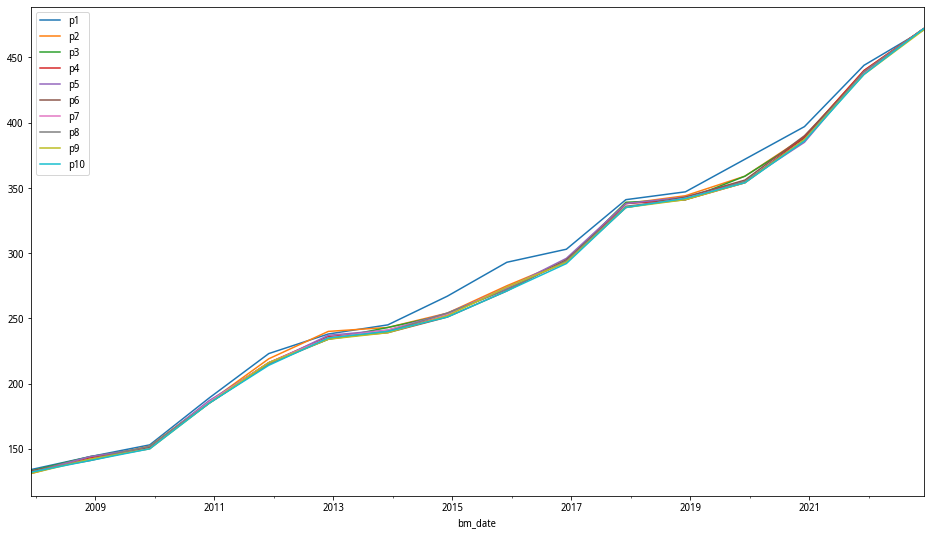

In [327]:
pf_n_stks = pd.DataFrame()
for key, value in portfolios.items():
    pf_n_stks[key] = portfolios[key].groupby('bm_date')['secID'].nunique()

display(pf_n_stks)

pf_n_stks.plot()

In [328]:
portfolios['p10'].groupby('bm_date')['mkt_cap'].mean()/1e9

bm_date
2007-12     9.542726
2008-12    24.894830
2009-12    23.400401
2010-12     7.330638
2011-12     4.288909
2012-12     6.852996
2013-12    24.818758
2014-12    30.313610
2015-12    46.562980
2016-12    49.633862
2017-12    25.174232
2018-12    23.576350
2019-12    25.416282
2020-12    27.492293
2021-12    24.716043
2022-12    25.729374
Freq: M, Name: mkt_cap, dtype: float64

p1            p2            p3            p4            p5  \
bm_date                                                                         
2007-12  5.630655e+09  4.798264e+09  2.876730e+09  3.355280e+09  3.951063e+09   
2008-12  8.178973e+09  9.146321e+09  7.128349e+09  6.812269e+09  7.259373e+09   
2009-12  1.071026e+10  8.369074e+09  7.495947e+09  8.559172e+09  9.185138e+09   
2010-12  9.810361e+09  6.731424e+09  5.541175e+09  5.788917e+09  5.701781e+09   
2011-12  8.587196e+09  5.192321e+09  5.859148e+09  8.239202e+09  1.323264e+10   
2012-12  7.933644e+09  7.147617e+09  5.764682e+09  6.531256e+09  8.286704e+09   
2013-12  1.040011e+10  9.921432e+09  8.797037e+09  8.957331e+09  8.985043e+09   
2014-12  1.110414e+10  1.253855e+10  1.251423e+10  1.087585e+10  1.278176e+10   
2015-12  9.342241e+09  9.029194e+09  9.919987e+09  1.014272e+10  9.218084e+09   
2016-12  8.672172e+09  1.300864e+10  8.145392e+09  9.267191e+09  1.054148e+10   
2017-12  1.780426e+10  9.119886e+09  7.239314e+09  9.046567e+09  8.909767e+09   
2018-12  2.191151e+10  1.316527e+10  8.365672e+09  8.509259e+09  1.022018e+10   
2019-12  4.058968e+10  1.920928e+10  1.227957e+10  8.884326e+09  1.358683e+10   
2020-12  5.050199e+10  1.585111e+10  1.316088e+10  1.043343e+10  8.433095e+09   
2021-12  3.727386e+10  1.558099e+10  1.228374e+10  1.056891e+10  9.971603e+09   
2022-12  2.710490e+10  1.483812e+10  1.265372e+10  9.901386e+09  1.096142e+10   

                   p6            p7            p8            p9           p10  
bm_date                                                                        
2007-12  3.269568e+09  2.655424e+09  2.311952e+09  1.676053e+09  9.542726e+09  
2008-12  5.630777e+09  6.089142e+09  5.187530e+09  7.724494e+09  2.489483e+10  
2009-12  1.346080e+10  1.394263e+10  1.182861e+10  4.310919e+09  2.340040e+10  
2010-12  1.164625e+10  1.966112e+10  1.477238e+10  7.540653e+09  7.330638e+09  
2011-12  8.510640e+09  1.434685e+10  7.458483e+09  3.779696e+09  4.288909e+09  
2012-12  1.406319e+10  1.345871e+10  4.797786e+09  6.148487e+09  6.852996e+09  
2013-12  7.210376e+09  1.400447e+10  1.697149e+10  1.815386e+10  2.481876e+10  
2014-12  1.062642e+10  1.064701e+10  1.912427e+10  1.357927e+10  3.031361e+10  
2015-12  1.074967e+10  9.973294e+09  1.022611e+10  1.547728e+10  4.656298e+10  
2016-12  8.595530e+09  1.158117e+10  1.130542e+10  1.626216e+10  4.963386e+10  
2017-12  8.501073e+09  8.094228e+09  1.126554e+10  1.213115e+10  2.517423e+10  
2018-12  9.067076e+09  1.208629e+10  1.469209e+10  1.134925e+10  2.357635e+10  
2019-12  1.566599e+10  1.317303e+10  1.111390e+10  1.180776e+10  2.541628e+10  
2020-12  1.186422e+10  1.355960e+10  1.104882e+10  1.148145e+10  2.749229e+10  
2021-12  8.428058e+09  8.990826e+09  1.343816e+10  1.207105e+10  2.471604e+10  
2022-12  8.908659e+09  9.592421e+09  1.074510e+10  1.272501e+10  2.572937e+10

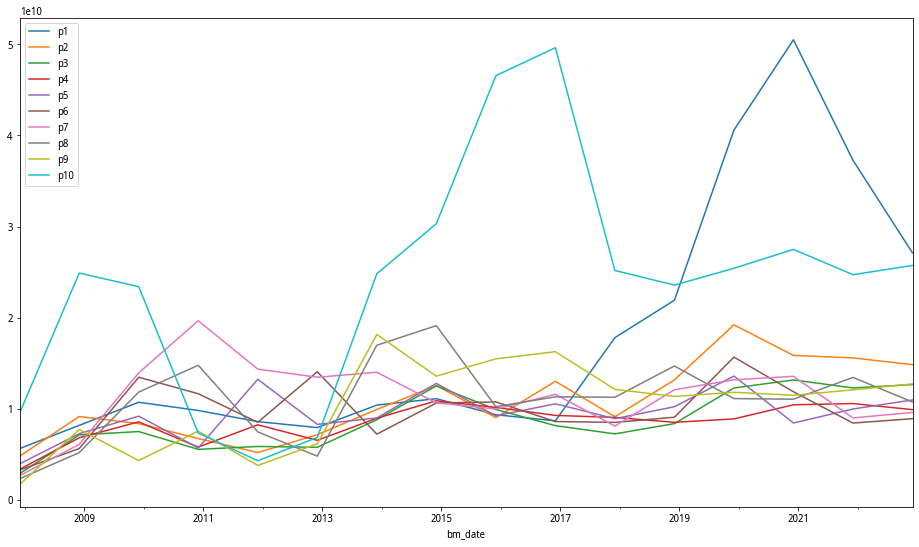

In [329]:
pf_mktcap = pd.DataFrame()
for key, value in portfolios.items():
    pf_mktcap[key] = portfolios[key].groupby('bm_date')['mkt_cap'].mean()

display(pf_mktcap)

pf_mktcap.plot()

In [330]:
pf_mktcap = pf_mktcap / 1e10
for i in range(10):
    print(pf_mktcap.mean()[i])

1.7847247100142434
1.0852969091438325
0.8751598397387613
0.8492066351781058
0.9451622740075204
0.9762393338086365
1.1366012783674107
1.1017977763666085
1.0388658587264499
2.37340177025748


## BM 1年调仓单排结论

排序方法：t年7月至t+1年6月，按照t-1年12月的BM排序，考察区间内每月平均收益率以及区间年平均收益率

结论：
- 月、年平均收益率呈现微弱递增，但p10的收益率较差。年收益的显著性比较强。
- 最大BM组（也即估值最低组）的market cap起伏很大
- 最小BM组（也即估值最高组）的market cap在样本后期显著增大
- BM的效应可能和market cap有关系

## BM Point-in-Time

In [331]:
del portfolios, portfolios_crs_mean

In [332]:
# fundmen_df = DataAPI.FdmtBSGet(secID=stk_id,beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

# fundmen_df.to_pickle('./data/fundmen_df_pit.pkl')

In [333]:
fundmen_df = pd.read_pickle('./data/fundmen_df_pit.pkl')

In [334]:
fundmen_df

secID publishDate     endDate  endDateRep           actPubtime  \
0       000001.XSHE  2024-03-15  2023-12-31  2023-12-31  2024-03-14 18:46:58   
1       000001.XSHE  2023-10-25  2023-09-30  2023-09-30  2023-10-24 17:52:46   
2       000001.XSHE  2023-08-24  2023-06-30  2023-06-30  2023-08-23 18:10:28   
3       000001.XSHE  2023-04-25  2023-03-31  2023-03-31  2023-04-24 18:00:27   
4       000001.XSHE  2024-03-15  2022-12-31  2023-12-31  2024-03-14 18:46:58   
5       000001.XSHE  2023-10-25  2022-12-31  2023-09-30  2023-10-24 17:52:46   
6       000001.XSHE  2023-08-24  2022-12-31  2023-06-30  2023-08-23 18:10:28   
7       000001.XSHE  2023-04-25  2022-12-31  2023-03-31  2023-04-24 18:00:27   
...             ...         ...         ...         ...                  ...   
482037  900957.XSHG  2009-03-26  2007-12-31  2008-12-31  2009-03-25 18:00:00   
482038  900957.XSHG  2008-10-24  2007-12-31  2008-09-30  2008-10-23 18:00:00   
482039  900957.XSHG  2008-08-25  2007-12-31  2008-06-30  2008-08-24 18:00:00   
482040  900957.XSHG  2008-04-24  2007-12-31  2008-03-31  2008-04-23 18:00:00   
482041  900957.XSHG  2008-04-08  2007-12-31  2007-12-31  2008-04-07 18:00:00   
482042  900957.XSHG  2007-10-23  2007-09-30  2007-09-30  2007-10-22 18:00:00   
482043  900957.XSHG  2007-08-31  2007-06-30  2007-06-30  2007-08-30 18:00:00   
482044  900957.XSHG  2007-04-26  2007-03-31  2007-03-31  2007-04-25 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
0                12  4.723280e+11  4.723280e+11          NaN  
1                 9  4.658600e+11  4.658600e+11          NaN  
2                 6  4.520730e+11  4.520730e+11          NaN  
3                 3  4.467450e+11  4.467450e+11          NaN  
4                12  4.346800e+11  4.346800e+11          NaN  
5                12  4.346800e+11  4.346800e+11          NaN  
6                12  4.346800e+11  4.346800e+11          NaN  
7                12  4.346800e+11  4.346800e+11          NaN  
...             ...           ...           ...          ...  
482037           12  4.363166e+08  3.769447e+08  59371874.07  
482038           12  4.363166e+08  3.769447e+08  59371874.07  
482039           12  4.363166e+08  3.769447e+08  59371874.07  
482040           12  4.363166e+08  3.769447e+08  59371874.07  
482041           12  4.363166e+08  3.769447e+08  59371874.07  
482042            9  4.328222e+08  3.774350e+08  55387111.58  
482043            6  4.287524e+08  3.755800e+08  53172311.54  
482044            3  4.312767e+08  3.687691e+08  62507665.37  

[482045 rows x 9 columns]

In [335]:
fundmen_df[['publishDate','endDate']] = fundmen_df[['publishDate','endDate']].apply(pd.to_datetime)

In [336]:
fundmen_df.sort_values(['secID','publishDate','endDate'],inplace=True)

In [337]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
131     000001.XSHE  2007-04-26 2007-03-31  2007-03-31  2007-04-25 18:00:00   
130     000001.XSHE  2007-08-16 2007-06-30  2007-06-30  2007-08-15 18:00:00   
129     000001.XSHE  2007-10-23 2007-09-30  2007-09-30  2007-10-22 18:00:00   
128     000001.XSHE  2008-03-20 2007-12-31  2007-12-31  2008-03-19 18:00:00   
127     000001.XSHE  2008-04-24 2007-12-31  2008-03-31  2008-04-23 18:00:00   
123     000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
126     000001.XSHE  2008-08-21 2007-12-31  2008-06-30  2008-08-20 18:00:00   
122     000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
...             ...         ...        ...         ...                  ...   
481921  900957.XSHG  2023-04-08 2021-12-31  2022-12-31  2023-04-07 15:38:50   
481917  900957.XSHG  2023-04-08 2022-12-31  2022-12-31  2023-04-07 15:38:50   
481916  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  2023-04-26 18:14:09   
481913  900957.XSHG  2023-04-27 2023-03-31  2023-03-31  2023-04-26 18:14:09   
481915  900957.XSHG  2023-08-08 2022-12-31  2023-06-30  2023-08-07 15:32:40   
481912  900957.XSHG  2023-08-08 2023-06-30  2023-06-30  2023-08-07 15:32:40   
481914  900957.XSHG  2023-10-28 2022-12-31  2023-09-30  2023-10-27 15:36:39   
481911  900957.XSHG  2023-10-28 2023-09-30  2023-09-30  2023-10-27 15:36:39   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
131               3  7.106094e+09  7.106094e+09          NaN  
130               6  7.698478e+09  7.698478e+09          NaN  
129               9  8.363553e+09  8.363553e+09          NaN  
128              12  1.300606e+10  1.300606e+10          NaN  
127              12  1.300606e+10  1.300606e+10          NaN  
123               3  1.404138e+10  1.404138e+10          NaN  
126              12  1.300606e+10  1.300606e+10          NaN  
122               6  1.694330e+10  1.694330e+10          NaN  
...             ...           ...           ...          ...  
481921           12  5.263733e+08  5.255741e+08    799194.04  
481917           12  5.669258e+08  5.660700e+08    855788.18  
481916           12  5.669258e+08  5.660700e+08    855788.18  
481913            3  5.756460e+08  5.747912e+08    854765.57  
481915           12  5.669258e+08  5.660700e+08    855788.18  
481912            6  5.862225e+08  5.853687e+08    853798.86  
481914           12  5.669258e+08  5.660700e+08    855788.18  
481911            9  5.983664e+08  5.975140e+08    852427.19  

[482045 rows x 9 columns]

In [338]:
fundmen_df.loc[fundmen_df.duplicated(['secID','publishDate'], keep=False)] # 同一报表中包含往期信息

secID publishDate    endDate  endDateRep           actPubtime  \
127     000001.XSHE  2008-04-24 2007-12-31  2008-03-31  2008-04-23 18:00:00   
123     000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
126     000001.XSHE  2008-08-21 2007-12-31  2008-06-30  2008-08-20 18:00:00   
122     000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
125     000001.XSHE  2008-10-24 2007-12-31  2008-09-30  2008-10-23 18:00:00   
121     000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
124     000001.XSHE  2009-03-20 2007-12-31  2008-12-31  2009-03-19 18:00:00   
120     000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
...             ...         ...        ...         ...                  ...   
481921  900957.XSHG  2023-04-08 2021-12-31  2022-12-31  2023-04-07 15:38:50   
481917  900957.XSHG  2023-04-08 2022-12-31  2022-12-31  2023-04-07 15:38:50   
481916  900957.XSHG  2023-04-27 2022-12-31  2023-03-31  2023-04-26 18:14:09   
481913  900957.XSHG  2023-04-27 2023-03-31  2023-03-31  2023-04-26 18:14:09   
481915  900957.XSHG  2023-08-08 2022-12-31  2023-06-30  2023-08-07 15:32:40   
481912  900957.XSHG  2023-08-08 2023-06-30  2023-06-30  2023-08-07 15:32:40   
481914  900957.XSHG  2023-10-28 2022-12-31  2023-09-30  2023-10-27 15:36:39   
481911  900957.XSHG  2023-10-28 2023-09-30  2023-09-30  2023-10-27 15:36:39   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
127              12  1.300606e+10  1.300606e+10          NaN  
123               3  1.404138e+10  1.404138e+10          NaN  
126              12  1.300606e+10  1.300606e+10          NaN  
122               6  1.694330e+10  1.694330e+10          NaN  
125              12  1.300606e+10  1.300606e+10          NaN  
121               9  1.837466e+10  1.837466e+10          NaN  
124              12  1.300606e+10  1.300606e+10          NaN  
120              12  1.640079e+10  1.640079e+10          NaN  
...             ...           ...           ...          ...  
481921           12  5.263733e+08  5.255741e+08    799194.04  
481917           12  5.669258e+08  5.660700e+08    855788.18  
481916           12  5.669258e+08  5.660700e+08    855788.18  
481913            3  5.756460e+08  5.747912e+08    854765.57  
481915           12  5.669258e+08  5.660700e+08    855788.18  
481912            6  5.862225e+08  5.853687e+08    853798.86  
481914           12  5.669258e+08  5.660700e+08    855788.18  
481911            9  5.983664e+08  5.975140e+08    852427.19  

[474076 rows x 9 columns]

In [339]:
fundmen_df.loc[~fundmen_df.duplicated(['secID','publishDate'], keep=False)] # 只有当期信息

secID publishDate    endDate  endDateRep           actPubtime  \
131     000001.XSHE  2007-04-26 2007-03-31  2007-03-31  2007-04-25 18:00:00   
130     000001.XSHE  2007-08-16 2007-06-30  2007-06-30  2007-08-15 18:00:00   
129     000001.XSHE  2007-10-23 2007-09-30  2007-09-30  2007-10-22 18:00:00   
128     000001.XSHE  2008-03-20 2007-12-31  2007-12-31  2008-03-19 18:00:00   
267     000002.XSHE  2007-04-30 2007-03-31  2007-03-31  2007-04-29 18:00:00   
266     000002.XSHE  2007-08-28 2007-06-30  2007-06-30  2007-08-27 18:00:00   
265     000002.XSHE  2007-10-30 2007-09-30  2007-09-30  2007-10-29 18:00:00   
264     000002.XSHE  2008-03-21 2007-12-31  2007-12-31  2008-03-20 18:00:00   
...             ...         ...        ...         ...                  ...   
481793  900955.XSHG  2008-04-15 2007-12-31  2007-12-31  2008-04-14 18:00:00   
481910  900956.XSHG  2007-04-30 2007-03-31  2007-03-31  2007-04-29 18:00:00   
481909  900956.XSHG  2007-07-28 2007-06-30  2007-06-30  2007-07-27 18:00:00   
481908  900956.XSHG  2007-10-29 2007-09-30  2007-09-30  2007-10-28 18:00:00   
482044  900957.XSHG  2007-04-26 2007-03-31  2007-03-31  2007-04-25 18:00:00   
482043  900957.XSHG  2007-08-31 2007-06-30  2007-06-30  2007-08-30 18:00:00   
482042  900957.XSHG  2007-10-23 2007-09-30  2007-09-30  2007-10-22 18:00:00   
482041  900957.XSHG  2008-04-08 2007-12-31  2007-12-31  2008-04-07 18:00:00   

       fiscalPeriod     TShEquity  TEquityAttrP   minorityInt  
131               3  7.106094e+09  7.106094e+09           NaN  
130               6  7.698478e+09  7.698478e+09           NaN  
129               9  8.363553e+09  8.363553e+09           NaN  
128              12  1.300606e+10  1.300606e+10           NaN  
267               3  1.795121e+10  1.565661e+10  2.294603e+09  
266               6  1.823739e+10  1.581408e+10  2.423310e+09  
265               9  2.945623e+10  2.610483e+10  3.351399e+09  
264              12  3.391952e+10  2.927865e+10  4.640875e+09  
...             ...           ...           ...           ...  
481793           12  2.043596e+09  2.034724e+09  8.871867e+06  
481910            3  4.753656e+08  4.242013e+08  5.116427e+07  
481909            6  4.933886e+08  4.354376e+08  5.795104e+07  
481908            9  5.038402e+08  4.453259e+08  5.851431e+07  
482044            3  4.312767e+08  3.687691e+08  6.250767e+07  
482043            6  4.287524e+08  3.755800e+08  5.317231e+07  
482042            9  4.328222e+08  3.774350e+08  5.538711e+07  
482041           12  4.363166e+08  3.769447e+08  5.937187e+07  

[7969 rows x 9 columns]

In [340]:
fundmen_df = fundmen_df.groupby(['secID','publishDate'],as_index=False).last() #不涉及上上个报表的信息

In [341]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
0       000001.XSHE  2007-04-26 2007-03-31  2007-03-31  2007-04-25 18:00:00   
1       000001.XSHE  2007-08-16 2007-06-30  2007-06-30  2007-08-15 18:00:00   
2       000001.XSHE  2007-10-23 2007-09-30  2007-09-30  2007-10-22 18:00:00   
3       000001.XSHE  2008-03-20 2007-12-31  2007-12-31  2008-03-19 18:00:00   
4       000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
5       000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
6       000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
7       000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
...             ...         ...        ...         ...                  ...   
216429  900957.XSHG  2022-04-20 2021-12-31  2021-12-31  2022-04-19 17:15:56   
216430  900957.XSHG  2022-04-30 2022-03-31  2022-03-31  2022-04-29 15:36:38   
216431  900957.XSHG  2022-08-16 2022-06-30  2022-06-30  2022-08-15 16:24:24   
216432  900957.XSHG  2022-10-28 2022-09-30  2022-09-30  2022-10-27 16:41:28   
216433  900957.XSHG  2023-04-08 2022-12-31  2022-12-31  2023-04-07 15:38:50   
216434  900957.XSHG  2023-04-27 2023-03-31  2023-03-31  2023-04-26 18:14:09   
216435  900957.XSHG  2023-08-08 2023-06-30  2023-06-30  2023-08-07 15:32:40   
216436  900957.XSHG  2023-10-28 2023-09-30  2023-09-30  2023-10-27 15:36:39   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt  
0                 3  7.106094e+09  7.106094e+09          NaN  
1                 6  7.698478e+09  7.698478e+09          NaN  
2                 9  8.363553e+09  8.363553e+09          NaN  
3                12  1.300606e+10  1.300606e+10          NaN  
4                 3  1.404138e+10  1.404138e+10          NaN  
5                 6  1.694330e+10  1.694330e+10          NaN  
6                 9  1.837466e+10  1.837466e+10          NaN  
7                12  1.640079e+10  1.640079e+10          NaN  
...             ...           ...           ...          ...  
216429           12  5.263733e+08  5.255741e+08    799194.04  
216430            3  5.341491e+08  5.333509e+08    798170.28  
216431            6  5.483870e+08  5.476224e+08    764620.52  
216432            9  5.566301e+08  5.558669e+08    763140.90  
216433           12  5.669258e+08  5.660700e+08    855788.18  
216434            3  5.756460e+08  5.747912e+08    854765.57  
216435            6  5.862225e+08  5.853687e+08    853798.86  
216436            9  5.983664e+08  5.975140e+08    852427.19  

[216437 rows x 9 columns]

In [342]:
fundmen_df['secID'].str[-4:].unique()

array(['XSHE', 'SHE2', 'XSHG'], dtype=object)

In [343]:
fundmen_df.loc[fundmen_df['secID'].str.endswith('SHE2')]

secID publishDate    endDate  endDateRep           actPubtime  \
2581  000043.XSHE2  2007-04-28 2007-03-31  2007-03-31  2007-04-27 18:00:00   
2582  000043.XSHE2  2007-04-30 2007-03-31  2007-03-31  2007-04-29 18:00:00   
2583  000043.XSHE2  2007-08-18 2007-06-30  2007-06-30  2007-08-17 18:00:00   
2584  000043.XSHE2  2007-08-20 2007-06-30  2007-06-30  2007-08-19 18:00:00   
2585  000043.XSHE2  2007-10-30 2007-09-30  2007-09-30  2007-10-29 18:00:00   
2586  000043.XSHE2  2008-04-11 2007-12-31  2007-12-31  2008-04-10 18:00:00   
2587  000043.XSHE2  2008-04-22 2008-03-31  2008-03-31  2008-04-21 18:00:00   
2588  000043.XSHE2  2008-08-19 2008-06-30  2008-06-30  2008-08-18 18:00:00   
...            ...         ...        ...         ...                  ...   
2643  000043.XSHE2  2022-04-28 2022-03-31  2022-03-31  2022-04-27 18:00:49   
2644  000043.XSHE2  2022-08-27 2022-06-30  2022-06-30  2022-08-26 16:40:24   
2645  000043.XSHE2  2022-10-26 2022-09-30  2022-09-30  2022-10-25 18:04:48   
2646  000043.XSHE2  2023-03-18 2022-12-31  2022-12-31  2023-03-17 19:24:29   
2647  000043.XSHE2  2023-04-22 2023-03-31  2023-03-31  2023-04-21 18:09:31   
2648  000043.XSHE2  2023-08-25 2023-06-30  2023-06-30  2023-08-24 16:04:57   
2649  000043.XSHE2  2023-10-27 2023-09-30  2023-09-30  2023-10-26 18:24:59   
2650  000043.XSHE2  2024-03-16 2023-12-31  2023-12-31  2024-03-15 20:29:31   

     fiscalPeriod     TShEquity  TEquityAttrP   minorityInt  
2581            3  6.000622e+08  4.333743e+08  1.666879e+08  
2582            3  6.000622e+08  4.333743e+08  1.666879e+08  
2583            6  6.094195e+08  4.395480e+08  1.698716e+08  
2584            6  6.094195e+08  4.395480e+08  1.698716e+08  
2585            9  1.494239e+09  1.360025e+09  1.342143e+08  
2586           12  1.753205e+09  1.499986e+09  2.532189e+08  
2587            3  1.754624e+09  1.497749e+09  2.568750e+08  
2588            6  1.660061e+09  1.441032e+09  2.190291e+08  
...           ...           ...           ...           ...  
2643            3  8.722855e+09  8.805963e+09 -8.310777e+07  
2644            6  8.805322e+09  8.886309e+09 -8.098690e+07  
2645            9  9.224236e+09  9.028429e+09  1.958068e+08  
2646           12  9.311151e+09  9.149839e+09  1.613115e+08  
2647            3  9.503130e+09  9.334366e+09  1.687640e+08  
2648            6  9.746350e+09  9.569769e+09  1.765801e+08  
2649            9  9.809555e+09  9.618211e+09  1.913436e+08  
2650           12  9.910374e+09  9.759359e+09  1.510153e+08  

[70 rows x 9 columns]

In [344]:
DataAPI.FdmtBSGet(secID='000043.XSHE2',beginDate=START,endDate=END,publishDateEnd=u"",publishDateBegin=u"",endDateRep="",beginDateRep="",beginYear="",endYear="",fiscalPeriod="",field=["secID","secShortName","publishDate","endDate","endDateRep","actPubtime","fiscalPeriod","TShEquity","TEquityAttrP","minorityInt"],pandas="1")

secID secShortName publishDate     endDate  endDateRep  \
0    000043.XSHE2         中航善达  2024-03-16  2023-12-31  2023-12-31   
1    000043.XSHE2         中航善达  2023-10-27  2023-09-30  2023-09-30   
2    000043.XSHE2         中航善达  2023-08-25  2023-06-30  2023-06-30   
3    000043.XSHE2         中航善达  2023-04-22  2023-03-31  2023-03-31   
4    000043.XSHE2         中航善达  2024-03-16  2022-12-31  2023-12-31   
5    000043.XSHE2         中航善达  2023-10-27  2022-12-31  2023-09-30   
6    000043.XSHE2         中航善达  2023-08-25  2022-12-31  2023-06-30   
7    000043.XSHE2         中航善达  2023-04-22  2022-12-31  2023-03-31   
..            ...          ...         ...         ...         ...   
126  000043.XSHE2         中航善达  2008-08-19  2007-12-31  2008-06-30   
127  000043.XSHE2         中航善达  2008-04-22  2007-12-31  2008-03-31   
128  000043.XSHE2         中航善达  2008-04-11  2007-12-31  2007-12-31   
129  000043.XSHE2         中航善达  2007-10-30  2007-09-30  2007-09-30   
130  000043.XSHE2         中航善达  2007-08-20  2007-06-30  2007-06-30   
131  000043.XSHE2         中航善达  2007-08-18  2007-06-30  2007-06-30   
132  000043.XSHE2         中航善达  2007-04-30  2007-03-31  2007-03-31   
133  000043.XSHE2         中航善达  2007-04-28  2007-03-31  2007-03-31   

              actPubtime fiscalPeriod     TShEquity  TEquityAttrP  \
0    2024-03-15 20:29:31           12  9.910374e+09  9.759359e+09   
1    2023-10-26 18:24:59            9  9.809555e+09  9.618211e+09   
2    2023-08-24 16:04:57            6  9.746350e+09  9.569769e+09   
3    2023-04-21 18:09:31            3  9.503130e+09  9.334366e+09   
4    2024-03-15 20:29:31           12  9.311151e+09  9.149839e+09   
5    2023-10-26 18:24:59           12  9.311151e+09  9.149839e+09   
6    2023-08-24 16:04:57           12  9.311151e+09  9.149839e+09   
7    2023-04-21 18:09:31           12  9.311151e+09  9.149839e+09   
..                   ...          ...           ...           ...   
126  2008-08-18 18:00:00           12  1.753205e+09  1.499986e+09   
127  2008-04-21 18:00:00           12  1.753205e+09  1.499986e+09   
128  2008-04-10 18:00:00           12  1.753205e+09  1.499986e+09   
129  2007-10-29 18:00:00            9  1.494239e+09  1.360025e+09   
130  2007-08-19 18:00:00            6  6.094195e+08  4.395480e+08   
131  2007-08-17 18:00:00            6  6.094195e+08  4.395480e+08   
132  2007-04-29 18:00:00            3  6.000622e+08  4.333743e+08   
133  2007-04-27 18:00:00            3  6.000622e+08  4.333743e+08   

      minorityInt  
0    1.510153e+08  
1    1.913436e+08  
2    1.765801e+08  
3    1.687640e+08  
4    1.613115e+08  
5    1.613115e+08  
6    1.613115e+08  
7    1.613115e+08  
..            ...  
126  2.532189e+08  
127  2.532189e+08  
128  2.532189e+08  
129  1.342143e+08  
130  1.698716e+08  
131  1.698716e+08  
132  1.666879e+08  
133  1.666879e+08  

[134 rows x 10 columns]

In [345]:
fundmen_df = fundmen_df[(fundmen_df['secID'].str.endswith('XSHE')) | (fundmen_df['secID'].str.endswith('XSHG'))]

In [346]:
# # minorityInt 有时报告，有时不报告。空值时，假设就是上一次报告的值
# # fundmen_df['minorityInt'] = fundmen_df.groupby('secID')['minorityInt'].fillna(method='ffill')
# # 第一轮填完空值为有效数值后，剩下的空值再用0填充。
# fundmen_df['minorityInt'].fillna(0,inplace=True)

- 假设是上一次报告的值可能出现误差，因为股权变动了（注意ffill的方法）
- 直接用TEquityAttrP

In [347]:
# fundmen_df['book'] = fundmen_df['TShEquity'] - fundmen_df['minorityInt']
fundmen_df['book'] = fundmen_df['TEquityAttrP']

In [348]:
fundmen_df

secID publishDate    endDate  endDateRep           actPubtime  \
0       000001.XSHE  2007-04-26 2007-03-31  2007-03-31  2007-04-25 18:00:00   
1       000001.XSHE  2007-08-16 2007-06-30  2007-06-30  2007-08-15 18:00:00   
2       000001.XSHE  2007-10-23 2007-09-30  2007-09-30  2007-10-22 18:00:00   
3       000001.XSHE  2008-03-20 2007-12-31  2007-12-31  2008-03-19 18:00:00   
4       000001.XSHE  2008-04-24 2008-03-31  2008-03-31  2008-04-23 18:00:00   
5       000001.XSHE  2008-08-21 2008-06-30  2008-06-30  2008-08-20 18:00:00   
6       000001.XSHE  2008-10-24 2008-09-30  2008-09-30  2008-10-23 18:00:00   
7       000001.XSHE  2009-03-20 2008-12-31  2008-12-31  2009-03-19 18:00:00   
...             ...         ...        ...         ...                  ...   
216429  900957.XSHG  2022-04-20 2021-12-31  2021-12-31  2022-04-19 17:15:56   
216430  900957.XSHG  2022-04-30 2022-03-31  2022-03-31  2022-04-29 15:36:38   
216431  900957.XSHG  2022-08-16 2022-06-30  2022-06-30  2022-08-15 16:24:24   
216432  900957.XSHG  2022-10-28 2022-09-30  2022-09-30  2022-10-27 16:41:28   
216433  900957.XSHG  2023-04-08 2022-12-31  2022-12-31  2023-04-07 15:38:50   
216434  900957.XSHG  2023-04-27 2023-03-31  2023-03-31  2023-04-26 18:14:09   
216435  900957.XSHG  2023-08-08 2023-06-30  2023-06-30  2023-08-07 15:32:40   
216436  900957.XSHG  2023-10-28 2023-09-30  2023-09-30  2023-10-27 15:36:39   

       fiscalPeriod     TShEquity  TEquityAttrP  minorityInt          book  
0                 3  7.106094e+09  7.106094e+09          NaN  7.106094e+09  
1                 6  7.698478e+09  7.698478e+09          NaN  7.698478e+09  
2                 9  8.363553e+09  8.363553e+09          NaN  8.363553e+09  
3                12  1.300606e+10  1.300606e+10          NaN  1.300606e+10  
4                 3  1.404138e+10  1.404138e+10          NaN  1.404138e+10  
5                 6  1.694330e+10  1.694330e+10          NaN  1.694330e+10  
6                 9  1.837466e+10  1.837466e+10          NaN  1.837466e+10  
7                12  1.640079e+10  1.640079e+10          NaN  1.640079e+10  
...             ...           ...           ...          ...           ...  
216429           12  5.263733e+08  5.255741e+08    799194.04  5.255741e+08  
216430            3  5.341491e+08  5.333509e+08    798170.28  5.333509e+08  
216431            6  5.483870e+08  5.476224e+08    764620.52  5.476224e+08  
216432            9  5.566301e+08  5.558669e+08    763140.90  5.558669e+08  
216433           12  5.669258e+08  5.660700e+08    855788.18  5.660700e+08  
216434            3  5.756460e+08  5.747912e+08    854765.57  5.747912e+08  
216435            6  5.862225e+08  5.853687e+08    853798.86  5.853687e+08  
216436            9  5.983664e+08  5.975140e+08    852427.19  5.975140e+08  

[216367 rows x 10 columns]

- ~~考虑到报表公布时间可能在当天收市以后，以及报表解读可能需要时间，把publishDate往后加1~~
- publishDate和 tradeDate merge, 
- publishDate可能是非交易日，所以merge时要outer，左右表格都不丢观测值。
- 接着要把tradeDate为空值的设置为publishDate，便于排序，方便下面填充
- 然后按照secID和tradeDate sort，因为publishDate非交易日的被放到merge表格的最后了。
- 接着 book 空值由上面第一个非空值填充（当时已知的最新的book value）
- 再把 na 都丢弃即可

In [349]:
# fundmen_df['publishDate+1'] = fundmen_df['publishDate'] + dt.timedelta(days=1)

In [350]:
stk_fundmen_df = pd.merge(stk_df, fundmen_df[['secID','publishDate','endDate','book']], 
                          left_on=['secID','tradeDate'], right_on=['secID','publishDate'],
                          how='outer')

In [351]:
stk_fundmen_df

secID  tradeDate  closePrice  negMarketValue       ym  \
0         000001.XSHE 2007-06-20     987.007    4.835036e+10  2007-06   
1         000001.XSHE 2007-06-21    1085.740    5.318694e+10  2007-06   
2         000001.XSHE 2007-06-22    1120.233    5.487665e+10  2007-06   
3         000001.XSHE 2007-06-25    1113.904    5.456661e+10  2007-06   
4         000001.XSHE 2007-06-26    1113.904    5.456661e+10  2007-06   
5         000001.XSHE 2007-06-27    1019.602    4.994705e+10  2007-06   
6         000001.XSHE 2007-06-28     953.780    4.672266e+10  2007-06   
7         000001.XSHE 2007-06-29     870.870    4.266117e+10  2007-06   
...               ...        ...         ...             ...      ...   
12416343  900957.XSHG        NaT         NaN             NaN      NaT   
12416344  900957.XSHG        NaT         NaN             NaN      NaT   
12416345  900957.XSHG        NaT         NaN             NaN      NaT   
12416346  900957.XSHG        NaT         NaN             NaN      NaT   
12416347  900957.XSHG        NaT         NaN             NaN      NaT   
12416348  900957.XSHG        NaT         NaN             NaN      NaT   
12416349  900957.XSHG        NaT         NaN             NaN      NaT   
12416350  900957.XSHG        NaT         NaN             NaN      NaT   

         publishDate    endDate          book  
0                NaT        NaT           NaN  
1                NaT        NaT           NaN  
2                NaT        NaT           NaN  
3                NaT        NaT           NaN  
4                NaT        NaT           NaN  
5                NaT        NaT           NaN  
6                NaT        NaT           NaN  
7                NaT        NaT           NaN  
...              ...        ...           ...  
12416343  2016-08-06 2016-06-30  3.906354e+08  
12416344  2017-03-25 2016-12-31  3.930721e+08  
12416345  2019-03-30 2018-12-31  4.508051e+08  
12416346  2019-08-10 2019-06-30  4.618426e+08  
12416347  2020-04-25 2019-12-31  4.761021e+08  
12416348  2022-04-30 2022-03-31  5.333509e+08  
12416349  2023-04-08 2022-12-31  5.660700e+08  
12416350  2023-10-28 2023-09-30  5.975140e+08  

[12416351 rows x 8 columns]

In [352]:
stk_fundmen_df.loc[(stk_fundmen_df['secID']=='900957.XSHG')&(stk_fundmen_df['tradeDate']<='2016-08-10')&(stk_fundmen_df['tradeDate']>='2016-08-03')]

secID  tradeDate  closePrice  negMarketValue       ym  \
12351424  900957.XSHG 2016-08-03       1.299     237176000.0  2016-08   
12351425  900957.XSHG 2016-08-04       1.334     243432000.0  2016-08   
12351426  900957.XSHG 2016-08-05       1.328     242512000.0  2016-08   
12351427  900957.XSHG 2016-08-08       1.328     242512000.0  2016-08   
12351428  900957.XSHG 2016-08-09       1.334     243432000.0  2016-08   
12351429  900957.XSHG 2016-08-10       1.323     241592000.0  2016-08   

         publishDate endDate  book  
12351424         NaT     NaT   NaN  
12351425         NaT     NaT   NaN  
12351426         NaT     NaT   NaN  
12351427         NaT     NaT   NaN  
12351428         NaT     NaT   NaN  
12351429         NaT     NaT   NaN

In [353]:
stk_fundmen_df.loc[(stk_fundmen_df['secID']=='000001.XSHE')&(stk_fundmen_df['tradeDate']<='2008')&(stk_fundmen_df['tradeDate']>='2007-08-10')]

secID  tradeDate  closePrice  negMarketValue       ym publishDate  \
37   000001.XSHE 2007-08-10    1234.155    6.045732e+10  2007-08         NaT   
38   000001.XSHE 2007-08-13    1237.319    6.061234e+10  2007-08         NaT   
39   000001.XSHE 2007-08-14    1213.585    5.944970e+10  2007-08         NaT   
40   000001.XSHE 2007-08-15    1202.510    5.890714e+10  2007-08         NaT   
41   000001.XSHE 2007-08-16    1147.131    5.619431e+10  2007-08  2007-08-16   
42   000001.XSHE 2007-08-17    1103.777    5.407055e+10  2007-08         NaT   
43   000001.XSHE 2007-08-20    1199.345    5.875212e+10  2007-08         NaT   
44   000001.XSHE 2007-08-21    1220.231    5.977524e+10  2007-08         NaT   
..           ...        ...         ...             ...      ...         ...   
125  000001.XSHE 2007-12-19    1130.359    5.537271e+10  2007-12         NaT   
126  000001.XSHE 2007-12-20    1161.371    5.689189e+10  2007-12         NaT   
127  000001.XSHE 2007-12-21    1162.953    5.696940e+10  2007-12         NaT   
128  000001.XSHE 2007-12-24    1204.092    5.898465e+10  2007-12         NaT   
129  000001.XSHE 2007-12-25    1204.092    5.898465e+10  2007-12         NaT   
130  000001.XSHE 2007-12-26    1193.016    5.844208e+10  2007-12         NaT   
131  000001.XSHE 2007-12-27    1234.155    6.045732e+10  2007-12         NaT   
132  000001.XSHE 2007-12-28    1221.497    6.574629e+10  2007-12         NaT   

       endDate          book  
37         NaT           NaN  
38         NaT           NaN  
39         NaT           NaN  
40         NaT           NaN  
41  2007-06-30  7.698478e+09  
42         NaT           NaN  
43         NaT           NaN  
44         NaT           NaN  
..         ...           ...  
125        NaT           NaN  
126        NaT           NaN  
127        NaT           NaN  
128        NaT           NaN  
129        NaT           NaN  
130        NaT           NaN  
131        NaT           NaN  
132        NaT           NaN  

[96 rows x 8 columns]

In [354]:
idx = stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna()].index

In [355]:
stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna(),'tradeDate'] = stk_fundmen_df.loc[stk_fundmen_df['tradeDate'].isna(),'publishDate']

In [356]:
stk_fundmen_df.loc[idx]

secID  tradeDate  closePrice  negMarketValue   ym publishDate  \
12353284  000001.XSHE 2007-04-26         NaN             NaN  NaT  2007-04-26   
12353285  000001.XSHE 2017-04-22         NaN             NaN  NaT  2017-04-22   
12353286  000001.XSHE 2017-10-21         NaN             NaN  NaT  2017-10-21   
12353287  000002.XSHE 2022-10-29         NaN             NaN  NaT  2022-10-29   
12353288  000002.XSHE 2023-04-29         NaN             NaN  NaT  2023-04-29   
12353289  000002.XSHE 2023-10-28         NaN             NaN  NaT  2023-10-28   
12353290  000003.XSHE 2008-04-30         NaN             NaN  NaT  2008-04-30   
12353291  000003.XSHE 2008-08-29         NaN             NaN  NaT  2008-08-29   
...               ...        ...         ...             ...  ...         ...   
12416343  900957.XSHG 2016-08-06         NaN             NaN  NaT  2016-08-06   
12416344  900957.XSHG 2017-03-25         NaN             NaN  NaT  2017-03-25   
12416345  900957.XSHG 2019-03-30         NaN             NaN  NaT  2019-03-30   
12416346  900957.XSHG 2019-08-10         NaN             NaN  NaT  2019-08-10   
12416347  900957.XSHG 2020-04-25         NaN             NaN  NaT  2020-04-25   
12416348  900957.XSHG 2022-04-30         NaN             NaN  NaT  2022-04-30   
12416349  900957.XSHG 2023-04-08         NaN             NaN  NaT  2023-04-08   
12416350  900957.XSHG 2023-10-28         NaN             NaN  NaT  2023-10-28   

            endDate          book  
12353284 2007-03-31  7.106094e+09  
12353285 2017-03-31  2.077390e+11  
12353286 2017-09-30  2.181110e+11  
12353287 2022-09-30  2.411070e+11  
12353288 2023-03-31  2.460123e+11  
12353289 2023-09-30  2.529078e+11  
12353290 2007-12-31 -2.889290e+09  
12353291 2008-06-30 -2.872336e+09  
...             ...           ...  
12416343 2016-06-30  3.906354e+08  
12416344 2016-12-31  3.930721e+08  
12416345 2018-12-31  4.508051e+08  
12416346 2019-06-30  4.618426e+08  
12416347 2019-12-31  4.761021e+08  
12416348 2022-03-31  5.333509e+08  
12416349 2022-12-31  5.660700e+08  
12416350 2023-09-30  5.975140e+08  

[63067 rows x 8 columns]

In [357]:
stk_fundmen_df

secID  tradeDate  closePrice  negMarketValue       ym  \
0         000001.XSHE 2007-06-20     987.007    4.835036e+10  2007-06   
1         000001.XSHE 2007-06-21    1085.740    5.318694e+10  2007-06   
2         000001.XSHE 2007-06-22    1120.233    5.487665e+10  2007-06   
3         000001.XSHE 2007-06-25    1113.904    5.456661e+10  2007-06   
4         000001.XSHE 2007-06-26    1113.904    5.456661e+10  2007-06   
5         000001.XSHE 2007-06-27    1019.602    4.994705e+10  2007-06   
6         000001.XSHE 2007-06-28     953.780    4.672266e+10  2007-06   
7         000001.XSHE 2007-06-29     870.870    4.266117e+10  2007-06   
...               ...        ...         ...             ...      ...   
12416343  900957.XSHG 2016-08-06         NaN             NaN      NaT   
12416344  900957.XSHG 2017-03-25         NaN             NaN      NaT   
12416345  900957.XSHG 2019-03-30         NaN             NaN      NaT   
12416346  900957.XSHG 2019-08-10         NaN             NaN      NaT   
12416347  900957.XSHG 2020-04-25         NaN             NaN      NaT   
12416348  900957.XSHG 2022-04-30         NaN             NaN      NaT   
12416349  900957.XSHG 2023-04-08         NaN             NaN      NaT   
12416350  900957.XSHG 2023-10-28         NaN             NaN      NaT   

         publishDate    endDate          book  
0                NaT        NaT           NaN  
1                NaT        NaT           NaN  
2                NaT        NaT           NaN  
3                NaT        NaT           NaN  
4                NaT        NaT           NaN  
5                NaT        NaT           NaN  
6                NaT        NaT           NaN  
7                NaT        NaT           NaN  
...              ...        ...           ...  
12416343  2016-08-06 2016-06-30  3.906354e+08  
12416344  2017-03-25 2016-12-31  3.930721e+08  
12416345  2019-03-30 2018-12-31  4.508051e+08  
12416346  2019-08-10 2019-06-30  4.618426e+08  
12416347  2020-04-25 2019-12-31  4.761021e+08  
12416348  2022-04-30 2022-03-31  5.333509e+08  
12416349  2023-04-08 2022-12-31  5.660700e+08  
12416350  2023-10-28 2023-09-30  5.975140e+08  

[12416351 rows x 8 columns]

In [358]:
stk_fundmen_df.sort_values(['secID','tradeDate'],inplace=True)

In [359]:
stk_fundmen_df

secID  tradeDate  closePrice  negMarketValue       ym  \
12353284  000001.XSHE 2007-04-26         NaN             NaN      NaT   
0         000001.XSHE 2007-06-20     987.007    4.835036e+10  2007-06   
1         000001.XSHE 2007-06-21    1085.740    5.318694e+10  2007-06   
2         000001.XSHE 2007-06-22    1120.233    5.487665e+10  2007-06   
3         000001.XSHE 2007-06-25    1113.904    5.456661e+10  2007-06   
4         000001.XSHE 2007-06-26    1113.904    5.456661e+10  2007-06   
5         000001.XSHE 2007-06-27    1019.602    4.994705e+10  2007-06   
6         000001.XSHE 2007-06-28     953.780    4.672266e+10  2007-06   
...               ...        ...         ...             ...      ...   
12353276  900957.XSHG 2024-03-20       0.423    7.728000e+07  2024-03   
12353277  900957.XSHG 2024-03-21       0.419    7.654400e+07  2024-03   
12353278  900957.XSHG 2024-03-22       0.418    7.636000e+07  2024-03   
12353279  900957.XSHG 2024-03-25       0.410    7.488800e+07  2024-03   
12353280  900957.XSHG 2024-03-26       0.414    7.562400e+07  2024-03   
12353281  900957.XSHG 2024-03-27       0.411    7.507200e+07  2024-03   
12353282  900957.XSHG 2024-03-28       0.418    7.636000e+07  2024-03   
12353283  900957.XSHG 2024-03-29       0.421    7.691200e+07  2024-03   

         publishDate    endDate          book  
12353284  2007-04-26 2007-03-31  7.106094e+09  
0                NaT        NaT           NaN  
1                NaT        NaT           NaN  
2                NaT        NaT           NaN  
3                NaT        NaT           NaN  
4                NaT        NaT           NaN  
5                NaT        NaT           NaN  
6                NaT        NaT           NaN  
...              ...        ...           ...  
12353276         NaT        NaT           NaN  
12353277         NaT        NaT           NaN  
12353278         NaT        NaT           NaN  
12353279         NaT        NaT           NaN  
12353280         NaT        NaT           NaN  
12353281         NaT        NaT           NaN  
12353282         NaT        NaT           NaN  
12353283         NaT        NaT           NaN  

[12416351 rows x 8 columns]

In [360]:
temp = stk_fundmen_df[stk_fundmen_df['secID']=='000001.XSHE'].copy()
temp

secID  tradeDate  closePrice  negMarketValue       ym  \
12353284  000001.XSHE 2007-04-26         NaN             NaN      NaT   
0         000001.XSHE 2007-06-20     987.007    4.835036e+10  2007-06   
1         000001.XSHE 2007-06-21    1085.740    5.318694e+10  2007-06   
2         000001.XSHE 2007-06-22    1120.233    5.487665e+10  2007-06   
3         000001.XSHE 2007-06-25    1113.904    5.456661e+10  2007-06   
4         000001.XSHE 2007-06-26    1113.904    5.456661e+10  2007-06   
5         000001.XSHE 2007-06-27    1019.602    4.994705e+10  2007-06   
6         000001.XSHE 2007-06-28     953.780    4.672266e+10  2007-06   
...               ...        ...         ...             ...      ...   
4074      000001.XSHE 2024-03-20    1401.029    2.027880e+11  2024-03   
4075      000001.XSHE 2024-03-21    1403.710    2.031761e+11  2024-03   
4076      000001.XSHE 2024-03-22    1388.962    2.010415e+11  2024-03   
4077      000001.XSHE 2024-03-25    1394.325    2.018177e+11  2024-03   
4078      000001.XSHE 2024-03-26    1421.139    2.056988e+11  2024-03   
4079      000001.XSHE 2024-03-27    1411.754    2.043404e+11  2024-03   
4080      000001.XSHE 2024-03-28    1406.391    2.035642e+11  2024-03   
4081      000001.XSHE 2024-03-29    1410.413    2.041464e+11  2024-03   

         publishDate    endDate          book  
12353284  2007-04-26 2007-03-31  7.106094e+09  
0                NaT        NaT           NaN  
1                NaT        NaT           NaN  
2                NaT        NaT           NaN  
3                NaT        NaT           NaN  
4                NaT        NaT           NaN  
5                NaT        NaT           NaN  
6                NaT        NaT           NaN  
...              ...        ...           ...  
4074             NaT        NaT           NaN  
4075             NaT        NaT           NaN  
4076             NaT        NaT           NaN  
4077             NaT        NaT           NaN  
4078             NaT        NaT           NaN  
4079             NaT        NaT           NaN  
4080             NaT        NaT           NaN  
4081             NaT        NaT           NaN  

[4085 rows x 8 columns]

In [361]:
temp[~temp['book'].isna()]

secID  tradeDate  closePrice  negMarketValue       ym  \
12353284  000001.XSHE 2007-04-26         NaN             NaN      NaT   
41        000001.XSHE 2007-08-16    1147.131    5.619431e+10  2007-08   
84        000001.XSHE 2007-10-23    1300.609    6.371272e+10  2007-10   
184       000001.XSHE 2008-03-20     917.705    5.094780e+10  2008-03   
208       000001.XSHE 2008-04-24     869.921    4.829500e+10  2008-04   
290       000001.XSHE 2008-08-21     639.545    4.328991e+10  2008-08   
330       000001.XSHE 2008-10-24     380.689    2.576831e+10  2008-10   
428       000001.XSHE 2009-03-20     632.527    4.268801e+10  2009-03   
...               ...        ...         ...             ...      ...   
3614      000001.XSHE 2022-04-27    2011.505    3.036964e+11  2022-04   
3691      000001.XSHE 2022-08-18    1602.586    2.377180e+11  2022-08   
3733      000001.XSHE 2022-10-25    1393.269    2.066691e+11  2022-10   
3824      000001.XSHE 2023-03-09    1726.868    2.561532e+11  2023-03   
3856      000001.XSHE 2023-04-25    1606.511    2.383001e+11  2023-04   
3938      000001.XSHE 2023-08-24    1492.196    2.159837e+11  2023-08   
3976      000001.XSHE 2023-10-25    1391.644    2.014296e+11  2023-10   
4071      000001.XSHE 2024-03-15    1421.139    2.056988e+11  2024-03   

         publishDate    endDate          book  
12353284  2007-04-26 2007-03-31  7.106094e+09  
41        2007-08-16 2007-06-30  7.698478e+09  
84        2007-10-23 2007-09-30  8.363553e+09  
184       2008-03-20 2007-12-31  1.300606e+10  
208       2008-04-24 2008-03-31  1.404138e+10  
290       2008-08-21 2008-06-30  1.694330e+10  
330       2008-10-24 2008-09-30  1.837466e+10  
428       2009-03-20 2008-12-31  1.640079e+10  
...              ...        ...           ...  
3614      2022-04-27 2022-03-31  4.061750e+11  
3691      2022-08-18 2022-06-30  4.120980e+11  
3733      2022-10-25 2022-09-30  4.253840e+11  
3824      2023-03-09 2022-12-31  4.346800e+11  
3856      2023-04-25 2023-03-31  4.467450e+11  
3938      2023-08-24 2023-06-30  4.520730e+11  
3976      2023-10-25 2023-09-30  4.658600e+11  
4071      2024-03-15 2023-12-31  4.723280e+11  

[68 rows x 8 columns]

In [362]:
stk_fundmen_df[['secID','publishDate','endDate','book']].groupby('secID').fillna(method='ffill')

publishDate    endDate          book
12353284  2007-04-26 2007-03-31  7.106094e+09
0         2007-04-26 2007-03-31  7.106094e+09
1         2007-04-26 2007-03-31  7.106094e+09
2         2007-04-26 2007-03-31  7.106094e+09
3         2007-04-26 2007-03-31  7.106094e+09
4         2007-04-26 2007-03-31  7.106094e+09
5         2007-04-26 2007-03-31  7.106094e+09
6         2007-04-26 2007-03-31  7.106094e+09
...              ...        ...           ...
12353276  2023-10-28 2023-09-30  5.975140e+08
12353277  2023-10-28 2023-09-30  5.975140e+08
12353278  2023-10-28 2023-09-30  5.975140e+08
12353279  2023-10-28 2023-09-30  5.975140e+08
12353280  2023-10-28 2023-09-30  5.975140e+08
12353281  2023-10-28 2023-09-30  5.975140e+08
12353282  2023-10-28 2023-09-30  5.975140e+08
12353283  2023-10-28 2023-09-30  5.975140e+08

[12416351 rows x 3 columns]

In [363]:
stk_fundmen_df.shape

(12416351, 8)

In [364]:
stk_fundmen_df.loc[:,['publishDate','endDate','book']] = stk_fundmen_df[['secID','publishDate','endDate','book']].groupby('secID').fillna(method='ffill')

In [365]:
## 查看数据
idx = pd.IndexSlice
stk_fundmen_df.set_index(['secID','tradeDate'],inplace=True)
pd.options.display.max_rows = 20

In [366]:
stk_fundmen_df.loc[idx['000001.XSHE','2010-03'],:]

closePrice  negMarketValue       ym publishDate  \
secID       tradeDate                                                     
000001.XSHE 2010-03-01     926.303    6.564637e+10  2010-03  2009-10-29   
            2010-03-02     953.535    6.757628e+10  2010-03  2009-10-29   
            2010-03-03     961.374    6.813186e+10  2010-03  2009-10-29   
            2010-03-04     953.122    6.754704e+10  2010-03  2009-10-29   
            2010-03-05     960.137    6.804414e+10  2010-03  2009-10-29   
            2010-03-08     984.068    6.974013e+10  2010-03  2009-10-29   
            2010-03-09     982.830    6.965240e+10  2010-03  2009-10-29   
            2010-03-10     965.500    6.842427e+10  2010-03  2009-10-29   
            2010-03-11     976.228    6.918454e+10  2010-03  2009-10-29   
            2010-03-12     945.695    6.702070e+10  2010-03  2010-03-12   
...                            ...             ...      ...         ...   
            2010-03-18     951.059    6.740083e+10  2010-03  2010-03-12   
            2010-03-19     950.647    6.737159e+10  2010-03  2010-03-12   
            2010-03-22     955.185    6.769325e+10  2010-03  2010-03-12   
            2010-03-23     941.982    6.675753e+10  2010-03  2010-03-12   
            2010-03-24     940.744    6.666981e+10  2010-03  2010-03-12   
            2010-03-25     920.114    6.520775e+10  2010-03  2010-03-12   
            2010-03-26     941.157    6.669905e+10  2010-03  2010-03-12   
            2010-03-29     972.102    6.889213e+10  2010-03  2010-03-12   
            2010-03-30     975.816    6.915530e+10  2010-03  2010-03-12   
            2010-03-31     957.248    6.783945e+10  2010-03  2010-03-12   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2010-03-01 2009-09-30  1.908844e+10  
            2010-03-02 2009-09-30  1.908844e+10  
            2010-03-03 2009-09-30  1.908844e+10  
            2010-03-04 2009-09-30  1.908844e+10  
            2010-03-05 2009-09-30  1.908844e+10  
            2010-03-08 2009-09-30  1.908844e+10  
            2010-03-09 2009-09-30  1.908844e+10  
            2010-03-10 2009-09-30  1.908844e+10  
            2010-03-11 2009-09-30  1.908844e+10  
            2010-03-12 2009-12-31  2.046961e+10  
...                           ...           ...  
            2010-03-18 2009-12-31  2.046961e+10  
            2010-03-19 2009-12-31  2.046961e+10  
            2010-03-22 2009-12-31  2.046961e+10  
            2010-03-23 2009-12-31  2.046961e+10  
            2010-03-24 2009-12-31  2.046961e+10  
            2010-03-25 2009-12-31  2.046961e+10  
            2010-03-26 2009-12-31  2.046961e+10  
            2010-03-29 2009-12-31  2.046961e+10  
            2010-03-30 2009-12-31  2.046961e+10  
            2010-03-31 2009-12-31  2.046961e+10  

[23 rows x 6 columns]

In [367]:
stk_fundmen_df.loc[idx['000001.XSHE','2007-04'],:]

closePrice  negMarketValue   ym publishDate  \
secID       tradeDate                                                 
000001.XSHE 2007-04-26         NaN             NaN  NaT  2007-04-26   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2007-04-26 2007-03-31  7.106094e+09

In [368]:
stk_fundmen_df.loc[idx['000001.XSHE','2007-04':'2007-06'],:]

closePrice  negMarketValue       ym publishDate  \
secID       tradeDate                                                     
000001.XSHE 2007-04-26         NaN             NaN      NaT  2007-04-26   
            2007-06-20     987.007    4.835036e+10  2007-06  2007-04-26   
            2007-06-21    1085.740    5.318694e+10  2007-06  2007-04-26   
            2007-06-22    1120.233    5.487665e+10  2007-06  2007-04-26   
            2007-06-25    1113.904    5.456661e+10  2007-06  2007-04-26   
            2007-06-26    1113.904    5.456661e+10  2007-06  2007-04-26   
            2007-06-27    1019.602    4.994705e+10  2007-06  2007-04-26   
            2007-06-28     953.780    4.672266e+10  2007-06  2007-04-26   
            2007-06-29     870.870    4.266117e+10  2007-06  2007-04-26   

                          endDate          book  
secID       tradeDate                            
000001.XSHE 2007-04-26 2007-03-31  7.106094e+09  
            2007-06-20 2007-03-31  7.106094e+09  
            2007-06-21 2007-03-31  7.106094e+09  
            2007-06-22 2007-03-31  7.106094e+09  
            2007-06-25 2007-03-31  7.106094e+09  
            2007-06-26 2007-03-31  7.106094e+09  
            2007-06-27 2007-03-31  7.106094e+09  
            2007-06-28 2007-03-31  7.106094e+09  
            2007-06-29 2007-03-31  7.106094e+09

In [369]:
stk_fundmen_df.reset_index(inplace=True)

In [370]:
stk_fundmen_df

secID  tradeDate  closePrice  negMarketValue       ym  \
0         000001.XSHE 2007-04-26         NaN             NaN      NaT   
1         000001.XSHE 2007-06-20     987.007    4.835036e+10  2007-06   
2         000001.XSHE 2007-06-21    1085.740    5.318694e+10  2007-06   
3         000001.XSHE 2007-06-22    1120.233    5.487665e+10  2007-06   
4         000001.XSHE 2007-06-25    1113.904    5.456661e+10  2007-06   
5         000001.XSHE 2007-06-26    1113.904    5.456661e+10  2007-06   
6         000001.XSHE 2007-06-27    1019.602    4.994705e+10  2007-06   
7         000001.XSHE 2007-06-28     953.780    4.672266e+10  2007-06   
8         000001.XSHE 2007-06-29     870.870    4.266117e+10  2007-06   
9         000001.XSHE 2007-07-02     867.073    4.247515e+10  2007-07   
...               ...        ...         ...             ...      ...   
12416341  900957.XSHG 2024-03-18       0.436    7.967200e+07  2024-03   
12416342  900957.XSHG 2024-03-19       0.429    7.838400e+07  2024-03   
12416343  900957.XSHG 2024-03-20       0.423    7.728000e+07  2024-03   
12416344  900957.XSHG 2024-03-21       0.419    7.654400e+07  2024-03   
12416345  900957.XSHG 2024-03-22       0.418    7.636000e+07  2024-03   
12416346  900957.XSHG 2024-03-25       0.410    7.488800e+07  2024-03   
12416347  900957.XSHG 2024-03-26       0.414    7.562400e+07  2024-03   
12416348  900957.XSHG 2024-03-27       0.411    7.507200e+07  2024-03   
12416349  900957.XSHG 2024-03-28       0.418    7.636000e+07  2024-03   
12416350  900957.XSHG 2024-03-29       0.421    7.691200e+07  2024-03   

         publishDate    endDate          book  
0         2007-04-26 2007-03-31  7.106094e+09  
1         2007-04-26 2007-03-31  7.106094e+09  
2         2007-04-26 2007-03-31  7.106094e+09  
3         2007-04-26 2007-03-31  7.106094e+09  
4         2007-04-26 2007-03-31  7.106094e+09  
5         2007-04-26 2007-03-31  7.106094e+09  
6         2007-04-26 2007-03-31  7.106094e+09  
7         2007-04-26 2007-03-31  7.106094e+09  
8         2007-04-26 2007-03-31  7.106094e+09  
9         2007-04-26 2007-03-31  7.106094e+09  
...              ...        ...           ...  
12416341  2023-10-28 2023-09-30  5.975140e+08  
12416342  2023-10-28 2023-09-30  5.975140e+08  
12416343  2023-10-28 2023-09-30  5.975140e+08  
12416344  2023-10-28 2023-09-30  5.975140e+08  
12416345  2023-10-28 2023-09-30  5.975140e+08  
12416346  2023-10-28 2023-09-30  5.975140e+08  
12416347  2023-10-28 2023-09-30  5.975140e+08  
12416348  2023-10-28 2023-09-30  5.975140e+08  
12416349  2023-10-28 2023-09-30  5.975140e+08  
12416350  2023-10-28 2023-09-30  5.975140e+08  

[12416351 rows x 8 columns]

In [371]:
stk_df_m = stk_fundmen_df.groupby(['secID','ym'],as_index=False).last()

stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

In [372]:
stk_df_m

secID       ym  tradeDate  closePrice  negMarketValue  \
0       000001.XSHE  2007-06 2007-06-29     870.870    4.266117e+10   
1       000001.XSHE  2007-07 2007-07-31    1146.498    5.616330e+10   
2       000001.XSHE  2007-08 2007-08-31    1202.510    5.890714e+10   
3       000001.XSHE  2007-09 2007-09-28    1265.167    6.197651e+10   
4       000001.XSHE  2007-10 2007-10-31    1520.542    7.448652e+10   
5       000001.XSHE  2007-11 2007-11-30    1141.751    5.593078e+10   
6       000001.XSHE  2007-12 2007-12-28    1221.497    6.574629e+10   
7       000001.XSHE  2008-01 2008-01-31    1053.778    5.850212e+10   
8       000001.XSHE  2008-02 2008-02-29    1049.032    5.823860e+10   
9       000001.XSHE  2008-03 2008-03-31     892.389    4.954234e+10   
...             ...      ...        ...         ...             ...   
613069  900957.XSHG  2023-06 2023-06-30       0.496    9.052800e+07   
613070  900957.XSHG  2023-07 2023-07-31       0.516    9.420800e+07   
613071  900957.XSHG  2023-08 2023-08-31       0.433    7.912000e+07   
613072  900957.XSHG  2023-09 2023-09-28       0.404    7.378400e+07   
613073  900957.XSHG  2023-10 2023-10-31       0.402    7.341600e+07   
613074  900957.XSHG  2023-11 2023-11-30       0.417    7.617600e+07   
613075  900957.XSHG  2023-12 2023-12-29       0.416    7.599200e+07   
613076  900957.XSHG  2024-01 2024-01-31       0.415    7.580800e+07   
613077  900957.XSHG  2024-02 2024-02-29       0.449    8.188000e+07   
613078  900957.XSHG  2024-03 2024-03-29       0.421    7.691200e+07   

       publishDate    endDate          book       ret  
0       2007-04-26 2007-03-31  7.106094e+09       NaN  
1       2007-04-26 2007-03-31  7.106094e+09  0.316497  
2       2007-08-16 2007-06-30  7.698478e+09  0.048855  
3       2007-08-16 2007-06-30  7.698478e+09  0.052105  
4       2007-10-23 2007-09-30  8.363553e+09  0.201851  
5       2007-10-23 2007-09-30  8.363553e+09 -0.249116  
6       2007-10-23 2007-09-30  8.363553e+09  0.069845  
7       2007-10-23 2007-09-30  8.363553e+09 -0.137306  
8       2007-10-23 2007-09-30  8.363553e+09 -0.004504  
9       2008-03-20 2007-12-31  1.300606e+10 -0.149321  
...            ...        ...           ...       ...  
613069  2023-04-27 2023-03-31  5.747912e+08 -0.033138  
613070  2023-04-27 2023-03-31  5.747912e+08  0.040323  
613071  2023-08-08 2023-06-30  5.853687e+08 -0.160853  
613072  2023-08-08 2023-06-30  5.853687e+08 -0.066975  
613073  2023-10-28 2023-09-30  5.975140e+08 -0.004950  
613074  2023-10-28 2023-09-30  5.975140e+08  0.037313  
613075  2023-10-28 2023-09-30  5.975140e+08 -0.002398  
613076  2023-10-28 2023-09-30  5.975140e+08 -0.002404  
613077  2023-10-28 2023-09-30  5.975140e+08  0.081928  
613078  2023-10-28 2023-09-30  5.975140e+08 -0.062361  

[613079 rows x 9 columns]

In [373]:
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1) # 上一期的BM影响下一期

In [374]:
stk_df_m

secID       ym  tradeDate  closePrice  negMarketValue  \
0       000001.XSHE  2007-06 2007-06-29     870.870    4.266117e+10   
1       000001.XSHE  2007-07 2007-07-31    1146.498    5.616330e+10   
2       000001.XSHE  2007-08 2007-08-31    1202.510    5.890714e+10   
3       000001.XSHE  2007-09 2007-09-28    1265.167    6.197651e+10   
4       000001.XSHE  2007-10 2007-10-31    1520.542    7.448652e+10   
5       000001.XSHE  2007-11 2007-11-30    1141.751    5.593078e+10   
6       000001.XSHE  2007-12 2007-12-28    1221.497    6.574629e+10   
7       000001.XSHE  2008-01 2008-01-31    1053.778    5.850212e+10   
8       000001.XSHE  2008-02 2008-02-29    1049.032    5.823860e+10   
9       000001.XSHE  2008-03 2008-03-31     892.389    4.954234e+10   
...             ...      ...        ...         ...             ...   
613069  900957.XSHG  2023-06 2023-06-30       0.496    9.052800e+07   
613070  900957.XSHG  2023-07 2023-07-31       0.516    9.420800e+07   
613071  900957.XSHG  2023-08 2023-08-31       0.433    7.912000e+07   
613072  900957.XSHG  2023-09 2023-09-28       0.404    7.378400e+07   
613073  900957.XSHG  2023-10 2023-10-31       0.402    7.341600e+07   
613074  900957.XSHG  2023-11 2023-11-30       0.417    7.617600e+07   
613075  900957.XSHG  2023-12 2023-12-29       0.416    7.599200e+07   
613076  900957.XSHG  2024-01 2024-01-31       0.415    7.580800e+07   
613077  900957.XSHG  2024-02 2024-02-29       0.449    8.188000e+07   
613078  900957.XSHG  2024-03 2024-03-29       0.421    7.691200e+07   

       publishDate    endDate          book       ret ret_date  
0       2007-04-26 2007-03-31  7.106094e+09  0.316497  2007-07  
1       2007-04-26 2007-03-31  7.106094e+09  0.048855  2007-08  
2       2007-08-16 2007-06-30  7.698478e+09  0.052105  2007-09  
3       2007-08-16 2007-06-30  7.698478e+09  0.201851  2007-10  
4       2007-10-23 2007-09-30  8.363553e+09 -0.249116  2007-11  
5       2007-10-23 2007-09-30  8.363553e+09  0.069845  2007-12  
6       2007-10-23 2007-09-30  8.363553e+09 -0.137306  2008-01  
7       2007-10-23 2007-09-30  8.363553e+09 -0.004504  2008-02  
8       2007-10-23 2007-09-30  8.363553e+09 -0.149321  2008-03  
9       2008-03-20 2007-12-31  1.300606e+10  0.050355  2008-04  
...            ...        ...           ...       ...      ...  
613069  2023-04-27 2023-03-31  5.747912e+08  0.040323  2023-07  
613070  2023-04-27 2023-03-31  5.747912e+08 -0.160853  2023-08  
613071  2023-08-08 2023-06-30  5.853687e+08 -0.066975  2023-09  
613072  2023-08-08 2023-06-30  5.853687e+08 -0.004950  2023-10  
613073  2023-10-28 2023-09-30  5.975140e+08  0.037313  2023-11  
613074  2023-10-28 2023-09-30  5.975140e+08 -0.002398  2023-12  
613075  2023-10-28 2023-09-30  5.975140e+08 -0.002404  2024-01  
613076  2023-10-28 2023-09-30  5.975140e+08  0.081928  2024-02  
613077  2023-10-28 2023-09-30  5.975140e+08 -0.062361  2024-03  
613078  2023-10-28 2023-09-30  5.975140e+08       NaN      NaT  

[613079 rows x 10 columns]

这里处理停牌仍然可以用“填充NA日期”的办法，但需要在日度数据先填。日度数据填充可能会使数据变得很大，但应该更稳妥。

In [375]:
stk_df_m['ym_diff'] = stk_df_m['ret_date'].astype(int) - stk_df_m['ym'].astype(int)
stk_df_m.loc[stk_df_m['ym_diff'] != 1]

secID       ym  tradeDate  closePrice  negMarketValue  \
201     000001.XSHE  2024-03 2024-03-29    1410.413    2.041464e+11   
408     000002.XSHE  2024-03 2024-03-29    1495.178    8.745242e+10   
540     000004.XSHE  2022-05 2022-05-05      85.971    1.463441e+09   
550     000004.XSHE  2024-03 2024-03-29     102.851    1.900636e+09   
705     000005.XSHE  2021-04 2021-04-30      21.814    2.348641e+09   
912     000006.XSHE  2024-03 2024-03-29     287.133    5.332450e+09   
916     000007.XSHE  2007-04 2007-04-20      48.203    7.268053e+08   
1024    000007.XSHE  2021-04 2021-04-29      47.401    1.217255e+09   
1035    000007.XSHE  2023-05 2023-05-04      65.568    1.683767e+09   
1038    000008.XSHE  2007-03 2007-03-29      22.937    3.197319e+08   
...             ...      ...        ...         ...             ...   
612150  900951.XSHG  2018-07 2018-07-30       0.537    5.370000e+07   
612152  900951.XSHG  2020-08 2020-08-26       0.069    6.900000e+06   
612359  900952.XSHG  2024-03 2024-03-29       0.421    4.099649e+07   
612375  900953.XSHG  2008-04 2008-04-30       0.430    1.000800e+08   
612552  900953.XSHG  2024-03 2024-03-29       0.300    6.984000e+07   
612629  900955.XSHG  2013-05 2013-05-02       1.251    1.188000e+08   
612702  900955.XSHG  2020-04 2020-04-30       0.507    4.818000e+07   
612704  900955.XSHG  2022-07 2022-07-12       0.073    6.930000e+06   
612871  900956.XSHG  2020-11 2020-11-20       3.424    3.530500e+08   
613078  900957.XSHG  2024-03 2024-03-29       0.421    7.691200e+07   

       publishDate    endDate          book       ret ret_date  \
201     2024-03-15 2023-12-31  4.723280e+11       NaN      NaT   
408     2024-03-29 2023-12-31  2.507846e+11       NaN      NaT   
540     2022-04-30 2022-03-31  9.351158e+08  0.212246  2023-06   
550     2023-10-28 2023-09-30  3.173013e+08       NaN      NaT   
705     2021-04-30 2021-03-31  1.248325e+09       NaN      NaT   
912     2023-10-27 2023-09-30  7.773724e+09       NaN      NaT   
916            NaT        NaT           NaN  1.612327  2012-05   
1024    2021-04-29 2021-03-31  6.318241e+07  0.870572  2022-07   
1035    2023-04-29 2023-03-31  9.028576e+07       NaN      NaT   
1038           NaT        NaT           NaN  0.814579  2013-04   
...            ...        ...           ...       ...      ...   
612150  2018-04-21 2018-03-31  1.635296e+08 -0.912477  2020-07   
612152  2020-04-25 2020-03-31 -2.115164e+08       NaN      NaT   
612359  2023-10-28 2023-09-30  6.712409e+09       NaN      NaT   
612375  2008-04-30 2008-03-31  5.505128e+08  0.588372  2009-07   
612552  2023-10-28 2023-09-30  3.711410e+08       NaN      NaT   
612629  2013-04-27 2013-03-31  1.602086e+09 -0.194245  2014-04   
612702  2020-04-30 2020-03-31  1.031370e+09 -0.850099  2022-06   
612704  2022-05-07 2021-12-31  6.172171e+08       NaN      NaT   
612871  2020-10-29 2020-09-30  1.430181e+09       NaN      NaT   
613078  2023-10-28 2023-09-30  5.975140e+08       NaN      NaT   

                    ym_diff  
201     9223372036854775158  
408     9223372036854775158  
540                      13  
550     9223372036854775158  
705     9223372036854775193  
912     9223372036854775158  
916                      61  
1024                     15  
1035    9223372036854775168  
1038                     73  
...                     ...  
612150                   24  
612152  9223372036854775201  
612359  9223372036854775158  
612375                   15  
612552  9223372036854775158  
612629                   11  
612702                   26  
612704  9223372036854775178  
612871  9223372036854775198  
613078  9223372036854775158  

[6129 rows x 11 columns]

In [378]:
stk_df.loc[(stk_df['secID']=='000004.XSHE')&(stk_df['ym']>='2022-05')]

secID  tradeDate  closePrice  negMarketValue       ym
12108  000004.XSHE 2022-05-05      85.971    1.463441e+09  2022-05
12388  000004.XSHE 2023-06-28     103.466    1.800402e+09  2023-06
12389  000004.XSHE 2023-06-29     109.275    1.901481e+09  2023-06
12390  000004.XSHE 2023-06-30     104.218    1.813483e+09  2023-06
12391  000004.XSHE 2023-07-03      94.513    1.644621e+09  2023-07
12392  000004.XSHE 2023-07-04     101.074    1.758781e+09  2023-07
12393  000004.XSHE 2023-07-05     111.188    1.934778e+09  2023-07
12394  000004.XSHE 2023-07-06     122.328    2.128613e+09  2023-07
12395  000004.XSHE 2023-07-07     116.040    2.019209e+09  2023-07
12396  000004.XSHE 2023-07-10     104.423    1.817050e+09  2023-07
...            ...        ...         ...             ...      ...
12563  000004.XSHE 2024-03-18     106.746    1.972620e+09  2024-03
12564  000004.XSHE 2024-03-19     103.739    1.917053e+09  2024-03
12565  000004.XSHE 2024-03-20     103.193    1.906950e+09  2024-03
12566  000004.XSHE 2024-03-21     101.689    1.879167e+09  2024-03
12567  000004.XSHE 2024-03-22      99.502    1.838755e+09  2024-03
12568  000004.XSHE 2024-03-25      99.776    1.843806e+09  2024-03
12569  000004.XSHE 2024-03-26     101.142    1.869064e+09  2024-03
12570  000004.XSHE 2024-03-27     100.254    1.852646e+09  2024-03
12571  000004.XSHE 2024-03-28     105.584    1.951151e+09  2024-03
12572  000004.XSHE 2024-03-29     102.851    1.900636e+09  2024-03

[186 rows x 5 columns]

In [379]:
# 停牌删去
stk_df_m['ym_diff'] = stk_df_m['ret_date'].astype(int) - stk_df_m['ym'].astype(int)
stk_df_m.loc[stk_df_m['ym_diff'] != 1,'ret'] = np.nan

In [384]:
# 查看数据
temp = stk_df_m['secID'].unique()
display(stk_df_m[stk_df_m['secID'] == np.random.choice(temp,1)[0]])

secID       ym  tradeDate  closePrice  negMarketValue  \
272043  300183.XSHE  2011-02 2011-02-28      44.810    8.962000e+08   
272044  300183.XSHE  2011-03 2011-03-31      43.920    8.784000e+08   
272045  300183.XSHE  2011-04 2011-04-29      47.650    9.530000e+08   
272046  300183.XSHE  2011-05 2011-05-31      41.290    1.032250e+09   
272047  300183.XSHE  2011-06 2011-06-30      43.400    1.085000e+09   
272048  300183.XSHE  2011-07 2011-07-29      51.510    1.287750e+09   
272049  300183.XSHE  2011-08 2011-08-31      50.930    1.273250e+09   
272050  300183.XSHE  2011-09 2011-09-30      47.260    1.181500e+09   
272051  300183.XSHE  2011-10 2011-10-31      51.650    1.291250e+09   
272052  300183.XSHE  2011-11 2011-11-30      58.000    1.450000e+09   
...             ...      ...        ...         ...             ...   
272191  300183.XSHE  2023-06 2023-06-30      84.926    5.538294e+09   
272192  300183.XSHE  2023-07 2023-07-31      79.267    5.169298e+09   
272193  300183.XSHE  2023-08 2023-08-31      77.519    5.055245e+09   
272194  300183.XSHE  2023-09 2023-09-28      78.702    5.132399e+09   
272195  300183.XSHE  2023-10 2023-10-31      74.792    4.877456e+09   
272196  300183.XSHE  2023-11 2023-11-30      80.451    5.246452e+09   
272197  300183.XSHE  2023-12 2023-12-29      77.621    5.061954e+09   
272198  300183.XSHE  2024-01 2024-01-31      56.480    3.683251e+09   
272199  300183.XSHE  2024-02 2024-02-29      63.219    4.122692e+09   
272200  300183.XSHE  2024-03 2024-03-29      63.836    4.162946e+09   

       publishDate    endDate          book       ret ret_date  \
272043  2011-02-09 2010-06-30  1.207288e+08 -0.019862  2011-03   
272044  2011-03-31 2010-12-31  1.874104e+08  0.084927  2011-04   
272045  2011-04-18 2011-03-31  1.197714e+09 -0.133473  2011-05   
272046  2011-04-18 2011-03-31  1.197714e+09  0.051102  2011-06   
272047  2011-04-18 2011-03-31  1.197714e+09  0.186866  2011-07   
272048  2011-04-18 2011-03-31  1.197714e+09 -0.011260  2011-08   
272049  2011-08-24 2011-06-30  1.234990e+09 -0.072060  2011-09   
272050  2011-08-24 2011-06-30  1.234990e+09  0.092890  2011-10   
272051  2011-10-18 2011-09-30  1.282289e+09  0.122943  2011-11   
272052  2011-10-18 2011-09-30  1.282289e+09  0.176897  2011-12   
...            ...        ...           ...       ...      ...   
272191  2023-04-24 2023-03-31  3.158659e+09 -0.066634  2023-07   
272192  2023-04-24 2023-03-31  3.158659e+09 -0.022052  2023-08   
272193  2023-08-15 2023-06-30  3.122131e+09  0.015261  2023-09   
272194  2023-08-15 2023-06-30  3.122131e+09 -0.049681  2023-10   
272195  2023-10-27 2023-09-30  3.141132e+09  0.075663  2023-11   
272196  2023-10-27 2023-09-30  3.141132e+09 -0.035177  2023-12   
272197  2023-10-27 2023-09-30  3.141132e+09 -0.272362  2024-01   
272198  2023-10-27 2023-09-30  3.141132e+09  0.119317  2024-02   
272199  2023-10-27 2023-09-30  3.141132e+09  0.009760  2024-03   
272200  2023-10-27 2023-09-30  3.141132e+09       NaN      NaT   

                    ym_diff  
272043                    1  
272044                    1  
272045                    1  
272046                    1  
272047                    1  
272048                    1  
272049                    1  
272050                    1  
272051                    1  
272052                    1  
...                     ...  
272191                    1  
272192                    1  
272193                    1  
272194                    1  
272195                    1  
272196                    1  
272197                    1  
272198                    1  
272199                    1  
272200  9223372036854775158  

[158 rows x 11 columns]

In [385]:
del temp

In [386]:
stk_df_m.drop(['tradeDate','closePrice','publishDate','endDate', 'ym_diff'],axis=1,inplace=True)

stk_df_m.rename(columns={'ym':'mktcap_book_date','negMarketValue':'mktcap'},inplace=True)

stk_df_m.dropna(inplace=True)

stk_df_m

secID mktcap_book_date        mktcap          book       ret  \
0       000001.XSHE          2007-06  4.266117e+10  7.106094e+09  0.316497   
1       000001.XSHE          2007-07  5.616330e+10  7.106094e+09  0.048855   
2       000001.XSHE          2007-08  5.890714e+10  7.698478e+09  0.052105   
3       000001.XSHE          2007-09  6.197651e+10  7.698478e+09  0.201851   
4       000001.XSHE          2007-10  7.448652e+10  8.363553e+09 -0.249116   
5       000001.XSHE          2007-11  5.593078e+10  8.363553e+09  0.069845   
6       000001.XSHE          2007-12  6.574629e+10  8.363553e+09 -0.137306   
7       000001.XSHE          2008-01  5.850212e+10  8.363553e+09 -0.004504   
8       000001.XSHE          2008-02  5.823860e+10  8.363553e+09 -0.149321   
9       000001.XSHE          2008-03  4.954234e+10  1.300606e+10  0.050355   
...             ...              ...           ...           ...       ...   
613068  900957.XSHG          2023-05  9.365600e+07  5.747912e+08 -0.033138   
613069  900957.XSHG          2023-06  9.052800e+07  5.747912e+08  0.040323   
613070  900957.XSHG          2023-07  9.420800e+07  5.747912e+08 -0.160853   
613071  900957.XSHG          2023-08  7.912000e+07  5.853687e+08 -0.066975   
613072  900957.XSHG          2023-09  7.378400e+07  5.853687e+08 -0.004950   
613073  900957.XSHG          2023-10  7.341600e+07  5.975140e+08  0.037313   
613074  900957.XSHG          2023-11  7.617600e+07  5.975140e+08 -0.002398   
613075  900957.XSHG          2023-12  7.599200e+07  5.975140e+08 -0.002404   
613076  900957.XSHG          2024-01  7.580800e+07  5.975140e+08  0.081928   
613077  900957.XSHG          2024-02  8.188000e+07  5.975140e+08 -0.062361   

       ret_date  
0       2007-07  
1       2007-08  
2       2007-09  
3       2007-10  
4       2007-11  
5       2007-12  
6       2008-01  
7       2008-02  
8       2008-03  
9       2008-04  
...         ...  
613068  2023-06  
613069  2023-07  
613070  2023-08  
613071  2023-09  
613072  2023-10  
613073  2023-11  
613074  2023-12  
613075  2024-01  
613076  2024-02  
613077  2024-03  

[602985 rows x 6 columns]

### Merge

In [387]:
ret_df = pd.merge(stk_df_m, rf, left_on='ret_date',right_on='ym')
ret_df.drop('ym',axis=1,inplace=True)
ret_df['exret'] = ret_df['ret'] - ret_df['rf']
ret_df.sort_values(['secID','ret_date'],inplace=True)
ret_df.reset_index(drop=True,inplace=True)
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mktcap_book_date'],right_on=['secID','ym'])
# display(ret_df)
ret_df.drop(['ym','rf','ret'],axis=1,inplace=True)
ret_df.rename(columns={'mktcap_book_date':'grouping_date'},inplace=True)
ret_df['bm'] = ret_df['book'] / ret_df['mktcap']
ret_df['size'] = np.log(ret_df['mktcap'])
ret_df = ret_df[['secID','grouping_date','size','mktcap','bm',
                 'beta','ret_date','exret']]

In [388]:
ret_df

secID grouping_date       size        mktcap        bm    beta  \
0       000001.XSHE       2007-06  24.476555  4.266117e+10  0.166571  0.4614   
1       000001.XSHE       2007-07  24.751529  5.616330e+10  0.126526  0.6423   
2       000001.XSHE       2007-08  24.799228  5.890714e+10  0.130688  0.7722   
3       000001.XSHE       2007-09  24.850021  6.197651e+10  0.124216  0.7596   
4       000001.XSHE       2007-10  25.033884  7.448652e+10  0.112283  0.7988   
5       000001.XSHE       2007-11  24.747381  5.593078e+10  0.149534  0.9560   
6       000001.XSHE       2007-12  24.909069  6.574629e+10  0.127210  0.9468   
7       000001.XSHE       2008-01  24.792329  5.850212e+10  0.142962  0.9654   
8       000001.XSHE       2008-02  24.787814  5.823860e+10  0.143608  1.0292   
9       000001.XSHE       2008-03  24.626093  4.954234e+10  0.262524  1.0238   
...             ...           ...        ...           ...       ...     ...   
583787  689009.XSHG       2023-05  23.540012  1.672236e+10  0.298629  0.8595   
583788  689009.XSHG       2023-06  23.660105  1.885614e+10  0.264836  0.8833   
583789  689009.XSHG       2023-07  23.602292  1.779693e+10  0.280598  0.8702   
583790  689009.XSHG       2023-08  23.562104  1.709590e+10  0.305961  0.8234   
583791  689009.XSHG       2023-09  23.605386  1.785208e+10  0.293001  0.9152   
583792  689009.XSHG       2023-10  23.566125  1.716478e+10  0.308256  0.9247   
583793  689009.XSHG       2023-11  23.575535  1.732706e+10  0.305369  0.9541   
583794  689009.XSHG       2023-12  23.465801  1.552630e+10  0.340786  1.0448   
583795  689009.XSHG       2024-01  23.226170  1.221793e+10  0.433064  1.2314   
583796  689009.XSHG       2024-02  23.487149  1.586132e+10  0.333588  1.4905   

       ret_date     exret  
0       2007-07  0.313877  
1       2007-08  0.046173  
2       2007-09  0.049171  
3       2007-10  0.198601  
4       2007-11 -0.252661  
5       2007-12  0.066202  
6       2008-01 -0.141037  
7       2008-02 -0.008257  
8       2008-03 -0.153072  
9       2008-04  0.046610  
...         ...       ...  
583787  2023-06  0.125807  
583788  2023-07 -0.057938  
583789  2023-08 -0.041098  
583790  2023-09  0.040695  
583791  2023-10 -0.060515  
583792  2023-11  0.007410  
583793  2023-12 -0.105995  
583794  2024-01 -0.215150  
583795  2024-02  0.296133  
583796  2024-03 -0.013619  

[583797 rows x 8 columns]

## Sorting on BM poin-in-time

In [389]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['grouping_date'])['bm'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='grouping_date')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm']) & (ret_df_q['bm'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.000810  0.003894  0.006486  0.007095  0.008985  0.010079  0.011118   
t-value  0.126874  0.611910  0.995540  1.076216  1.362470  1.518107  1.665562   

               p8        p9       p10    p10-p1  
mean     0.011937  0.012788  0.014324  0.013514  
t-value  1.773898  1.813959  1.932871  3.656579

结论：

- 用最新的BM更新portfolio可以带来收益率的递增，但每个portfolio本身的收益率并不显著为正，除了p10
- p10和p1的差距是显著为正的

### Sorting on BM with data from Uqer

In [165]:
# %%time
# begin_ = 2007
# yesterday = dt.datetime.today() - dt.timedelta(days=1)
# yesterday.strftime('%Y%m%d')
# pb_df = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','PB'],pandas="1")

In [390]:
# # # 从优矿下载 PB，时间较长。由于优矿的限制，每次下载3年的数据
# %%time
# pb = {}
# begin_ = 2007
# end_ = 2010
# while begin_ <= 2024:
#     if begin_ == 2024:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         pb[begin_] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','PB'],pandas="1")
#     else:
#         pb[begin_] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=['secID','tradeDate','PB'],pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(pb)):
#     pb_df = pd.DataFrame(np.vstack([_df for _df in pb.values()]),columns=['secID','tradeDate','PB'])
    
# pb_df.to_pickle('./data/pb_df.pkl')

# # About 5mins

In [391]:
pb_df = pd.read_pickle('./data/pb_df.pkl')

In [392]:
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])

pb_df['PB'] = pd.to_numeric(pb_df['PB'])

pb_df['grouping_date'] = pb_df['tradeDate'].dt.to_period('M')

pb_df = pb_df.groupby(['secID','grouping_date'],as_index=False).last()

pb_df['bm_uqer'] = 1 / pb_df['PB']

ret_df = pd.merge(ret_df,pb_df[['secID','grouping_date','bm_uqer']],on=['secID','grouping_date'])

del pb_df

In [393]:
ret_df

secID grouping_date       size        mktcap        bm    beta  \
0       000001.XSHE       2007-06  24.476555  4.266117e+10  0.166571  0.4614   
1       000001.XSHE       2007-07  24.751529  5.616330e+10  0.126526  0.6423   
2       000001.XSHE       2007-08  24.799228  5.890714e+10  0.130688  0.7722   
3       000001.XSHE       2007-09  24.850021  6.197651e+10  0.124216  0.7596   
4       000001.XSHE       2007-10  25.033884  7.448652e+10  0.112283  0.7988   
5       000001.XSHE       2007-11  24.747381  5.593078e+10  0.149534  0.9560   
6       000001.XSHE       2007-12  24.909069  6.574629e+10  0.127210  0.9468   
7       000001.XSHE       2008-01  24.792329  5.850212e+10  0.142962  0.9654   
8       000001.XSHE       2008-02  24.787814  5.823860e+10  0.143608  1.0292   
9       000001.XSHE       2008-03  24.626093  4.954234e+10  0.262524  1.0238   
...             ...           ...        ...           ...       ...     ...   
583787  689009.XSHG       2023-05  23.540012  1.672236e+10  0.298629  0.8595   
583788  689009.XSHG       2023-06  23.660105  1.885614e+10  0.264836  0.8833   
583789  689009.XSHG       2023-07  23.602292  1.779693e+10  0.280598  0.8702   
583790  689009.XSHG       2023-08  23.562104  1.709590e+10  0.305961  0.8234   
583791  689009.XSHG       2023-09  23.605386  1.785208e+10  0.293001  0.9152   
583792  689009.XSHG       2023-10  23.566125  1.716478e+10  0.308256  0.9247   
583793  689009.XSHG       2023-11  23.575535  1.732706e+10  0.305369  0.9541   
583794  689009.XSHG       2023-12  23.465801  1.552630e+10  0.340786  1.0448   
583795  689009.XSHG       2024-01  23.226170  1.221793e+10  0.433064  1.2314   
583796  689009.XSHG       2024-02  23.487149  1.586132e+10  0.333588  1.4905   

       ret_date     exret   bm_uqer  
0       2007-07  0.313877  0.123739  
1       2007-08  0.046173  0.093992  
2       2007-09  0.049171  0.097085  
3       2007-10  0.198601  0.092276  
4       2007-11 -0.252661  0.083411  
5       2007-12  0.066202  0.111084  
6       2008-01 -0.141037  0.094476  
7       2008-02 -0.008257  0.109513  
8       2008-03 -0.153072  0.110009  
9       2008-04  0.046610  0.201102  
...         ...       ...       ...  
583787  2023-06  0.125807  0.213288  
583788  2023-07 -0.057938  0.189150  
583789  2023-08 -0.041098  0.200409  
583790  2023-09  0.040695  0.218522  
583791  2023-10 -0.060515  0.209367  
583792  2023-11  0.007410  0.223899  
583793  2023-12 -0.105995  0.221803  
583794  2024-01 -0.215150  0.247525  
583795  2024-02  0.296133  0.313607  
583796  2024-03 -0.013619  0.241569  

[583797 rows x 9 columns]

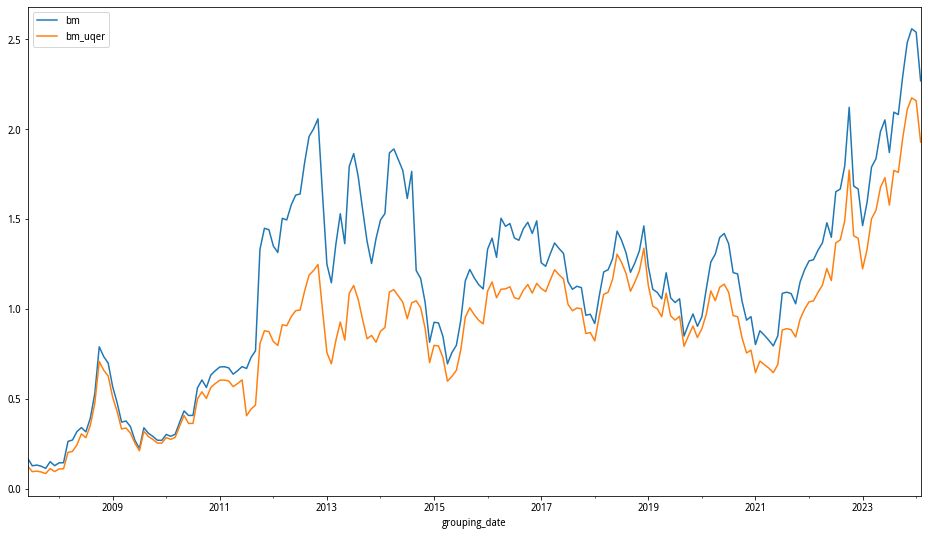

In [394]:
ret_df.loc[ret_df['secID']=='000001.XSHE',['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot()

grouping_date        bm   bm_uqer
305528       2016-12  0.636956  0.159238
305529       2017-01  0.478312  0.119579
305530       2017-02  0.443868  0.110967
305531       2017-03  0.451045  0.112761
305532       2017-04  0.633415  0.158353
305533       2017-05  0.735817  0.183955
305534       2017-06  0.743667  0.185919
305535       2017-07  0.887121  0.221779
305536       2017-08  0.828923  0.207232
305537       2017-09  0.803258  0.200815
...              ...       ...       ...
305605       2023-05  0.125095  0.096100
305606       2023-06  0.108571  0.083406
305607       2023-07  0.128602  0.098794
305608       2023-08  0.127249  0.097756
305609       2023-09  0.110902  0.085196
305610       2023-10  0.102944  0.079083
305611       2023-11  0.108383  0.083385
305612       2023-12  0.091251  0.070205
305613       2024-01  0.115134  0.088579
305614       2024-02  0.110112  0.084716

[87 rows x 3 columns]

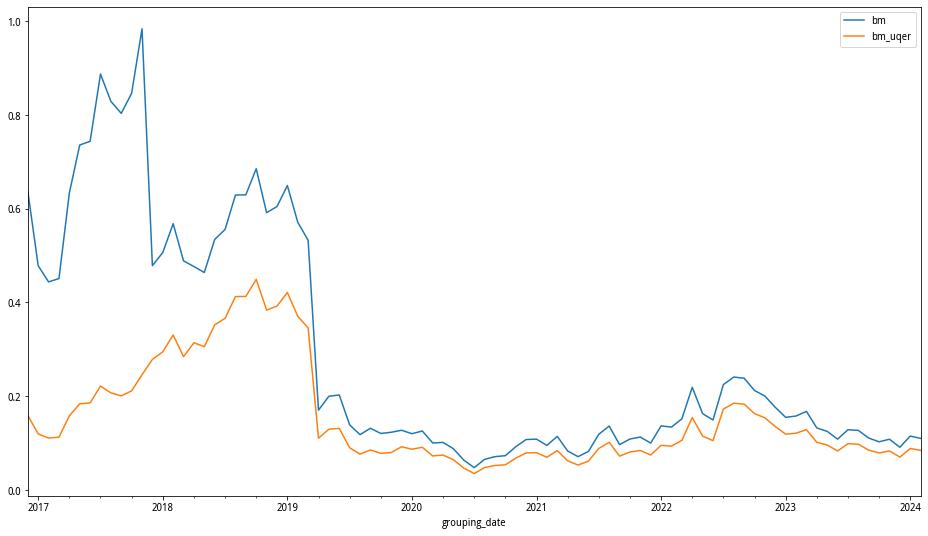

In [400]:
sample_id = np.random.choice(ret_df['secID'].unique(),1)
display(ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']])
ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d8b87ec10>,
      dtype=object)

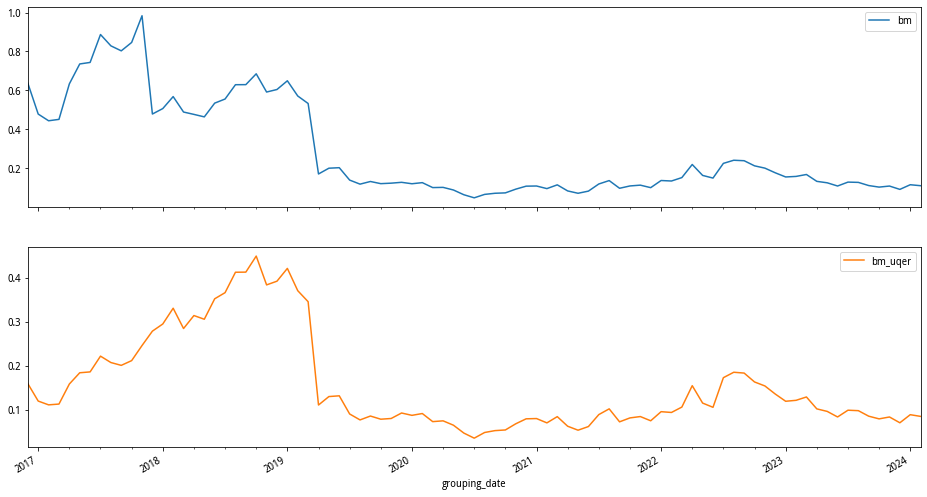

In [404]:
ret_df.loc[ret_df['secID'].isin(sample_id),['grouping_date','bm','bm_uqer']].set_index('grouping_date').plot(subplots=True)

In [405]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['grouping_date'])['bm_uqer'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='grouping_date')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['bm_uqer'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['bm_uqer']) & (ret_df_q['bm_uqer'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['bm_uqer'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean    -0.000731  0.005876  0.006934  0.008764  0.010501  0.011127  0.011030   
t-value -0.111586  0.882873  0.994702  1.313369  1.529624  1.671650  1.632897   

               p8       p9       p10    p10-p1  
mean     0.011540  0.01179  0.010692  0.011424  
t-value  1.719881  1.77387  1.623812  3.187656

# Double Sorting on Size and BM

In [406]:
q_size = dict()
keys = ['q_size_1']
values = [0.5]
q_size.update(zip(keys,values))

q_bm = dict()
keys = ['q_bm_1','q_bm_2']
values = [0.3, 0.7]
q_bm.update(zip(keys,values))

q_size_df = pd.DataFrame()
for key, value in q_size.items():
    q_size_df[key] = ret_df.groupby(['grouping_date'])['size'].quantile(value)

q_bm_df = pd.DataFrame()
for key, value in q_bm.items():
    q_bm_df[key] = ret_df.groupby(['grouping_date'])['bm'].quantile(value)

ret_df_q = pd.merge(ret_df, q_size_df, on='grouping_date')
ret_df_q = pd.merge(ret_df_q, q_bm_df, on='grouping_date')

portfolios_size = dict()
portfolios_size['size1'] = ret_df_q.loc[ret_df_q['size'] <= ret_df_q['q_size_1'],
                                           ['secID','grouping_date','ret_date','exret','size','mktcap']]
portfolios_size['size2'] = ret_df_q.loc[ret_df_q['size'] >= ret_df_q['q_size_1'],
                                           ['secID','grouping_date','ret_date','exret','size','mktcap']]

portfolios_bm = dict()
portfolios_bm['bm1'] = ret_df_q.loc[ret_df_q['bm'] <= ret_df_q['q_bm_1'],
                                           ['secID','grouping_date','ret_date','exret','bm']]
portfolios_bm['bm2'] = ret_df_q.loc[(ret_df_q['bm'] >= ret_df_q['q_bm_1']) & \
                                           (ret_df_q['bm'] <= ret_df_q['q_bm_2']),
                                           ['secID','grouping_date','ret_date','exret','bm']]
portfolios_bm['bm3'] = ret_df_q.loc[ret_df_q['bm'] >= ret_df_q['q_bm_2'],
                                           ['secID','grouping_date','ret_date','exret','bm']]

portfolios = dict()
for bm_group in portfolios_bm.keys():
    for size_group in portfolios_size.keys():
        portfolios[f'{bm_group}_{size_group}'] = pd.merge(portfolios_size[size_group],
                                                              portfolios_bm[bm_group][['secID','ret_date','bm']],
                                                              on=['secID','ret_date'])

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有bm和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['bm1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(203,)
(203,)
(203,)
(203,)
(203,)
(203,)


bm1_size1  bm1_size2  bm2_size1  bm2_size2  bm3_size1  bm3_size2
ret_mean   0.009090   0.000665   0.014475   0.003905   0.018540   0.004349
t_values   1.321203   0.104460   2.082272   0.606530   2.424012   0.689819

# Fama MacBeth regression

In [407]:
# ret_df[(ret_df['ret_date'] >= '2008-02') & (ret_df['secID'] == '000001.XSHE')]

In [408]:
ret_df['exret100'] = ret_df['exret'] * 100

def fm_reg(df):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return None
    reg = LinearRegression().fit(y=df_.loc[:,'exret100'], X=df_.loc[:,['beta','size','bm']])
    return np.insert(reg.coef_, 0, reg.intercept_)

temp = ret_df.groupby('ret_date').apply(fm_reg)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept', 'beta_coef','size_coef', 'bm_coef']
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept  beta_coef  size_coef   bm_coef
ret_mean   8.703439   0.326045  -0.378794  0.044544
t_values   2.592315   0.959551  -2.662517  0.855783

In [409]:
portfolios

{'bm1_size1':              secID grouping_date ret_date     exret       size        mktcap  \
 0      000014.XSHE       2007-06  2007-07  0.547459  21.108547  1.470028e+09   
 1      000025.XSHE       2007-06  2007-07 -0.201773  20.485442  7.883413e+08   
 2      000033.XSHE       2007-06  2007-07  0.126208  20.845732  1.130281e+09   
 3      000049.XSHE       2007-06  2007-07  0.471941  20.141541  5.589333e+08   
 4      000056.XSHE       2007-06  2007-07  0.156088  20.566809  8.551683e+08   
 5      000411.XSHE       2007-06  2007-07  0.430651  19.585247  3.204531e+08   
 6      000415.XSHE       2007-06  2007-07  0.165811  21.115524  1.480319e+09   
 7      000421.XSHE       2007-06  2007-07  0.146840  21.013886  1.337256e+09   
 8      000515.XSHE       2007-06  2007-07  0.252712  20.838220  1.121822e+09   
 9      000532.XSHE       2007-06  2007-07  0.321315  21.090814  1.444189e+09   
 ...            ...           ...      ...       ...        ...           ...   
 65461  600817.

# Fama French 3 factors

Fama-French 3 factors 的构建：

- Market return 就是 CAPM 里面的市场收益率
- 另外还有 SMB，HML，也即 Small-Minus-Big, High-Minus-Low

构建方法：

- mktcap1 也叫做 Small, mktcap2 Big. bm1 Low, bm2 Medium, bm3 High. 
- 因此对应的，我们的
    - bm1_mktcap1: SL
    - bm2_mktcap1: SM
    - bm3_mktcap1: SH
    - bm1_mktcap2: BL
    - bm2_mktcap2: BM
    - bm3_mktcap2: BH
- 在 Fama French (1993) 的构建里，mktcap 是在t年6月形成并保持到t+1年5月不变。bm和我们这里的构建一样，t年6月按照t-1年的BM ratio构建，保持到t+1年5月不变。
- Fama French 计算了这6组资产组合每一年从7月到下一年6月(资产形成期的第二个月的收益率)的 value-weighted excess return。weight 是t年6月的mktcap占所在portfolio 总的 mktcap 的比重。
- SMB: (SL+SM+SH)/3 - (BL+BM+BH)/3。这样构建的意思是把BM的影响平均掉。
- HML: (SH+BH)/2 - (SL+BL)/2

这里我们还是按照mktcap组合的构建日期，不改成和 Fama-French (1993) 原文一样的日期(t年6月)

In [410]:
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ret_date')['mktcap'].agg({'mktcapsum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ret_date')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcapsum']
    portfolios[pf]['weighted_exret'] = portfolios[pf]['exret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_exret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret['bm1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()
portfolios_vwret_df.rename(columns={"bm1_size1": "SL",
                                    "bm2_size1": "SM",
                                    "bm3_size1": "SH",
                                    "bm1_size2": "BL",
                                    "bm2_size2": "BM",
                                    "bm3_size2": "BH"},
                          inplace=True) # vw: value weighted

In [411]:
portfolios_vwret_df

SL        BL        SM        BM        SH        BH
ret_date                                                            
2007-05   0.071362  0.112077  0.081912  0.098783  0.053438  0.081964
2007-06  -0.201392 -0.054659 -0.178662 -0.084690 -0.182697 -0.075787
2007-07   0.234973  0.185368  0.257258  0.189900  0.280729  0.192456
2007-08   0.070802  0.149934  0.102963  0.152349  0.109116  0.181313
2007-09   0.022462  0.019254  0.018286  0.042721  0.047119  0.103958
2007-10  -0.105863 -0.000321 -0.115498 -0.037586 -0.116933  0.017789
2007-11  -0.031662 -0.179535 -0.046609 -0.136686 -0.036438 -0.148290
2007-12   0.205897  0.137131  0.197296  0.165248  0.191610  0.106343
2008-01  -0.082404 -0.103462 -0.060240 -0.103317 -0.042012 -0.169955
2008-02   0.086033  0.016389  0.119168  0.033018  0.104149  0.014488
...            ...       ...       ...       ...       ...       ...
2023-06   0.025666  0.019494  0.041583  0.018262  0.016999 -0.001084
2023-07  -0.010264  0.002281 -0.001690  0.025373  0.028885  0.075968
2023-08  -0.033373 -0.055725 -0.032530 -0.060224 -0.033911 -0.059155
2023-09   0.006949 -0.029666  0.001824 -0.001621 -0.008480  0.007229
2023-10  -0.001610 -0.028103  0.004487 -0.022098 -0.012435 -0.037685
2023-11   0.058239  0.000234  0.057021 -0.001125  0.031522 -0.010649
2023-12  -0.013533 -0.027493 -0.012145 -0.021259 -0.020581 -0.017663
2024-01  -0.221299 -0.161830 -0.220379 -0.108842 -0.188385  0.019751
2024-02   0.034395  0.127738  0.022374  0.101909  0.018930  0.051783
2024-03   0.076867  0.012810  0.073233  0.012189  0.058665 -0.002009

[203 rows x 6 columns]

In [412]:
SMB = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 - \
      (portfolios_vwret_df['BL'] + portfolios_vwret_df['BM'] + portfolios_vwret_df['BH']) / 3 

HML = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 - \
      (portfolios_vwret_df['SL'] + portfolios_vwret_df['BL']) / 2 

factors_df = pd.DataFrame(np.vstack([SMB,HML])).T
factors_df.columns = ['SMB','HML']
factors_df.index = SMB.index

In [413]:
factors_df

SMB       HML
ret_date                    
2007-05  -0.028704 -0.024019
2007-06  -0.115872 -0.001216
2007-07   0.068412  0.026422
2007-08  -0.066905  0.034846
2007-09  -0.026022  0.054680
2007-10  -0.106058  0.003520
2007-11   0.116601  0.013235
2007-12   0.062027 -0.022538
2008-01   0.064026 -0.013051
2008-02   0.081818  0.008108
...            ...       ...
2023-06   0.015859 -0.014623
2023-07  -0.028897  0.056418
2023-08   0.025097 -0.001984
2023-09   0.008117  0.010733
2023-10   0.026110 -0.010204
2023-11   0.052774 -0.018800
2023-12   0.006719  0.001391
2024-01  -0.126380  0.107248
2024-02  -0.068577 -0.045710
2024-03   0.061925 -0.016510

[203 rows x 2 columns]

百度百科：中证800指数是由中证指数有限公司编制，其成份股是由中证500和沪深300成份股一起构成，中证800指数综合反映沪深证券市场内大中市值公司的整体状况。

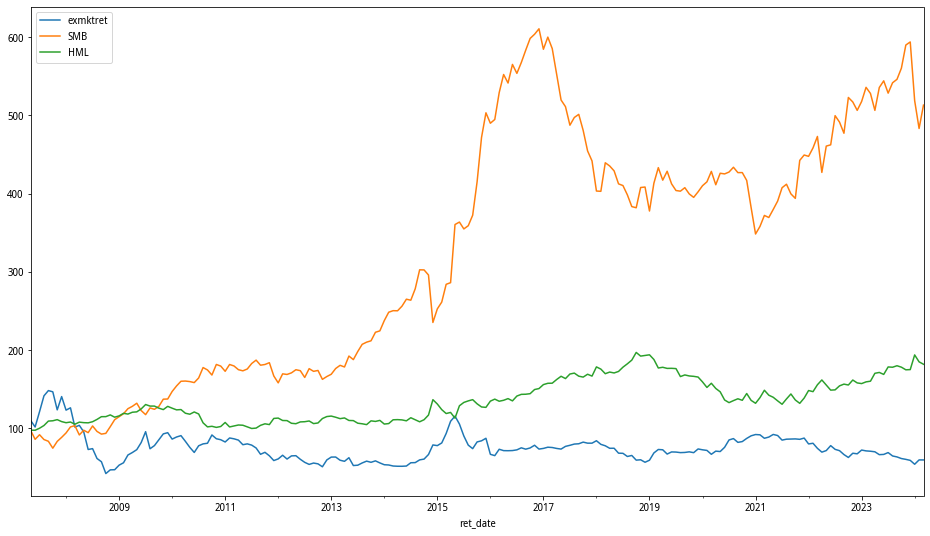

In [414]:
# index_info = DataAPI.SecIDGet(assetClass="IDX",pandas="1")

# 用中证800作为market return
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])
index_df['ret_date'] = index_df['tradeDate'].dt.to_period('M')

index_df.sort_values('tradeDate',inplace=True)
index_df = index_df.groupby('ret_date',as_index=False).last()
index_df['mktret'] = index_df['closeIndex'] / index_df['closeIndex'].shift() - 1

index_df = pd.merge(index_df,rf,left_on=['ret_date'],right_on=['ym'])
index_df['exmktret'] = index_df['mktret'] - index_df['rf']

index_df.drop(['ym','mktret','rf','indexID','secShortName','tradeDate',
               'closeIndex','CHGPct'],axis=1,inplace=True)

index_df.dropna(inplace=True)

factors_df = pd.merge(index_df, factors_df, on='ret_date')

factors_df['ret_date'] = factors_df['ret_date'].dt.to_timestamp(how='end').dt.normalize()

factors_df.set_index('ret_date',inplace=True)

((1 + factors_df).cumprod()*100).plot()

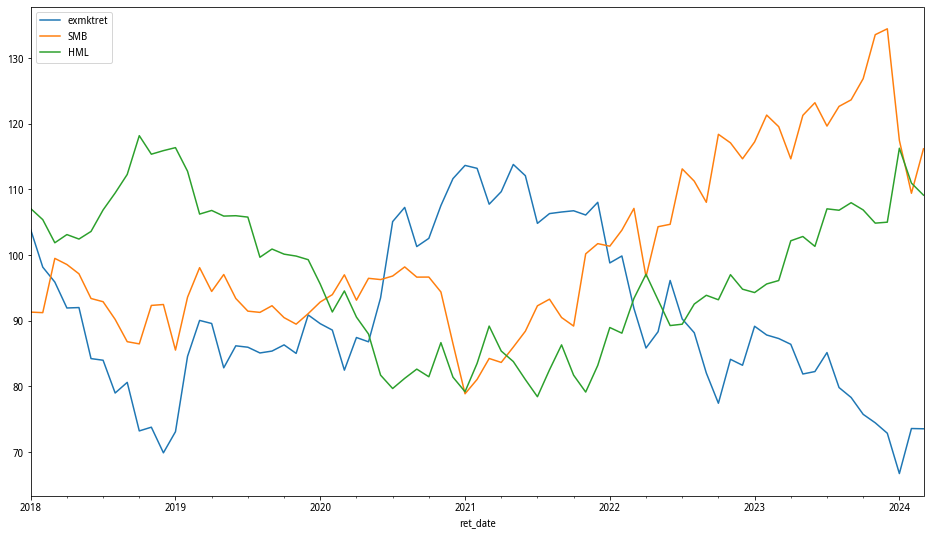

In [415]:
((1 + factors_df.loc['2018':]).cumprod()*100).plot()

In [416]:
factors_df

exmktret       SMB       HML
ret_date                                
2007-05-31  0.098693 -0.028704 -0.024019
2007-06-30 -0.074622 -0.115872 -0.001216
2007-07-31  0.192240  0.068412  0.026422
2007-08-31  0.167193 -0.066905  0.034846
2007-09-30  0.047263 -0.026022  0.054680
2007-10-31 -0.010382 -0.106058  0.003520
2007-11-30 -0.157389  0.116601  0.013235
2007-12-31  0.137366  0.062027 -0.022538
2008-01-31 -0.123254  0.064026 -0.013051
2008-02-29  0.024010  0.081818  0.008108
...              ...       ...       ...
2023-06-30  0.004545  0.015859 -0.014623
2023-07-31  0.035149 -0.028897  0.056418
2023-08-31 -0.062576  0.025097 -0.001984
2023-09-30 -0.018904  0.008117  0.010733
2023-10-31 -0.032835  0.026110 -0.010204
2023-11-30 -0.017006  0.052774 -0.018800
2023-12-31 -0.021342  0.006719  0.001391
2024-01-31 -0.084298 -0.126380  0.107248
2024-02-29  0.102804 -0.068577 -0.045710
2024-03-31 -0.000526  0.061925 -0.016510

[203 rows x 3 columns]

In [417]:
factors_df.to_csv('./output_data/factors/ff3.csv')

## Long-only factors

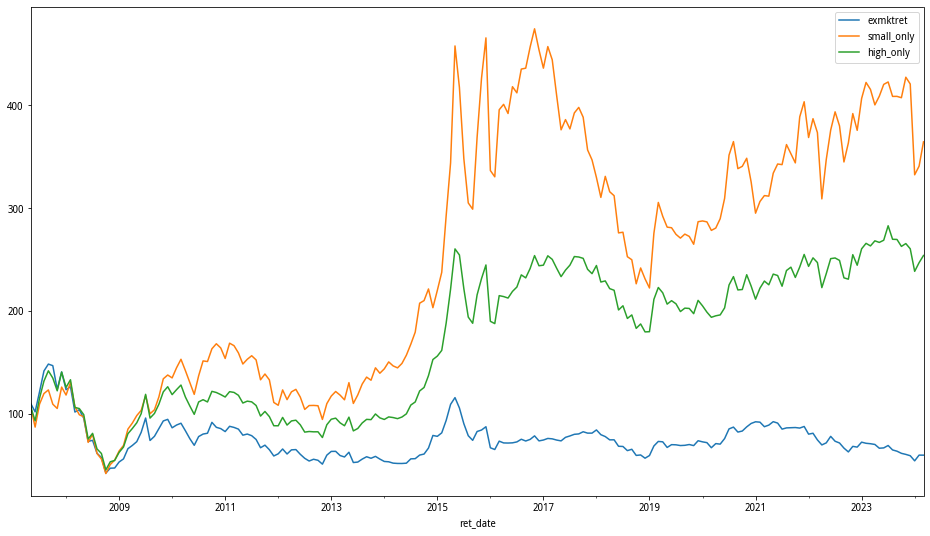

In [418]:
small_only = (portfolios_vwret_df['SL'] + portfolios_vwret_df['SM'] + portfolios_vwret_df['SH']) / 3 

high_only = (portfolios_vwret_df['SH'] + portfolios_vwret_df['BH']) / 2 

factors_long_df = pd.DataFrame(np.vstack([small_only,high_only])).T
factors_long_df.columns = ['small_only','high_only']
factors_long_df.index = small_only.index

factors_long_df = pd.merge(index_df, factors_long_df, on='ret_date')

factors_long_df['ret_date'] = factors_long_df['ret_date'].dt.to_timestamp(freq='day',how='end').dt.normalize()

factors_long_df.set_index('ret_date',inplace=True)

((1 + factors_long_df).cumprod()*100).plot()

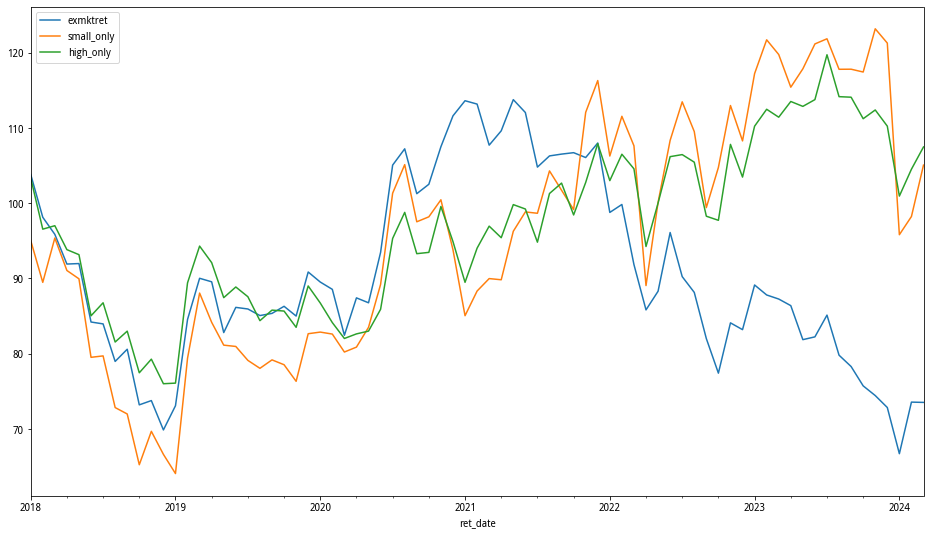

In [419]:
((1 + factors_long_df.loc['2018':]).cumprod()*100).plot()

In [420]:
factors_long_df

exmktret  small_only  high_only
ret_date                                   
2007-05-31  0.098693    0.068904   0.067701
2007-06-30 -0.074622   -0.187584  -0.129242
2007-07-31  0.192240    0.257653   0.236593
2007-08-31  0.167193    0.094294   0.145215
2007-09-30  0.047263    0.029289   0.075538
2007-10-31 -0.010382   -0.112765  -0.049572
2007-11-30 -0.157389   -0.038236  -0.092364
2007-12-31  0.137366    0.198268   0.148977
2008-01-31 -0.123254   -0.061552  -0.105984
2008-02-29  0.024010    0.103117   0.059319
...              ...         ...        ...
2023-06-30  0.004545    0.028083   0.007957
2023-07-31  0.035149    0.005644   0.052426
2023-08-31 -0.062576   -0.033271  -0.046533
2023-09-30 -0.018904    0.000098  -0.000625
2023-10-31 -0.032835   -0.003186  -0.025060
2023-11-30 -0.017006    0.048927   0.010436
2023-12-31 -0.021342   -0.015419  -0.019122
2024-01-31 -0.084298   -0.210021  -0.084317
2024-02-29  0.102804    0.025233   0.035357
2024-03-31 -0.000526    0.069588   0.028328

[203 rows x 3 columns]

In [421]:
factors_long_df.to_csv('./output_data/factors/ff3_long_only.csv')